In [1]:
#jupyter nbconvert --to script full_notebook.ipynb
#! Ver cómo cambiar el hyperband para que busque más configuraciones si saturan. O para que descarte las que saturan a una sola clase.
#! Comparar con lo que encuentra Random Search y Grid search.
#! El number of estimators del random forest, hacer una especie de early stopping hasta el máximo en el que se hizo el hpo

In [2]:
# # Remove any existing log files
# import os
# import glob
# import logging

# # Reset logger to avoid any issues with permissions
# logging.shutdown()
# # Remove loggers
# for log_file in glob.glob("*.log"):
#     os.remove(log_file)



# 0. Setup and Configuration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For confusion matrix heatmap
from scipy.stats import randint, uniform, loguniform # Ensure loguniform is imported if used
import os
import json
import time
from datetime import datetime
import math
import logging
from tqdm import tqdm  
from IPython.display import display
#from tqdm.notebook import tqdm # Needs pip install ipywidgets
#from tqdm.auto import tqdm
import joblib # For saving/loading models efficiently

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import loguniform # For hyperparameter distributions
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, precision_recall_curve, auc, f1_score, average_precision_score
)   
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import NotFittedError

# Boosting models
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb
from lightgbm import early_stopping

# Configure logging
logging.shutdown()
logging.basicConfig(
    filename=f'models_{datetime.now().strftime("%d_%H-%M-%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    force=True
)
# Prevent logs from being printed to console
logging.getLogger().handlers = [h for h in logging.getLogger().handlers if isinstance(h, logging.FileHandler)]

## 1. Loading Dataset & Feature Selection

- Group 1: Morphology (magnitudes with errors).
- Group 2: Photometry (magnitudes with errors).
- Group 3: Combined morphology and photometry.

In [4]:
# import pandas as pd

# # ------------------------------------------------------------------
# # 0) Read your own catalogue (already OK)
# df = pd.read_csv("data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv")

# # ------------------------------------------------------------------
# # 1) Read the VizieR file, drop the two non-data rows, keep just ID & cnn
# cnn = (
#     pd.read_csv(
#         r"data\cnn.tsv",
#         sep=";",          # the file is semicolon-separated
#         comment="#",      # ignore every VizieR header line
#         header=0,         # first non-comment line is the column header
#         engine="python"   # more forgiving with odd lines
#     )
#     .iloc[2:]             # drop the units row and the dashed separator row
#     .loc[:, ["ID", "cnn"]]
# )

# # 2) Make sure both key columns are the *same* dtype
# cnn["ID"]  = pd.to_numeric(cnn["ID"],  errors="coerce").astype("Int64")
# df["ID_1"] = pd.to_numeric(df["ID_1"], errors="coerce").astype("Int64")

# # 3) Merge and get rid of the duplicate ID column that merge adds
# df = (
#     df.merge(cnn, left_on="ID_1", right_on="ID", how="left")
#       .drop(columns="ID")
# )

# # ------------------------------------------------------------------
# # Check
# print(df[["ID_1", "cnn"]].head())



In [5]:
# ==============================================================
#  Diagnose cnn values in the test set
# ==============================================================

import pandas as pd
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------------
# 1) Read catalogue + add cnn (same as before)
# ------------------------------------------------------------------
df = pd.read_csv("data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv")

cnn = (
    pd.read_csv(
        r"data/cnn.tsv",
        sep=";",
        comment="#",
        header=0,
        engine="python"
    )
    .iloc[2:]
    .loc[:, ["ID", "cnn"]]
)

cnn["ID"]  = pd.to_numeric(cnn["ID"],  errors="coerce").astype("Int64")
df["ID_1"] = pd.to_numeric(df["ID_1"], errors="coerce").astype("Int64")

df = df.merge(cnn, left_on="ID_1", right_on="ID", how="left").drop(columns="ID")

# ------------------------------------------------------------------
# 2) Clean target (drop fake class 3, map 1→0, 2→1)
# ------------------------------------------------------------------
df = df[df["acs_mu_class"] != 3]
df["acs_mu_class"] = df["acs_mu_class"].map({1: 0, 2: 1}).astype(int)

# ------------------------------------------------------------------
# 3) Reproduce the original split
# ------------------------------------------------------------------
TEST_SIZE, VAL_SIZE, SEED = 0.20, 0.20, 33
y_full = df["acs_mu_class"]

df_train, df_tmp, y_train, y_tmp = train_test_split(
    df, y_full, test_size=TEST_SIZE + VAL_SIZE,
    stratify=y_full, random_state=SEED
)
rel_val = VAL_SIZE / (TEST_SIZE + VAL_SIZE)
df_val, df_test = train_test_split(
    df_tmp, test_size=1 - rel_val,
    stratify=y_tmp, random_state=SEED
)

# ------------------------------------------------------------------
# 4) Inspect cnn in the *test set*
# ------------------------------------------------------------------
print("cnn dtype in test set:", df_test["cnn"].dtype)

unique_vals = df_test["cnn"].unique()
print("\nDistinct raw cnn values (up to 15 shown):", unique_vals[:15], "…\n")

# Convert to numeric for a robust comparison (strings → numbers, non-numeric → NaN)
cnn_numeric = pd.to_numeric(df_test["cnn"], errors="coerce")

missing_numeric  = (cnn_numeric == -1)
missing_strings  = df_test["cnn"].astype(str).str.strip().isin(["-1", "-1.0"])
missing_isna     = cnn_numeric.isna()

# Combine the three flags
missing_any = missing_numeric | missing_strings | missing_isna

print(f"Test-set size: {len(df_test):,}")
print(f"cnn == -1   (numeric compare) : {missing_numeric.sum():,}")
print(f"cnn == '-1' (string compare)  : {missing_strings.sum():,}")
print(f"cnn non-numeric (NaN)         : {missing_isna.sum():,}")
print(f"▶ Total objects treated as 'missing cnn': {missing_any.sum():,}"
      f" ({missing_any.mean():.2%})")

# ------------------------------------------------------------------
# 5) Repeat inside the F814W ≤ 22.5 subset
# ------------------------------------------------------------------
mask_mag = df_test["F814W"] <= 22.5
cnn_numeric_mag = cnn_numeric[mask_mag]

missing_any_mag = (
    (cnn_numeric_mag == -1) |
    df_test.loc[mask_mag, "cnn"].astype(str).str.strip().isin(["-1", "-1.0"]) |
    cnn_numeric_mag.isna()
)

print(f"\nSubset F814W ≤ 22.5: {mask_mag.sum():,}")
print(f"▶ Missing cnn in subset: {missing_any_mag.sum():,}"
      f" ({missing_any_mag.mean():.2%})")


cnn dtype in test set: object

Distinct raw cnn values (up to 15 shown): ['-1.000000000000000000e+00' ' 2.695833519101142883e-02'
 ' 3.677513450384140015e-02' ' 6.524165160953998566e-03'
 ' 9.705360047519207001e-03' ' 9.915711879730224609e-01'
 ' 1.029389095492660999e-03' ' 5.807562731206417084e-03'
 ' 7.556056976318359375e-02' ' 1.532580051571130753e-02'
 ' 1.673855632543563843e-02' ' 2.362821996212005615e-02'
 ' 1.615512371063232422e-01' ' 9.977686405181884766e-01'
 ' 8.927586078643798828e-01'] …

Test-set size: 5,478
cnn == -1   (numeric compare) : 3,387
cnn == '-1' (string compare)  : 0
cnn non-numeric (NaN)         : 1
▶ Total objects treated as 'missing cnn': 3,388 (61.85%)

Subset F814W ≤ 22.5: 956
▶ Missing cnn in subset: 448 (46.86%)


In [6]:
# Read the df
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
logging.info(f"DataFrame created with shape: {df.shape}")
# Map ACS classification: 1 (Galaxy, Majority) -> 0, 2 (Star, minority) -> 1, 3 (Fake) -> drop
logging.info("Original class counts:")
logging.info(df['acs_mu_class'].value_counts().to_string())

# Drop fake detections (class 3)
# Drop fake detections
n_fakes = (df['acs_mu_class'] == 3).sum()
logging.info(f"Number of fake detections (class 3): {n_fakes}")
df = df[df['acs_mu_class'] != 3]

# Map classifications
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

logging.info("After dropping fakes and mapping classes (0: Galaxy, 1: Star):")
logging.info(df['acs_mu_class'].value_counts().to_string())

In [7]:
# Input features

# --- Modeling features ---

# 1. ALHAMBRA Morphology Features (SExtractor-based)
morphology_features = [
    'area', 'fwhm', 'stell', 
    'ell', #'a', 'b', #'theta', #a,b son fwhm y ell. Theta no da info.
    'rk', 
    'rf'
]

morphology_err = [
    's2n'
]

morphology_mags_errors = morphology_features + morphology_err

# 2. ALHAMBRA Photometry (Optical + NIR + Synthetic)
OPTICAL_MAG_COLS = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W',
    'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W',
    'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W'
]
photometry_magnitudes = (
    OPTICAL_MAG_COLS +
    ['J', 'H', 'KS', 'F814W']
)

OPTICAL_ERR_COLS = [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W'
]
photometry_uncertainties = (
    OPTICAL_ERR_COLS +
    ['dJ', 'dH', 'dKS', 'dF814W']
)

photometry_mags_errors = photometry_magnitudes + photometry_uncertainties

# Target from acs
target_variable = ['acs_mu_class'] # The COSMOS classification label to predict

# --- Non-Modeling features ---

# ALHAMBRA Photometric Redshift & Derived Features (BPZ-based)
redshift_magnitudes = [
    'zb_1', 'zb_Min_1', 'zb_Max_1', 'Tb_1',
    'z_ml', 't_ml',
    'Stell_Mass_1', 'M_Abs_1', 'MagPrior'
]

redshift_uncertainties = [
    'Odds_1', 'Chi2'
]

redshift_mags_errors = redshift_magnitudes + redshift_uncertainties

# ALHAMBRA Quality/Auxiliary Features (per-band quality etc.)
OPTICAL_IRMS_COLS = [
    'irms_F365W', 'irms_F396W', 'irms_F427W', 'irms_F458W', 'irms_F489W',
    'irms_F520W', 'irms_F551W', 'irms_F582W', 'irms_F613W', 'irms_F644W',
    'irms_F675W', 'irms_F706W', 'irms_F737W', 'irms_F768W', 'irms_F799W',
    'irms_F830W', 'irms_F861W', 'irms_F892W', 'irms_F923W', 'irms_F954W'
]
quality_aux_features = (
    ['nfobs'] +
    OPTICAL_IRMS_COLS +
    ['irms_J', 'irms_H', 'irms_KS', 'irms_F814W']
)

# Flags and identifiers

non_modeling_identifiers = ['ID_1', 'id_2'] # ALHAMBRA ID, COSMOS ID

non_modeling_astrometry = [
    'RA_1', 'Dec_1', 'x', 'y', # ALHAMBRA Astrometry
    'ra_2', 'dec_2',          # COSMOS Astrometry
    'Separation'              # Matching Quality
]

non_modeling_flags = [
    'photoflag', 'xray', 'PercW', 'Satur_Flag', # ALHAMBRA Object/Photometry Flags
    'irms_OPT_Flag', 'irms_NIR_Flag'           # ALHAMBRA Overall Quality Flags
]

alhambra_prediction = ['Stellar_Flag'] # ALHAMBRA's own classification

non_modeling_aperture_mags = [ # Specific aperture mags, usually use total mags
    'F814W_3arcs', 'dF814W_3arcs', 'F814W_3arcs_corr'
]

non_modeling_cosmos_features = [ # Measurements/flags derived from COSMOS data (HST, HSC, VISTA...)
    'model_flag',
    'flag_hsc', 'flag_supcam', 'flag_udeep', 'flag_uvista',
    'hsc_r_mag', 'hsc_r_magerr', 'hsc_r_valid',
    'hsc_i_mag', 'hsc_i_magerr', 'hsc_i_valid',
    'uvista_j_mag', 'uvista_j_magerr', 'uvista_j_valid',
    'uvista_ks_mag', 'uvista_ks_magerr', 'uvista_ks_valid',
    'acs_f814w_mag', 'acs_f814w_magerr',
    'acs_fwhm_world', 'acs_mu_max',
    'solution_model' # This is categorical, but still COSMOS-derived info
]




# Storing features
feature_sets = {
        # --- Potential Input Feature Sets ---
        'morphology_only': morphology_mags_errors,
        'photometry_magnitudes_only': photometry_magnitudes,
        'photometry_mags_errors': photometry_mags_errors,
        'photometry_plus_morphology': photometry_mags_errors + morphology_mags_errors,
        'photometry_no_redshift': photometry_mags_errors + morphology_mags_errors + quality_aux_features,
        'redshift_only': redshift_mags_errors,
        'full_alhambra_all': (morphology_mags_errors +
                            photometry_mags_errors +
                            redshift_mags_errors + 
                            quality_aux_features),

        # --- Excluded Feature Sets ---
        'non_modeling_identifiers': non_modeling_identifiers,
        'non_modeling_astrometry': non_modeling_astrometry,
        'non_modeling_flags': non_modeling_flags,
        'non_modeling_aperture_mags': non_modeling_aperture_mags,
        'non_modeling_cosmos_features': non_modeling_cosmos_features,
        'alhambra_prediction': alhambra_prediction,
        'target_variable': target_variable
    }

# Groups of features for modeling
groups = {
        'group_1': feature_sets.get('morphology_only', []) + feature_sets.get('target_variable', []),
        'group_2': feature_sets.get('photometry_mags_errors', []) + feature_sets.get('target_variable', []),
        'group_3': (feature_sets.get('morphology_only', []) +
                   feature_sets.get('photometry_mags_errors', []) +
                   feature_sets.get('target_variable', []))
    }

# --- Function to get a specific feature set ---

def get_feature_set(df, set_name, groups = groups):
    """
    Selects columns from a DataFrame based on a predefined feature set name,
    including six specific groups defined by combinations of morphology,
    photometry magnitudes, uncertainties, and redshift features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        set_name (str): The name of the desired feature set group:
                        'group_1' to 'group_6' as defined below.

    Returns:
        pd.DataFrame: A DataFrame containing only the columns
                      belonging to the specified feature set group.
                      Returns an empty DataFrame if no columns are found.
    """

    if set_name not in groups:
        raise ValueError(f"Feature set group '{set_name}' not defined. "
                         f"Available groups: {list(groups.keys())}")

    required_cols_in_set = groups[set_name]

    # Find which of these columns actually exist in the DataFrame
    available_cols = [col for col in required_cols_in_set if col in df.columns]

    # Warn if some columns from the set definition are missing
    missing_cols = [col for col in required_cols_in_set if col not in available_cols]
    if missing_cols:
        print(f"Warning: The following columns defined for feature set group '{set_name}'"
              f" were not found in the DataFrame and will be excluded: {missing_cols}")

    if not available_cols:
        print(f"Warning: No columns for feature set group '{set_name}' found in the DataFrame.")
        return pd.DataFrame()  # Return empty DataFrame

    print(f"Selecting feature set group '{set_name}' with {len(available_cols)} columns.")
    return df[available_cols]


## 2. Data Preprocessing and Splitting

In [8]:
# Data splitting parameters
TEST_SIZE = 0.20 # Test set proportion
VAL_SIZE = 0.20 # Validation set proportion
CAL_SIZE = 0.00 # Calibration set proportion
# Train size will be 1 - (TEST_SIZE + VAL_SIZE + CAL_SIZE)

TARGET_COLUMN = feature_sets.get('target_variable', [])[0]
RANDOM_SEED = 33 # For reproducibility

# Model saving directory
MODEL_DIR = "trained_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Data splitting strategy ('stratified' or 'random')
SPLIT_STRATEGY = 'stratified' # Recommended for imbalanced datasets


In [9]:
# --- Data Cleaning ---
def clean_data(df, feature_group, target_column, logger=logging):
    """
    Cleans the input DataFrame by selecting features for the given group,
    dropping NaNs, and separating features and target.

    Args:
        df (pd.DataFrame): The input DataFrame.
        feature_group (str): The feature group to use (e.g., 'group_1', 'group_2', etc.).
        target_column (str): The name of the target column.
        logger (logging.Logger): Logger for info and error messages.

    Returns:
        X (pd.DataFrame): Cleaned feature DataFrame.
        y (pd.Series): Target variable.
        df_clean (pd.DataFrame): The cleaned DataFrame (features + target).
    """
    logger.info(f"Original dataset size: {df.shape}")

    # Get the feature columns for the selected group using get_feature_set
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    logger.info(f"Dataset size after dropping NaNs: {df_clean.shape}")

    # Ensure target_column is defined correctly
    if target_column not in df_clean.columns:
        raise KeyError(f"Target column '{target_column}' not found in the cleaned DataFrame columns: {df_clean.columns.tolist()}")

    # Log value counts for target
    logger.info(f"Value counts for target:\n1 (Star): {(df_clean[target_column] == 1).sum()}\n0 (Galaxy): {(df_clean[target_column] == 0).sum()}")

    # Separate features (X) and target (y) for the cleaned DataFrame
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y, df_clean

# Example usage:
# X, y, df_clean = clean_data(df, feature_group='group_7', target_column=TARGET_COLUMN, logger=logging)

In [10]:
# --- Data Splitting ---
def split_data(X, y):
    """
    Splits the data into train, validation, test, and calibration sets according to the global
    split proportions and strategy. Uses global variables:
        - TEST_SIZE, VAL_SIZE, CAL_SIZE, SPLIT_STRATEGY, RANDOM_SEED

    The logic and split order is identical to the original code.

    Args:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target variable.

    Returns:
        (X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal): tuple of splits.
    """
    logging.info(f"Splitting data using '{SPLIT_STRATEGY}' strategy...")

    # --- Validate Proportions ---
    if not (0 <= TEST_SIZE <= 1 and 0 <= VAL_SIZE <= 1 and 0 <= CAL_SIZE <= 1):
        raise ValueError("Split proportions (TEST_SIZE, VAL_SIZE, CAL_SIZE) must be between 0 and 1.")

    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    if not (0 <= TRAIN_SIZE <= 1):
        raise ValueError(f"Calculated TRAIN_SIZE ({TRAIN_SIZE:.3f}) is invalid. Sum of TEST_SIZE, VAL_SIZE, and CAL_SIZE must be between 0 and 1.")

    if not np.isclose(TRAIN_SIZE + TEST_SIZE + VAL_SIZE + CAL_SIZE, 1.0):
        # This check might be redundant given the calculation of TRAIN_SIZE, but good for safety.
        raise ValueError("Sum of split proportions must be equal to 1.")

    if np.isclose(TRAIN_SIZE, 0) and (np.isclose(VAL_SIZE, 0) or np.isclose(TEST_SIZE, 0) or np.isclose(CAL_SIZE, 0)):
        # Avoid scenarios where train is 0 but other splits are also 0, leading to ambiguity.
        # If only train is 0, it might be valid in some rare cases, but usually requires at least one other non-zero split.
        # Let's enforce Train > 0 for typical ML workflows.
        # If you need zero training data, adjust this check.
        logging.warning("TRAIN_SIZE is zero or near zero. Ensure this is intended.")
        if TRAIN_SIZE < 0: # Definitely an error
            raise ValueError("TRAIN_SIZE cannot be negative.")
        # Allow TRAIN_SIZE = 0 only if explicitly handled later, otherwise raise error?
        # For now, let's proceed but log a warning. If TRAIN_SIZE must be > 0, uncomment the raise below.
        # raise ValueError("TRAIN_SIZE must be greater than 0 for typical model training.")

    logging.info(f"Target split ratios: Train={TRAIN_SIZE:.2f}, Val={VAL_SIZE:.2f}, Test={TEST_SIZE:.2f}, Cal={CAL_SIZE:.2f}")

    # --- Initialize Splits ---
    # Use iloc[0:0] to create empty DataFrames/Series with the same columns/dtype
    empty_X = X.iloc[0:0]
    empty_y = y.iloc[0:0]
    X_train, y_train = empty_X.copy(), empty_y.copy()
    X_val, y_val = empty_X.copy(), empty_y.copy()
    X_test, y_test = empty_X.copy(), empty_y.copy()
    X_cal, y_cal = empty_X.copy(), empty_y.copy()

    # Temporary variables for sequential splitting
    X_remaining, y_remaining = X.copy(), y.copy() # Use copies to avoid modifying original X, y

    # --- Stratification Option ---
    # Define stratify_func only once
    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    # --- First Split: Train vs. Remainder (Val + Test + Cal) ---
    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE

    if np.isclose(val_test_cal_size, 0): # Only Train set needed
        X_train, y_train = X_remaining, y_remaining
        logging.info("All data assigned to Train set (Val, Test, Cal sizes are 0).")
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy() # No remainder
    elif np.isclose(TRAIN_SIZE, 0): # No Train set needed
        logging.info("Train set is empty (TRAIN_SIZE=0). Remainder passed to next splits.")
        # X_remaining, y_remaining already hold all data
    else: # Split Train vs Remainder
        split_test_size = val_test_cal_size # Proportion of remainder relative to total (1.0)
        X_train, X_remaining, y_train, y_remaining = train_test_split(
            X_remaining, y_remaining,
            test_size=split_test_size,
            random_state=RANDOM_SEED,
            stratify=get_stratify_array(y_remaining)
        )
    logging.info(f"Train set shape: {X_train.shape}")

    # --- Second Split: Val vs. Remainder (Test + Cal) ---
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = VAL_SIZE + test_cal_size # = val_test_cal_size

        if np.isclose(VAL_SIZE, 0): # No Val set, pass remainder to next stage
            X_temp2, y_temp2 = X_remaining, y_remaining # Remainder is Test + Cal
            logging.info("Validation set is empty (VAL_SIZE=0).")
        elif np.isclose(test_cal_size, 0): # Only Val set left in remainder
            X_val, y_val = X_remaining, y_remaining
            X_temp2, y_temp2 = empty_X.copy(), empty_y.copy() # No data left for Test/Cal
            logging.info(f"Validation set shape: {X_val.shape}")
        else: # Split Val vs (Test + Cal)
            # Proportion of (Test + Cal) relative to (Val + Test + Cal)
            split_test_size = test_cal_size / current_remaining_size_frac
            X_val, X_temp2, y_val, y_temp2 = train_test_split(
                X_remaining, y_remaining,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_remaining)
            )
            logging.info(f"Validation set shape: {X_val.shape}")
    else: # No data remaining after train split
        X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
        if not np.isclose(VAL_SIZE, 0): # Log only if Val set was expected
            logging.info("Validation set is empty (no data remaining after train split).")

    # --- Third Split: Test vs. Cal ---
    if not X_temp2.empty:
        # Denominator for relative size calculation: size of the current remaining pool
        current_remaining_size_frac = TEST_SIZE + CAL_SIZE # = test_cal_size

        if np.isclose(CAL_SIZE, 0): # No Cal set, remainder is Test
            X_test, y_test = X_temp2, y_temp2
            logging.info("Calibration set is empty (CAL_SIZE=0).")
        elif np.isclose(TEST_SIZE, 0): # Only Cal set left in remainder
            X_cal, y_cal = X_temp2, y_temp2
            logging.info("Test set is empty (TEST_SIZE=0).")
        else: # Split Test vs Cal
            # Proportion of Cal relative to (Test + Cal)
            split_test_size = CAL_SIZE / current_remaining_size_frac
            X_test, X_cal, y_test, y_cal = train_test_split(
                X_temp2, y_temp2,
                test_size=split_test_size,
                random_state=RANDOM_SEED,
                stratify=get_stratify_array(y_temp2)
            )
            # Logging shapes done after the if/else block
    else: # No data remaining for Test/Cal split
        if not (np.isclose(TEST_SIZE, 0) and np.isclose(CAL_SIZE, 0)): # Log only if Test or Cal were expected
            logging.info("Test and Calibration sets are empty (no data remaining for final split).")

    # Log final shapes for Test and Cal
    logging.info(f"Test set shape: {X_test.shape}")
    logging.info(f"Calibration set shape: {X_cal.shape}")

    # --- Verification and Final Logging ---
    total_len = len(X_train) + len(X_val) + len(X_test) + len(X_cal)
    original_len = len(X)

    if total_len != original_len:
        # Calculate actual proportions based on lengths
        actual_train = len(X_train) / original_len if original_len > 0 else 0
        actual_val = len(X_val) / original_len if original_len > 0 else 0
        actual_test = len(X_test) / original_len if original_len > 0 else 0
        actual_cal = len(X_cal) / original_len if original_len > 0 else 0
        logging.warning(f"Total split length ({total_len}) does not exactly match original length ({original_len}). "
                        f"This can happen with stratification or rounding. "
                        f"Target proportions: Train={TRAIN_SIZE:.3f}, Val={VAL_SIZE:.3f}, Test={TEST_SIZE:.3f}, Cal={CAL_SIZE:.3f}. "
                        f"Actual proportions: Train={actual_train:.3f}, Val={actual_val:.3f}, Test={actual_test:.3f}, Cal={actual_cal:.3f}")
    else:
        logging.info("Split lengths verification successful.")

    logging.info("Data splitting complete.")

    # Log distributions, handling empty sets
    def log_distribution(name, y_set):
        if y_set.empty:
            logging.info(f"{name} target distribution: Set is empty.")
        else:
            try:
                # Use normalize=True, handle potential division by zero if counts are zero (though unlikely if not empty)
                counts = y_set.value_counts()
                dist = counts / counts.sum() if counts.sum() > 0 else counts
                logging.info(f"{name} target distribution:\n{dist}")
                # Log absolute counts as well for clarity
                logging.info(f"{name} target counts:\n{counts}")
            except Exception as e:
                logging.error(f"Could not calculate distribution for {name}: {e}")
                # Attempt to log raw value counts even if normalization fails
                try:
                    logging.info(f"{name} raw value counts:\n{y_set.value_counts()}")
                except Exception as e_raw:
                    logging.error(f"Could not get raw value counts for {name}: {e_raw}")

    log_distribution("Train", y_train)
    log_distribution("Validation", y_val)
    log_distribution("Test", y_test)
    log_distribution("Calibration", y_cal)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

# 3. Implementation

### Hyperparameter Optimization via Hyperband

In [11]:
# ==============================================================================
#                      DEFINITIVE HPO FUNCTIONS BLOCK
# ==============================================================================

# --- Internal Helper for Hyperband ---
def _train_and_eval(model_class, params,
                    X_train, y_train, X_val, y_val,
                    resource, resource_type,
                    scoring_func, random_state):
    """Internal helper function to train and evaluate a single configuration for Hyperband."""
    try:
        model = model_class(**params)
        fit_duration = 0.0
        start_fit = time.time()

        if resource_type == 'data_fraction':
            # If the resource is 1.0, use the full dataset directly.
            # Otherwise, perform the split.
            if np.isclose(resource, 1.0):
                X_subset, y_subset = X_train, y_train
            else:
                # Use a fraction of the data for training
                train_size = resource if resource > 0 else 0.1 # Ensure non-zero train_size
                X_subset, _, y_subset, _ = train_test_split(
                    X_train, y_train, train_size=train_size, random_state=random_state, stratify=y_train
                )
            
            y_subset_np = y_subset.values if isinstance(y_subset, pd.Series) else y_subset
            model.fit(X_subset, y_subset_np)
            fit_duration = time.time() - start_fit

        elif resource_type == 'iterations':
            # Use a fraction of the iterations (n_estimators) for training
            params_iter = params.copy()
            params_iter['n_estimators'] = int(max(1, resource))
            model = model_class(**params_iter)

            current_fit_args = {}
            eval_set_for_fit = [(X_val, y_val)]

            if model_class is xgb.XGBClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                current_fit_args['verbose'] = False

            # CORRECTED: Only one 'elif' for LightGBM
            elif model_class is lgb.LGBMClassifier:
                current_fit_args['eval_set'] = eval_set_for_fit
                # Pass the metric if it's in the HPO params, otherwise it will use the model's default
                if 'metric' in params_iter and params_iter['metric']:
                     current_fit_args['eval_metric'] = params_iter['metric']

            y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
            model.fit(X_train, y_train_np, **current_fit_args)
            fit_duration = time.time() - start_fit

        else:
            raise ValueError("Invalid resource_type. Choose 'data_fraction' or 'iterations'.")

        # Evaluate on the full validation set
        y_pred_val = model.predict(X_val)
        y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
        score = scoring_func(y_val_np, y_pred_val)
        return score

    except Exception as e:
        logging.error(f"Error in _train_and_eval for config {params} with resource {resource}: {e}", exc_info=False)
        return -1.0

# --- Helper function for Random and Grid Search (uses full resource) ---
def _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state):
    """Trains and evaluates a single model configuration with full resources."""
    try:
        params_to_fit = params.copy()
        if 'random_state' not in params_to_fit and hasattr(model_class(random_state=1), 'random_state'):
            params_to_fit['random_state'] = random_state
        if model_class in [SVC, RandomForestClassifier, DecisionTreeClassifier] and 'class_weight' not in params_to_fit:
            params_to_fit['class_weight'] = 'balanced'
        if model_class in [xgb.XGBClassifier, lgb.LGBMClassifier] and 'scale_pos_weight' not in params_to_fit:
            neg_count, pos_count = np.bincount(y_train)
            if pos_count > 0: params_to_fit['scale_pos_weight'] = neg_count / pos_count
        if model_class is lgb.LGBMClassifier and 'objective' not in params_to_fit:
            params_to_fit['objective'] = 'binary'
            
        model = model_class(**params_to_fit)
        
        fit_args = {}
        if model_class is xgb.XGBClassifier or model_class is lgb.LGBMClassifier:
            fit_args['eval_set'] = [(X_val, y_val)]
            if model_class is xgb.XGBClassifier: fit_args['verbose'] = False
        
        y_train_np = y_train.values if isinstance(y_train, pd.Series) else y_train
        model.fit(X_train, y_train_np, **fit_args)
        
        y_pred_val = model.predict(X_val)
        y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
        return scoring_func(y_val_np, y_pred_val)

    except Exception as e:
        logging.error(f"Error in _train_and_eval_single_config for config {params}: {e}", exc_info=False)
        return -1.0

# --- Random Search HPO ---
def random_search_hpo(model_class, param_space, X_train, y_train, X_val, y_val, n_iter, scoring_func, random_state):
    """Performs Random Search HPO."""
    logging.info(f"--- Starting Random Search (n_iter={n_iter}) ---")
    start_time = time.time()
    param_sampler = ParameterSampler(param_space, n_iter=n_iter, random_state=random_state)
    best_score, best_params, evaluated = -1.0, None, 0
    
    for params in tqdm(param_sampler, desc="Random Search", total=n_iter, leave=False):
        score = _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state)
        if score > best_score:
            best_score, best_params = score, params
        evaluated += 1

    total_time = time.time() - start_time
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': evaluated, 'mean_time_per_config': total_time / evaluated if evaluated > 0 else 0}

# --- Grid Search HPO ---
from sklearn.model_selection import ParameterGrid
def grid_search_hpo(model_class, grid_param_space, X_train, y_train, X_val, y_val, scoring_func, random_state):
    """Performs Grid Search HPO."""
    param_grid = list(ParameterGrid(grid_param_space))
    n_configs = len(param_grid)
    logging.info(f"--- Starting Grid Search (n_configs={n_configs}) ---")
    start_time = time.time()
    best_score, best_params = -1.0, None
    
    for params in tqdm(param_grid, desc="Grid Search", total=n_configs, leave=False):
        score = _train_and_eval_single_config(model_class, params, X_train, y_train, X_val, y_val, scoring_func, random_state)
        if score > best_score:
            best_score, best_params = score, params

    total_time = time.time() - start_time
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': n_configs, 'mean_time_per_config': total_time / n_configs if n_configs > 0 else 0}

# --- Hyperband HPO (returns a dictionary) ---
def hyperband_hpo(model_class, param_space,
                  X_train, y_train, X_val, y_val,
                  max_resource, eta=3, resource_type='iterations', min_resource=1,
                  scoring_func=f1_score, random_state=None, config_multiplier=10):
    """Performs Hyperband HPO. MODIFIED: Returns a dictionary with detailed stats."""
    start_time = time.time()
    s_max = int(math.log(max_resource / min_resource, eta)) if max_resource > min_resource and min_resource > 0 else 0
    B = (s_max + 1) * max_resource
    logging.info(f"--- Starting Hyperband HPO ---")
    
    best_params, best_score, total_evals = None, -1.0, 0
    
    for s in range(s_max, -1, -1):
        n = int(math.ceil(B / max_resource / (s + 1)) * eta**s) * config_multiplier
        r = max_resource * eta**(-s)
        
        param_list = list(ParameterSampler(param_space, n_iter=n, random_state=random_state + s if random_state else None))
        
        for p in param_list:
             if 'random_state' not in p and hasattr(model_class(random_state=1), 'random_state'): p['random_state'] = random_state
             if model_class in [SVC, RandomForestClassifier, DecisionTreeClassifier] and 'class_weight' not in p: p['class_weight'] = 'balanced'

        for i in range(s + 1):
            n_i, r_i = len(param_list), min(r * eta**i, max_resource)
            round_scores = [( _train_and_eval(model_class, p, X_train, y_train, X_val, y_val, r_i, resource_type, scoring_func, random_state), p) for p in param_list]
            total_evals += len(round_scores)
            round_scores.sort(key=lambda x: x[0], reverse=True)
            
            if abs(r_i - max_resource) < 1e-6 and round_scores and round_scores[0][0] > best_score:
                best_score, best_params = round_scores[0][0], round_scores[0][1]

            n_keep = int(n_i / eta)
            if n_keep < 1: break
            param_list = [p for score, p in round_scores[:n_keep]]
    
    total_time = time.time() - start_time
    logging.info(f"Hyperband finished in {total_time:.2f}s. Best score: {best_score:.4f}")
    return {'best_params': best_params, 'best_score': best_score, 'total_time': total_time, 'n_configs': total_evals, 'mean_time_per_config': total_time / total_evals if total_evals > 0 else 0}

# --- HPO Comparison Orchestrator ---
def run_hpo_comparison(
    model_class, model_name,
    param_space_continuous, param_space_grid,
    X_train, y_train, X_val, y_val,
    hpo_settings, scoring_func, random_state
):
    """Runs HPO comparison and returns the overall best result."""
    # logging.info(f"\n{'='*20} Starting HPO Comparison for {model_name} {'='*20}")
    
    hyperband_res = hyperband_hpo(model_class, param_space_continuous, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state, **hpo_settings['hyperband'])
    # random_res = random_search_hpo(model_class, param_space_continuous, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state, **hpo_settings['random'])
    # grid_res = grid_search_hpo(model_class, param_space_grid, X_train, y_train, X_val, y_val, scoring_func=scoring_func, random_state=random_state)
    
    results_map = {"Hyperband": hyperband_res#, "Random Search": random_res, "Grid Search": grid_res
                    }
    best_method = max(results_map, key=lambda k: results_map[k]['best_score'])
    
    # logging.info(f"\n--- HPO Comparison Summary for {model_name} ---")
    # for method, res in results_map.items():
    #     logging.info(f"  Method: {method} | Best Score: {res['best_score']:.4f} | Time: {res['total_time']:.2f}s | Configs: {res['n_configs']}")
    logging.info(f"--- Overall Best Method: {best_method} (Score: {results_map[best_method]['best_score']:.4f}) ---")
    
    return {'best_params_overall': results_map[best_method]['best_params'], 'best_score_overall': results_map[best_method]['best_score'], 'best_method': best_method, 'all_results': results_map}

### Calibration (Platt Scaling/Isotonic Regression/Cross Venn Abers Predictors)


In [12]:
from raw_cvap import RawVennAbers, CVAPPredictorRaw

# --- Helper Function to Get Scores ---
def get_scores(estimator, X, score_method):
    """Gets scores from an estimator based on the specified method."""
    if score_method == 'decision_function':
        if hasattr(estimator, 'decision_function'):
            scores = estimator.decision_function(X)
            # Ensure scores are 1D for binary classification
            if scores.ndim == 2 and scores.shape[1] == 1:
                 scores = scores.flatten()
            elif scores.ndim > 1:
                 # For binary, decision_function should be 1D. If not, maybe multiclass? Raise error.
                 raise ValueError(f"decision_function returned shape {scores.shape}, expected 1D for binary classification.")
            return scores
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'decision_function' method.")
    elif score_method == 'predict_proba':
        if hasattr(estimator, 'predict_proba'):
            # Return probability of the positive class (class 1)
            proba = estimator.predict_proba(X)
            if proba.shape[1] != 2:
                 raise ValueError(f"predict_proba returned shape {proba.shape}, expected (n_samples, 2)")
            return proba[:, 1]
        else:
            raise AttributeError(f"{estimator.__class__.__name__} does not have 'predict_proba' method.")
    elif score_method == 'raw_margin_xgb':
        # Check if it looks like an XGBoost model (basic check)
        # A more robust check might involve isinstance(estimator, xgboost.XGBModel) after importing xgboost
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # XGBoost convention: predict with output_margin=True gives raw scores
                 # For binary classification, this is usually a single value per instance
                 scores = estimator.predict(X, output_margin=True)
                 return scores.flatten() # Ensure 1D
             except TypeError as e:
                  # Check if the error message specifically mentions 'output_margin'
                  if 'output_margin' in str(e):
                      raise TypeError(f"'output_margin' might not be a valid parameter for predict in this XGBoost version or configuration. Error: {e}")
                  else:
                      raise TypeError(f"Error calling predict with output_margin=True on {estimator.__class__.__name__}. Is it an XGBoost model? Original error: {e}")

        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be an XGBoost model supporting 'output_margin'.")
    elif score_method == 'raw_score_lgbm':
         # Check if it looks like a LightGBM model (basic check)
         # A more robust check might involve isinstance(estimator, lightgbm.LGBMModel) after importing lightgbm
        if hasattr(estimator, 'predict') and hasattr(estimator, 'get_params') and 'objective' in estimator.get_params():
             try:
                 # LightGBM convention: predict with raw_score=True gives raw scores
                 # For binary classification, output shape might depend on objective.
                 # Often (n_samples,) or (n_samples, 1) for binary logloss/cross_entropy
                 scores = estimator.predict(X, raw_score=True)
                 # Handle potential (n_samples, 1) output for binary
                 if scores.ndim == 2 and scores.shape[1] == 1:
                     scores = scores.flatten()
                 elif scores.ndim != 1:
                      # If multiclass raw_score=True might return (n_samples, n_classes)
                      raise ValueError(f"LightGBM raw_score returned shape {scores.shape}. Expected 1D for binary.")
                 return scores
             except TypeError as e:
                 # Check if the error message specifically mentions 'raw_score'
                 if 'raw_score' in str(e):
                      raise TypeError(f"'raw_score' might not be a valid parameter for predict in this LightGBM version or configuration. Error: {e}")
                 else:
                      raise TypeError(f"Error calling predict with raw_score=True on {estimator.__class__.__name__}. Is it a LightGBM model? Original error: {e}")
        else:
             raise AttributeError(f"{estimator.__class__.__name__} might not be a LightGBM model supporting 'raw_score'.")
    else:
        raise ValueError(f"Unsupported score_method: {score_method}. Choose 'decision_function', 'predict_proba', 'raw_margin_xgb', or 'raw_score_lgbm'.")

# --- Loading and saving models ---
def _get_save_path(model_dir: str, model_name: str, group_name: str, calibration_method: str) -> str:
    """
    Constructs the standardized file path including a group subfolder
    and ensures the target directory exists.

    Args:
        model_dir (str): The base directory for saving models.
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1'). Used for subfolder.
        calibration_method (str): The calibration method ('platt', 'isotonic', 'cvap').

    Returns:
        str: The full, absolute path to the save file.
             Example: /path/to/models/group_1/SVM_group_1_platt.joblib

    Raises:
        OSError: If the directory cannot be created due to permissions or other OS issues.
    """
    # Define the filename (remains the same as before)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"

    # Define the target directory path including the group subfolder
    # Use group_name as the subfolder name
    target_directory = os.path.join(model_dir, group_name)

    # Ensure the target directory exists; create it if necessary
    try:
        # os.makedirs creates parent directories as needed (like model_dir if it doesn't exist)
        # exist_ok=True prevents an error if the directory already exists
        os.makedirs(target_directory, exist_ok=True)
        logging.debug(f"Ensured directory exists: {target_directory}")
    except OSError as e:
        # Log the error and re-raise it so the calling function knows something went wrong
        logging.error(f"Could not create directory {target_directory}: {e}", exc_info=True)
        raise  # Re-raise the exception to halt execution if directory creation fails

    # Construct the full file path by joining the target directory and filename
    full_file_path = os.path.join(target_directory, filename)

    # Optional: Return absolute path for clarity, especially if model_dir might be relative
    return os.path.abspath(full_file_path)

def save_predictor(predictor_object, file_path: str, model_name: str):
    """Saves the fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw) to a file."""
    try:
        joblib.dump(predictor_object, file_path)
        logging.info(f"--- [{model_name}] Model with calibrator saved successfully to {file_path} ---")
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to save model with calibrator to {file_path}: {e} ---", exc_info=True)

def load_predictor(file_path: str, model_name: str):
    """Loads the fitted predictor object from a file."""
    if not os.path.exists(file_path):
        logging.info(f"--- [{model_name}] Predictor save file not found at {file_path}. Proceeding with training. ---")
        return None

    try:
        loaded_predictor = joblib.load(file_path)
        # Basic checks: Is it an object? Does it have predict_proba? Is it fitted?
        if loaded_predictor is not None and hasattr(loaded_predictor, 'predict_proba'):
            # Check if it appears fitted (works for CalibratedClassifierCV, need similar for CVAPPredictorRaw if available)
            try:
                # Check if the base estimator inside CalibratedClassifierCV is fitted
                if isinstance(loaded_predictor, CalibratedClassifierCV):
                     # Access the fitted base estimator(s)
                     estimators_to_check = []
                     if hasattr(loaded_predictor, 'calibrated_classifiers_') and loaded_predictor.calibrated_classifiers_:
                         estimators_to_check = [cc.base_estimator for cc in loaded_predictor.calibrated_classifiers_]
                     elif hasattr(loaded_predictor, 'base_estimator_'): # For older sklearn? Or if fitted directly without CV part?
                          estimators_to_check = [loaded_predictor.base_estimator_]

                     if not estimators_to_check:
                          raise ValueError("Could not find base estimator(s) in loaded CalibratedClassifierCV")

                     # Check if *all* base estimators are fitted
                     all_fitted = all(hasattr(est, "classes_") or isinstance(getattr(est, "_is_fitted", lambda: False)(), bool) for est in estimators_to_check) # Use _is_fitted where available
                     if not all_fitted:
                          logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} has unfitted base estimator(s). Retraining. ---")
                          return None
                # Add check for CVAPPredictorRaw if it has a standard fitted attribute or method
                elif isinstance(loaded_predictor, CVAPPredictorRaw):
                     # Assuming CVAPPredictorRaw has a final_estimator_ that should be fitted
                     if not hasattr(loaded_predictor, 'final_estimator_') or not hasattr(loaded_predictor.final_estimator_, "classes_"):
                           logging.warning(f"--- [{model_name}] Loaded CVAPPredictorRaw from {file_path} seems incomplete or unfitted. Retraining. ---")
                           return None
                else:
                     # For other types, maybe just rely on predict_proba existing
                     pass

                logging.info(f"--- [{model_name}] Predictor loaded successfully from {file_path} ---")
                return loaded_predictor

            except (AttributeError, ValueError, TypeError) as fit_check_err:
                 logging.warning(f"--- [{model_name}] Loaded predictor from {file_path} raised error during fitted check ({fit_check_err}). Assuming invalid. Retraining. ---")
                 return None
        else:
            logging.warning(f"--- [{model_name}] Loaded object from {file_path} is not a valid predictor (None or no predict_proba). Proceeding with training. ---")
            return None
    except Exception as e:
        logging.error(f"--- [{model_name}] Failed to load predictor from {file_path}: {e}. Proceeding with training. ---", exc_info=True)
        return None


# --- Main Unified Function ---
def train_calibrate_model(base_estimator_class, best_params, X_train, y_train,
                          model_name: str,
                          group_name: str,
                          MODEL_DIR: str,
                          calibration_method='platt', # 'platt', 'isotonic', 'cvap'
                          n_splits=5, random_state=None,
                          # CVAP specific params
                          score_method='decision_function', # 'decision_function', 'predict_proba', 'raw_margin_xgb', 'raw_score_lgbm'
                          cvap_loss='log', # 'log' or 'brier' for aggregation
                          cvap_precision=None, # Precision for rounding scores in VA fit
                          # Platt/Isotonic specific params (CalibratedClassifierCV handles score method)
                         ):
    """
    Trains a base estimator and calibrates it, or loads a pre-trained/calibrated predictor.

    Saves/Loads the single fitted predictor object (CalibratedClassifierCV or CVAPPredictorRaw)
    into a file specific to the calibration method.

    Args:
        base_estimator_class: Class of the base estimator (e.g., SVC, RandomForestClassifier).
        best_params (dict): Dictionary of best hyperparameters for the base estimator.
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training labels (binary 0/1).
        model_name (str): Name of the model (e.g., 'SVM').
        group_name (str): Name of the data group (e.g., 'group_1').
        MODEL_DIR (str): Directory to save/load models.
        calibration_method (str): 'platt', 'isotonic', or 'cvap'.
        n_splits (int): Number of folds for cross-validation.
        random_state (int): Random state for reproducibility.
        score_method (str): Method for CVAP scores ('decision_function', 'predict_proba', etc.).
        cvap_loss (str): Aggregation loss for CVAP ('log' or 'brier').
        cvap_precision (int, optional): Precision for CVAP VennAbers fit.

    Returns:
        object or None:
            - Fitted predictor object with a `predict_proba` method
              (either CalibratedClassifierCV or CVAPPredictorRaw).
            - Returns None if an error occurs during training/loading or if loading fails validation.
    """
    logging.info(f"--- Preparing Model Training & Calibration ({calibration_method}) for {model_name} ({group_name}) ---")

    # --- Check for existing saved predictor first ---
    save_path = _get_save_path(MODEL_DIR, model_name, group_name, calibration_method)
    loaded_predictor = load_predictor(save_path, model_name)
    if loaded_predictor is not None:
        logging.info(f"--- Using pre-trained and calibrated predictor from {save_path} ---")
        return loaded_predictor
    # If loaded_predictor is None, load_predictor already logged the reason (not found or invalid)

    # --- Proceed with training if predictor not loaded ---
    logging.info(f"--- Starting Model Training & Calibration ({calibration_method}) ---")

    # Input Type Handling (same as before)
    if isinstance(X_train, pd.DataFrame):
        X_train_np = X_train.values
    else:
        X_train_np = np.asarray(X_train)
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
    else:
        y_train_np = np.asarray(y_train)
    if len(np.unique(y_train_np)) != 2:
        logging.error(f"This function currently supports only binary classification. Found labels: {np.unique(y_train_np)}")
        raise ValueError(f"Binary classification required. Found labels: {np.unique(y_train_np)}")

    # Instantiate the base estimator (same as before, including SVC probability logic)
    try:
        current_params = best_params.copy()
        is_svc = issubclass(base_estimator_class, SVC)

        needs_proba = False
        # Check if base estimator *needs* predict_proba for the chosen calibration approach
        if calibration_method in ['platt', 'isotonic']:
            # CalibratedClassifierCV can use decision_function OR predict_proba.
            # It automatically uses decision_function if available, unless method='isotonic'
            # AND the base estimator only has predict_proba.
            # Forcing probability=True for SVC with Platt is common practice, though not strictly required by CCCV if decision_function exists.
            # Let's keep the original logic for SVC to be safe.
            if is_svc: needs_proba = True
        elif calibration_method == 'cvap' and score_method == 'predict_proba':
             needs_proba = True # Only if base estimator needs probability for predict_proba

        if needs_proba and is_svc and not current_params.get('probability', False):
             logging.warning(f"Setting probability=True for SVC as required by calibration setup.")
             current_params['probability'] = True
        elif needs_proba and not hasattr(base_estimator_class(**current_params), 'predict_proba'):
             # If we absolutely need predict_proba (e.g., CVAP with score_method='predict_proba')
             # and the estimator doesn't have it, it's an issue.
             logging.error(f"Configuration requires 'predict_proba' (score_method='{score_method}'), "
                            f"but {base_estimator_class.__name__} with params {current_params} might not support it.")
             # Decide whether to raise an error or just warn
             # Raising an error is safer:
             raise AttributeError(f"{base_estimator_class.__name__} does not support 'predict_proba' needed for this configuration.")
             # Alternatively, warn and proceed, hoping get_scores handles it (though it will likely fail there):
             # logging.warning(f"Score method '{score_method}' requires 'predict_proba', but {base_estimator_class.__name__} might not support it with current params. Proceeding, but check estimator capabilities.")

        base_estimator = base_estimator_class(**current_params)

    except Exception as e:
        logging.error(f"Error instantiating base estimator {base_estimator_class.__name__} with params {current_params}: {e}", exc_info=True)
        return None


    # --- Calibration Method Logic ---
    final_predictor = None # This will hold the object to be returned/saved

    try:
        if calibration_method in ['platt', 'isotonic']:
            logging.info(f"Using CalibratedClassifierCV with method='{'sigmoid' if calibration_method == 'platt' else 'isotonic'}'")

            cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            # Use the instantiated base_estimator. CalibratedClassifierCV clones it internally for CV.
            # It then refits a final base estimator on all data.
            calibrator = CalibratedClassifierCV(
                base_estimator, # Pass the configured instance
                method='sigmoid' if calibration_method == 'platt' else 'isotonic',
                cv=cv_strategy,
                n_jobs=-1,
                #!ensemble=False # Default, ensures one final model refit on all data
            )

            logging.info("Fitting CalibratedClassifierCV...")
            calibrator.fit(X_train_np, y_train_np)
            # No need to set fitted_ manually, sklearn does this.
            logging.info("CalibratedClassifierCV fitting complete.")

            # The 'calibrator' object IS the final predictor we want.
            final_predictor = calibrator

            logging.info(f"--- {calibration_method.capitalize()} Calibration Training Complete ---")
            # Save the single CalibratedClassifierCV object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor


        elif calibration_method == 'cvap':
            logging.info(f"Using Cross Venn-Abers Prediction (CVAP) with score_method='{score_method}'")

            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            oof_scores_list, oof_y_cal_list = [], []
            fold_estimators = [] # Store fold estimators if needed later, otherwise remove

            logging.info("Generating out-of-fold scores for CVAP...")
            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_np, y_train_np)):
                logging.debug(f"Fitting fold {fold+1}/{n_splits}")
                # Clone the original base estimator config for each fold
                est = clone(base_estimator).fit(X_train_np[train_idx], y_train_np[train_idx])
                scores = get_scores(est, X_train_np[val_idx], score_method)
                oof_scores_list.append(scores)
                oof_y_cal_list.append(y_train_np[val_idx])
                fold_estimators.append(est) # Optional: keep if needed elsewhere
            logging.info("Out-of-fold score generation complete.")

            logging.info("Fitting final base model on all data...")
            # Clone again to ensure a fresh fit on all data
            final_base_estimator = clone(base_estimator).fit(X_train_np, y_train_np)
            logging.info("Final base model fitting complete.")

            logging.info("Fitting VennAbers calibrators for each fold...")
            calibrators = [
                RawVennAbers(precision=cvap_precision).fit(scores, y_cal)
                for scores, y_cal in zip(oof_scores_list, oof_y_cal_list)
            ]
            logging.info("VennAbers fitting complete.")

            # Wrap them into CVAPPredictorRaw
            cvap_predictor = CVAPPredictorRaw(
                final_estimator_=final_base_estimator,
                calibrators_=calibrators,
                loss_=cvap_loss,
                score_method_=score_method
                # Note: CVAPPredictorRaw should internally set fitted_=True or provide predict_proba
            )
            # Manually set fitted_ flag if CVAPPredictorRaw doesn't do it
            if not hasattr(cvap_predictor, 'fitted_'):
                cvap_predictor.fitted_ = True

            final_predictor = cvap_predictor
            logging.info("--- CVAP Training Complete ---")

            # Save the single CVAPPredictorRaw object
            save_predictor(final_predictor, save_path, model_name)
            return final_predictor

        else:
            raise ValueError(f"Unknown calibration_method: {calibration_method}. Choose 'platt', 'isotonic', or 'cvap'.")

    except Exception as e:
        logging.error(f"Error during {calibration_method} calibration for {model_name}: {e}", exc_info=True)
        return None # Return None on any error during training/calibration

### Metrics

In [13]:
# --- Define Comprehensive Metrics ---

def calculate_metrics(y_true, y_pred, y_proba, model_name="Model", conf_mat = False):
    """
    Calculates a comprehensive set of classification metrics.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        y_proba (array-like): Predicted probabilities for the positive class (class 1).
        model_name (str): Name of the model for logging.

    Returns:
        dict: A dictionary containing calculated metrics.
              Returns None if input arrays are empty or invalid.
    """
    if len(y_true) == 0 or len(y_pred) == 0 or len(y_proba) == 0:
        logging.error(f"[{model_name}] Empty input arrays provided for metric calculation.")
        return None
    if len(y_true) != len(y_pred) or len(y_true) != len(y_proba):
        logging.error(f"[{model_name}] Mismatched lengths in input arrays for metric calculation.")
        return None

    metrics = {}

    # --- Threshold-based Metrics (using y_pred) ---
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall # True Positive Rate (Sensitivity)
    metrics['f1_score'] = f1

    # Specificity (True Negative Rate)
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Geometric Mean
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])

    # Confusion Matrix
    metrics['confusion_matrix'] = {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

    # --- Ranking/Probabilistic Metrics (using y_proba) ---
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    except ValueError as e:
        logging.warning(f"[{model_name}] Could not calculate ROC AUC: {e}. Setting to 0.0.")
        metrics['roc_auc'] = 0.0 # Handle cases with only one class present

    # PR AUC
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true, y_proba)
    metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision) # Note order: recall is x, precision is y

    # Brier Score
    metrics['brier_score'] = brier_score_loss(y_true, y_proba)

    logging.info(f"--- {model_name} Metrics ---")
    logging.info(f"Accuracy: {metrics['accuracy']:.4f}")
    logging.info(f"Precision: {metrics['precision']:.4f}")
    logging.info(f"Recall (TPR): {metrics['recall_tpr']:.4f}")
    logging.info(f"Specificity (TNR): {metrics['specificity_tnr']:.4f}")
    logging.info(f"F1-Score: {metrics['f1_score']:.4f}")
    logging.info(f"G-Mean: {metrics['g_mean']:.4f}")
    logging.info(f"ROC AUC: {metrics['roc_auc']:.4f}")
    logging.info(f"PR AUC: {metrics['pr_auc']:.4f}")
    logging.info(f"Brier Score: {metrics['brier_score']:.4f}")
    logging.info(f"Confusion Matrix (TN, FP, FN, TP): ({tn}, {fp}, {fn}, {tp})")

    # Optional: Plot Confusion Matrix
    if conf_mat:
        plt.figure(figsize=(6, 4))
        sns.heatmap([[tn, fp], [fn, tp]], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Galaxy (0)', 'Predicted Star (1)'],
                    yticklabels=['Actual Galaxy (0)', 'Actual Star (1)'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        cm_filename = os.path.join(MODEL_DIR, f"{model_name}_confusion_matrix_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(cm_filename)
        plt.close()
        logging.info(f"Confusion matrix plot saved to {cm_filename}")


    return metrics

### Feature Scaling

In [14]:
# --- Feature Scaling ---
# Important for SVM, not used for the other models.
# Fit scaler ONLY on training data, then transform all sets.

# Check if training set and other datasets are non-empty before scaling
def apply_feature_scaling(
    X_train, X_val, X_test, X_cal,
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE,
    MODEL_DIR,
    save_scaler=True,
    group_name=None
):
    """
    Applies StandardScaler to the provided datasets if training data is available.
    Optionally saves the fitted scaler to disk.
    If group_name is provided, attempts to load the scaler from disk.
    Returns: X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler (or None)
    """

    scaler = None
    scaler_loaded = False
    scaler_filename = None

    # If group_name is provided, try to load the scaler from disk
    if group_name is not None:
        scaler_filename = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
        # Ensure the directory exists before checking the file
        os.makedirs(os.path.dirname(scaler_filename), exist_ok=True)
        if os.path.exists(scaler_filename):
            try:
                scaler = joblib.load(scaler_filename)
                scaler_loaded = True
                logging.info(f"Scaler loaded from {scaler_filename}")
            except Exception as e:
                logging.warning(f"Could not load scaler from {scaler_filename}: {e}. Fitting a new one.")
                scaler_loaded = False
        else:
            logging.info(f"No existing scaler found for group '{group_name}', will fit a new one if possible.")

    # If scaler was not loaded, fit a new one if possible
    if not scaler_loaded:
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            logging.info("Applying StandardScaler to features...")
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
        else:
            logging.info("Empty training set, NOT able to apply StandardScaler!")
            # Keep as original (likely empty) DataFrame/array
            X_train_scaled = X_train.copy()
    else:
        # If scaler was loaded, just transform
        if len(X_train) > 0 and TRAIN_SIZE > 0:
            X_train_scaled = scaler.transform(X_train)
        else:
            X_train_scaled = X_train.copy()

    # Create empty copies to hold scaled data, preserving column names if pandas DataFrame
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    X_cal_scaled = X_cal.copy()

    if scaler is not None:
        if len(X_val) > 0 and VAL_SIZE > 0:
            X_val_scaled = scaler.transform(X_val)
        if len(X_test) > 0 and TEST_SIZE > 0:
            X_test_scaled = scaler.transform(X_test)
        if len(X_cal) > 0 and CAL_SIZE > 0:
            X_cal_scaled = scaler.transform(X_cal)

    # Save the scaler if it was fitted and requested, and not already loaded
    if scaler is not None and save_scaler and not scaler_loaded and scaler_filename is not None:
        joblib.dump(scaler, scaler_filename)
        logging.info(f"Scaler saved to {scaler_filename}")

    logging.info("Feature scaling complete.")
    return X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler

# Example usage:
# X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, scaler = apply_feature_scaling(
#     X_train, X_val, X_test, X_cal, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, CAL_SIZE, MODEL_DIR,
#     save_scaler=True, # Ensure scaler is saved
#     group_name=group_name # Pass group name for potentially unique scaler filename
# )

## 4. Model Workflows

In [15]:
all_results = {} # Dictionary to store metrics for each model

CALIBRATOR = 'cvap' #'cvap' 'platt' 'isotonic'
SCORING_FUNCTION =  f1_score #f1_score, average_precision_score

In [16]:
# HPO Settings for SVM (using data fraction)
MAX_RESOURCE_SVM = 1.0  # Max data fraction
MIN_RESOURCE_SVM = 0.1  # Min data fraction (adjust based on minority class size)
ETA_SVM = 3
RESOURCE_TYPE_SVM = 'data_fraction'
model_name_svm = "SVM"

In [17]:
# HPO Settings for CART (using data fraction)
MAX_RESOURCE_CART = 1.0
MIN_RESOURCE_CART = 0.1 # Can start with smaller fraction for trees
ETA_CART = 3
RESOURCE_TYPE_CART = 'data_fraction'
model_name_cart = "CART"

In [18]:
# HPO Settings for RF (using iterations)
MAX_RESOURCE_RF = 300  # Max n_estimators
MIN_RESOURCE_RF = 20   # Min n_estimators
ETA_RF = 3
RESOURCE_TYPE_RF = 'iterations'
model_name_rf = "Random_Forest"

In [19]:
# HPO Settings for XGB (using iterations)
MAX_RESOURCE_XGB = 500 # Max n_estimators
MIN_RESOURCE_XGB = 30  # Min n_estimators
ETA_XGB = 3
RESOURCE_TYPE_XGB = 'iterations'
model_name_xgb = "XGBoost"
ROUNDS = 100        # Number of rounds to wait for improvement

In [20]:
# HPO Settings for LGBM (using iterations)
MAX_RESOURCE_LGBM = 500 # Max n_estimators
MIN_RESOURCE_LGBM = 30  # Min n_estimators
ETA_LGBM = 3
RESOURCE_TYPE_LGBM = 'iterations'
model_name_lgbm = "LightGBM"
ROUNDS = 100

### 3.1 SVM

In [21]:
# In[24] - REPLACEMENT
def svm_workflow(
    X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test,
    MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM,
    model_name_svm, CALIBRATOR, RANDOM_SEED,
    SVC=SVC, loguniform=loguniform, f1_score=f1_score, logging=logging,
    best_params_svm=None,
    group="", model_dir=""
):
    """
    Complete SVM workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_svm} ({group}) =====")
    timestamp_svm = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}
    best_hpo_method_svm = "pre-tuned" if best_params_svm else None
    best_score_hpo_svm = None

    # --- HPO Step ---
    if best_params_svm is None:
        # Define HPO search spaces
        param_space_svm_continuous = {
            "C": loguniform(1e-3, 1e3),
            "gamma": loguniform(1e-6, 1e1),
            "kernel": ["rbf"]
        }
        # A smaller, discrete grid for a fair comparison
        param_space_svm_grid = {
            "C": np.logspace(-2, 2, 5), # [0.01, 0.1, 1, 10, 100]
            "gamma": np.logspace(-5, 0, 6), # [1e-5, 1e-4, ..., 1]
            "kernel": ["rbf"],
        }
        
        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_SVM, 'min_resource': MIN_RESOURCE_SVM, 'eta': ETA_SVM, 'resource_type': RESOURCE_TYPE_SVM},
            'random': {'n_iter': 60},
            'grid': {},
        }

        hpo_results = run_hpo_comparison(
            model_class=SVC, model_name=model_name_svm,
            param_space_continuous=param_space_svm_continuous,
            param_space_grid=param_space_svm_grid,
            X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )
        
        best_params_svm = hpo_results['best_params_overall']
        best_score_hpo_svm = hpo_results['best_score_overall']
        best_hpo_method_svm = hpo_results['best_method']
        hpo_duration_svm = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_svm}] HPO Comparison finished in {hpo_duration_svm:.2f} seconds ---")
    else:
        hpo_duration_svm = 0.0
        logging.info(f"--- [{model_name_svm}] Using provided hyperparameters, skipping HPO. ---")

    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_svm_predictor = None
    calibration_duration_svm = 0.0
    if best_params_svm:
        calibration_start_time_svm = time.time()
        best_params_svm['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_svm: best_params_svm['class_weight'] = 'balanced'
        if 'probability' in best_params_svm: del best_params_svm['probability']

        final_svm_predictor = train_calibrate_model(
            base_estimator_class=SVC, best_params=best_params_svm,
            X_train=X_train_scaled, y_train=y_train,
            model_name=model_name_svm, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='decision_function'
        )
        calibration_duration_svm = time.time() - calibration_start_time_svm
        if not final_svm_predictor:
            logging.error(f"[{model_name_svm}] Failed to train or calibrate the model.")
            return None
    else:
        logging.warning(f"[{model_name_svm}] HPO did not find best parameters. Aborting workflow.")
        return None

    metrics_svm = None
    eval_duration_svm = 0.0
    if final_svm_predictor:
        eval_start_time_svm = time.time()
        y_proba_test_svm = final_svm_predictor.predict_proba(X_test_scaled)[:, 1]
        y_pred_test_svm = (y_proba_test_svm >= 0.5).astype(int)
        metrics_svm = calculate_metrics(y_test, y_pred_test_svm, y_proba_test_svm, model_name=model_name_svm)
        eval_duration_svm = time.time() - eval_start_time_svm

    # --- Store results ---
    all_results[model_name_svm] = {
        'metrics': metrics_svm,
        'best_hpo_params': best_params_svm,
        'best_hpo_method': best_hpo_method_svm, # Added
        'hpo_f1_score': best_score_hpo_svm,
        'hpo_duration_s': hpo_duration_svm,
        'calibration_duration_s': calibration_duration_svm,
        'evaluation_duration_s': eval_duration_svm,
        'timestamp': timestamp_svm,
        'group': group,
        'calibration_method': CALIBRATOR
    }
    logging.info(f"===== Finished Workflow for {model_name_svm} ({group}) =====")
    return all_results

### 3.2 Random Forest

In [22]:
def random_forest_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    model_name_rf, MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF,
    CALIBRATOR, RANDOM_SEED,
    RandomForestClassifier, randint, loguniform, f1_score, hyperband_hpo,
    train_calibrate_model, calculate_metrics, logging, np, datetime,
    best_params_rf=None,
    group="", model_dir=""
):
    """
    Complete Random Forest workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_rf} ({group}) =====")
    timestamp_rf = datetime.now().strftime("%Y%m%d_%H%M%S")
    all_results = {}
    best_hpo_method_rf = "pre-tuned" if best_params_rf else None
    best_score_hpo_rf = None

    # --- HPO Step ---
    if best_params_rf is None:
        param_space_rf_continuous = {
            "criterion": ["gini", "entropy", "log_loss"],
            "bootstrap":  [True, False], 
            "max_depth": randint(3, 40),
            "min_samples_split": randint(2, 50),
            "min_samples_leaf": randint(1, 20),
            "max_features": ["sqrt", "log2", 0.5],
            "ccp_alpha": loguniform(1e-7, 1e-2),
        }
        param_space_rf_grid = {
            "criterion": ["gini", "entropy"],
            "max_depth": [10, 25],
            "min_samples_leaf": [1, 5, 10],
            "max_features": ["sqrt", "log2"],
        }
        # Note: n_estimators will be fixed to max_resource for random/grid
        # and varied for hyperband
        param_space_rf_continuous['n_estimators'] = randint(MIN_RESOURCE_RF, MAX_RESOURCE_RF + 1)
        param_space_rf_grid['n_estimators'] = [int(MAX_RESOURCE_RF * 0.5), MAX_RESOURCE_RF]

        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_RF, 'min_resource': MIN_RESOURCE_RF, 'eta': ETA_RF, 'resource_type': RESOURCE_TYPE_RF},
            'random': {'n_iter': 60},
            'grid': {},
        }
        
        hpo_results = run_hpo_comparison(
            model_class=RandomForestClassifier, model_name=model_name_rf,
            param_space_continuous=param_space_rf_continuous,
            param_space_grid=param_space_rf_grid,
            X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )
        
        best_params_rf = hpo_results['best_params_overall']
        best_score_hpo_rf = hpo_results['best_score_overall']
        best_hpo_method_rf = hpo_results['best_method']
        hpo_duration_rf = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_rf}] HPO Comparison finished in {hpo_duration_rf:.2f} seconds ---")
    else:
        hpo_duration_rf = 0.0
        logging.info(f"--- [{model_name_rf}] Using provided hyperparameters, skipping HPO. ---")
    
    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_rf_predictor = None
    calibration_duration_rf = 0.0
    if best_params_rf:
        calibration_start_time_rf = time.time()
        best_params_rf['random_state'] = RANDOM_SEED
        if 'class_weight' not in best_params_rf: best_params_rf['class_weight'] = 'balanced'
        best_params_rf['n_jobs'] = -1

        final_rf_predictor = train_calibrate_model(
            base_estimator_class=RandomForestClassifier, best_params=best_params_rf,
            X_train=X_train, y_train=y_train,
            model_name=model_name_rf, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='predict_proba'
        )
        calibration_duration_rf = time.time() - calibration_start_time_rf
        if not final_rf_predictor:
            logging.error(f"[{model_name_rf}] Failed to train or calibrate model.")
            return None
    else:
        logging.warning(f"[{model_name_rf}] HPO did not find best parameters. Aborting workflow.")
        return None

    metrics_rf = None
    eval_duration_rf = 0.0
    if final_rf_predictor:
        eval_start_time_rf = time.time()
        y_proba_test_rf = final_rf_predictor.predict_proba(X_test)[:, 1]
        y_pred_test_rf = (y_proba_test_rf >= 0.5).astype(int)
        metrics_rf = calculate_metrics(y_test, y_pred_test_rf, y_proba_test_rf, model_name=model_name_rf)
        eval_duration_rf = time.time() - eval_start_time_rf

    # --- Store results ---
    all_results[model_name_rf] = {
        'metrics': metrics_rf,
        'best_hpo_params': best_params_rf,
        'best_hpo_method': best_hpo_method_rf, # Added
        'hpo_f1_score': best_score_hpo_rf,
        'hpo_duration_s': hpo_duration_rf,
        'calibration_duration_s': calibration_duration_rf,
        'evaluation_duration_s': eval_duration_rf,
        'timestamp': timestamp_rf,
        'group': group,
        'calibration_method': CALIBRATOR
    }
    logging.info(f"===== Finished Workflow for {model_name_rf} ({group}) =====")
    return all_results

### 3.3 XGBoost

In [23]:
def xgb_workflow(
    X_train, y_train, X_val, y_val, X_test, y_test,
    all_results, model_name_xgb,
    MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS,
    CALIBRATOR, RANDOM_SEED,
    loguniform, randint, uniform, xgb, hyperband_hpo, f1_score, EarlyStopping,
    train_calibrate_model, calculate_metrics, logging, np,
    best_params_xgb=None,
    group="", model_dir=""
):
    """
    Complete XGBoost workflow: HPO (comparison), calibration and evaluation.
    """
    logging.info(f"\n\n===== Starting Workflow for {model_name_xgb} ({group}) =====")
    timestamp_xgb = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_hpo_method_xgb = "pre-tuned" if best_params_xgb else None
    best_score_hpo_xgb = None

    # --- HPO Step ---
    if best_params_xgb is None:
        param_space_xgb_continuous = {
            "learning_rate": loguniform(1e-3, 0.2),
            "max_depth": randint(3, 11),
            "min_child_weight": loguniform(5e-1, 10),
            "subsample": uniform(0.5, 0.5),
            "colsample_bytree": uniform(0.5, 0.5),
            "gamma": loguniform(1e-4, 5),
            "reg_alpha": loguniform(1e-4, 10),
            "reg_lambda": loguniform(1e-3, 10),
            
            # fixed for a binary-classification use-case
            "objective": ["binary:logistic"],
            "eval_metric": ["logloss"],
        }
        param_space_xgb_grid = {
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [4, 6, 8],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "objective": ["binary:logistic"],
            "eval_metric": ["logloss"],
        }
        param_space_xgb_continuous['n_estimators'] = randint(MIN_RESOURCE_XGB, MAX_RESOURCE_XGB + 1)
        param_space_xgb_grid['n_estimators'] = [int(MAX_RESOURCE_XGB * 0.5), MAX_RESOURCE_XGB]

        hpo_settings = {
            'hyperband': {'max_resource': MAX_RESOURCE_XGB, 'min_resource': MIN_RESOURCE_XGB, 'eta': ETA_XGB, 'resource_type': RESOURCE_TYPE_XGB},
            'random': {'n_iter': 60},
            'grid': {},
        }
        
        hpo_results = run_hpo_comparison(
            model_class=xgb.XGBClassifier, model_name=model_name_xgb,
            param_space_continuous=param_space_xgb_continuous,
            param_space_grid=param_space_xgb_grid,
            X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,
            hpo_settings=hpo_settings, scoring_func=SCORING_FUNCTION, random_state=RANDOM_SEED
        )

        best_params_xgb = hpo_results['best_params_overall']
        best_score_hpo_xgb = hpo_results['best_score_overall']
        best_hpo_method_xgb = hpo_results['best_method']
        hpo_duration_xgb = hpo_results['all_results'][hpo_results['best_method']]['total_time']
        logging.info(f"--- [{model_name_xgb}] HPO Comparison finished in {hpo_duration_xgb:.2f} seconds ---")
    else:
        hpo_duration_xgb = 0.0
        logging.info(f"--- [{model_name_xgb}] Using provided hyperparameters, skipping HPO. ---")
    
    # --- Training, Calibration, Evaluation (Unchanged) ---
    final_xgb_predictor = None
    calibration_duration_xgb = 0.0
    final_best_params_xgb = None
    if best_params_xgb:
        calibration_start_time_xgb = time.time()
        temp_best_params_xgb = best_params_xgb.copy()
        temp_best_params_xgb['random_state'] = RANDOM_SEED
        if 'scale_pos_weight' not in temp_best_params_xgb:
            neg_count = (y_train == 0).sum(); pos_count = (y_train == 1).sum()
            if pos_count > 0: temp_best_params_xgb['scale_pos_weight'] = neg_count / pos_count

        callbacks = [EarlyStopping(rounds=ROUNDS, save_best=True, metric_name='logloss', maximize=False)]
        temp_xgb_model = xgb.XGBClassifier(**temp_best_params_xgb, callbacks=callbacks)
        temp_xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        best_iteration = temp_xgb_model.best_iteration
        if best_iteration is None or best_iteration <= 0: best_iteration = MAX_RESOURCE_XGB
        
        final_best_params_xgb = temp_best_params_xgb.copy()
        final_best_params_xgb['n_estimators'] = best_iteration
        
        final_xgb_predictor = train_calibrate_model(
            base_estimator_class=xgb.XGBClassifier, best_params=final_best_params_xgb,
            X_train=X_train, y_train=y_train,
            model_name=model_name_xgb, group_name=group, MODEL_DIR=model_dir,
            calibration_method=CALIBRATOR, n_splits=5, random_state=RANDOM_SEED,
            score_method='raw_margin_xgb'
        )
        calibration_duration_xgb = time.time() - calibration_start_time_xgb
        if not final_xgb_predictor:
             logging.error(f"[{model_name_xgb}] Failed to train/calibrate final model.")
             return {model_name_xgb: {"status": "failed"}}
    else:
        logging.warning(f"[{model_name_xgb}] HPO did not find best parameters. Aborting workflow.")
        return {model_name_xgb: {"status": "failed"}}

    metrics_xgb = None
    eval_duration_xgb = 0.0
    if final_xgb_predictor:
        eval_start_time_xgb = time.time()
        y_proba_test_xgb = final_xgb_predictor.predict_proba(X_test)[:, 1]
        y_pred_test_xgb = (y_proba_test_xgb >= 0.5).astype(int)
        metrics_xgb = calculate_metrics(y_test, y_pred_test_xgb, y_proba_test_xgb, model_name=model_name_xgb)
        eval_duration_xgb = time.time() - eval_start_time_xgb

    # --- Store results ---
    # The original function returned 'all_results', but it's better to return a dict for the current model
    results_for_this_model = {model_name_xgb: {
        'metrics': metrics_xgb,
        'best_hpo_params': best_params_xgb,
        'best_hpo_method': best_hpo_method_xgb, # Added
        'final_n_estimators': final_best_params_xgb.get('n_estimators'),
        'hpo_f1_score': best_score_hpo_xgb,
        'hpo_duration_s': hpo_duration_xgb,
        'calibration_duration_s': calibration_duration_xgb,
        'evaluation_duration_s': eval_duration_xgb,
        'timestamp': timestamp_xgb,
        'group': group,
        'calibration_method': CALIBRATOR
    }}
    logging.info(f"===== Finished Workflow for {model_name_xgb} ({group}) =====")
    return results_for_this_model

### 4. Model Evaluation

In [22]:
################################################################
# Workflow Loop - Run Models with Best Parameters and Evaluate #
################################################################

# --- Configuration ---
BEST_PARAMS_DIR = "best_params"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
RESULTS_FILENAME = os.path.join(RESULTS_DIR, f"all_group_results_{datetime.now():%Y%m%d_%H%M%S}.json")

GROUP_NAMES_TO_PROCESS = list(groups.keys())
#GROUP_NAMES_TO_PROCESS = ['group_2'] # Example for faster testing

all_group_results = {}

logging.info(f"STARTING MAIN WORKFLOW LOOP for groups: {GROUP_NAMES_TO_PROCESS}")
outer_loop_start_time = time.time()

for group_name in tqdm(GROUP_NAMES_TO_PROCESS, desc="Processing Feature Groups"):
    logging.info(f"\n{'='*30} Processing Feature Group: {group_name} {'='*30}")
    group_start_time = time.time()
    group_results = {}

    # --- Load Best Params for the Group ---
    params_filepath = os.path.join(BEST_PARAMS_DIR, f"{group_name}_best_params.json")
    group_best_params = {}
    params_were_loaded = False # Flag to track if we need to save params later
    if os.path.exists(params_filepath):
        try:
            with open(params_filepath, 'r') as f:
                group_best_params = json.load(f)
            params_were_loaded = True # parameters loaded
            logging.info(f"[{group_name}] Successfully loaded best parameters from {params_filepath}")
        except Exception as e:
            logging.error(f"[{group_name}] Failed to load best parameters from {params_filepath}: {e}. HPO will run.")
            params_were_loaded = False
    else:
        logging.warning(f"[{group_name}] Best parameters file not found: {params_filepath}. HPO will run.")
        params_were_loaded = False # File doesn't exist, so we'll run HPO.

    best_params_svm = group_best_params.get(model_name_svm)
    # best_params_cart = group_best_params.get(model_name_cart)
    best_params_rf = group_best_params.get(model_name_rf)
    best_params_xgb = group_best_params.get(model_name_xgb)
    # best_params_lgbm = group_best_params.get(model_name_lgbm)

    # --- Data Preparation ---
    X, y, df_clean = clean_data(df, group_name, TARGET_COLUMN, logger=logging)
    if X.empty or y.empty:
        logging.warning(f"[{group_name}] Skipping group due to insufficient data.")
        all_group_results[group_name] = {'status': 'skipped_insufficient_data', 'results': {}}
        continue

    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = split_data(X, y)
    if X_train.empty or y_train.empty or X_test.empty or y_test.empty:
         logging.warning(f"[{group_name}] Skipping group due to empty train or test set.")
         all_group_results[group_name] = {'status': 'skipped_empty_splits', 'results': {}}
         continue

    X_train_scaled, X_val_scaled, X_test_scaled, X_cal_scaled, _ = apply_feature_scaling(
        X_train, X_val, X_test, X_cal, 1, 1, 1, 1, MODEL_DIR, save_scaler=True, group_name=group_name
    )

    # --- Run Workflows ---
    
    # 1. SVM Workflow
    try:
        svm_results = svm_workflow(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, MAX_RESOURCE_SVM, MIN_RESOURCE_SVM, ETA_SVM, RESOURCE_TYPE_SVM, model_name_svm, CALIBRATOR, RANDOM_SEED, SVC, loguniform, f1_score, logging, best_params_svm=best_params_svm, group=group_name, model_dir=MODEL_DIR)
        group_results.update(svm_results if svm_results else {model_name_svm: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] SVM Workflow failed: {e}", exc_info=True)
        group_results[model_name_svm] = {"status": "failed", "error": str(e)}

    # 2. Random Forest Workflow
    try:
        rf_results = random_forest_workflow(X_train, y_train, X_val, y_val, X_test, y_test, model_name_rf, MAX_RESOURCE_RF, MIN_RESOURCE_RF, ETA_RF, RESOURCE_TYPE_RF, CALIBRATOR, RANDOM_SEED, RandomForestClassifier, randint, loguniform, f1_score, hyperband_hpo, train_calibrate_model, calculate_metrics, logging, np, datetime, best_params_rf=best_params_rf, group=group_name, model_dir=MODEL_DIR)
        group_results.update(rf_results if rf_results else {model_name_rf: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] Random Forest Workflow failed: {e}", exc_info=True)
        group_results[model_name_rf] = {"status": "failed", "error": str(e)}

    # 3. XGBoost Workflow
    try:
        xgb_results = xgb_workflow(X_train, y_train, X_val, y_val, X_test, y_test, {}, model_name_xgb, MAX_RESOURCE_XGB, MIN_RESOURCE_XGB, ETA_XGB, RESOURCE_TYPE_XGB, ROUNDS, CALIBRATOR, RANDOM_SEED, loguniform, randint, uniform, xgb, hyperband_hpo, f1_score, EarlyStopping, train_calibrate_model, calculate_metrics, logging, np, best_params_xgb=best_params_xgb, group=group_name, model_dir=MODEL_DIR)
        group_results.update(xgb_results if xgb_results else {model_name_xgb: {"status": "failed"}})
    except Exception as e:
        logging.error(f"[{group_name}] XGBoost Workflow failed: {e}", exc_info=True)
        group_results[model_name_xgb] = {"status": "failed", "error": str(e)}

    
    # Save the newly found parameters if they were not loaded from a file ---
    if not params_were_loaded and group_results:
        logging.info(f"[{group_name}] HPO was run. Saving newly found best parameters to {params_filepath}")
        best_params_to_save = {}
        for model_name, result_data in group_results.items():
            if result_data and 'best_hpo_params' in result_data:
                best_params_to_save[model_name] = result_data['best_hpo_params']

        if best_params_to_save:
            try:
                # This serialization logic handles numpy types correctly
                serializable_params = {}
                for model, params in best_params_to_save.items():
                    if params is not None:
                        serializable_params[model] = {k: (int(v) if isinstance(v, np.integer) else
                                                          float(v) if isinstance(v, np.floating) else
                                                          v)
                                                      for k, v in params.items()}
                    else:
                        serializable_params[model] = None
                
                with open(params_filepath, 'w') as f:
                    json.dump(serializable_params, f, indent=4)
                logging.info(f"[{group_name}] Successfully saved best parameters.")
            except Exception as e:
                logging.error(f"[{group_name}] Failed to save best parameters to {params_filepath}: {e}", exc_info=True)
        else:
            logging.warning(f"[{group_name}] HPO was run, but no best parameters were found to save.")


    # --- Store and Save Results for the Group ---
    all_group_results[group_name] = {'status': 'completed', 'results': group_results}
    group_duration = time.time() - group_start_time
    logging.info(f"--- Finished processing Group: {group_name} in {group_duration:.2f} seconds ---")

outer_loop_duration = time.time() - outer_loop_start_time
logging.info(f"\n{'='*30} FINISHED PROCESSING ALL GROUPS in {outer_loop_duration:.2f} seconds {'='*30}")

# --- Serialize Final Results to JSON ---
# (The serialization logic from your original cell [30] is correct and remains unchanged)
try:
    def default_serializer(o):
        if isinstance(o, (np.integer, np.int64)): return int(o)
        if isinstance(o, (np.floating, np.float64)): return float(o)
        if isinstance(o, np.ndarray): return o.tolist()
        if isinstance(o, (datetime, pd.Timestamp)): return o.isoformat()
        if isinstance(o, Exception): return f"Error: {str(o)}"
        try: return str(o)
        except: return f"Unserializable type: {type(o)}"

    with open(RESULTS_FILENAME, 'w') as f:
        json.dump(all_group_results, f, indent=4, default=default_serializer)

    logging.info(f"Successfully saved all group results to {RESULTS_FILENAME}")
    print(f"\nWorkflow loop finished. Results saved to '{RESULTS_FILENAME}'.")
except Exception as e:
    logging.error(f"Failed to serialize final results to {RESULTS_FILENAME}: {e}", exc_info=True)
    print("\nWorkflow loop finished, but failed to save results to JSON.")

Processing Feature Groups:   0%|          | 0/3 [00:00<?, ?it/s]

Selecting feature set group 'group_1' with 8 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups:  33%|███▎      | 1/3 [42:57<1:25:54, 2577.12s/it]

Selecting feature set group 'group_2' with 49 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups:  67%|██████▋   | 2/3 [3:34:42<1:58:43, 7123.26s/it]

Selecting feature set group 'group_3' with 56 columns.


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
Processing Feature Groups: 100%|██████████| 3/3 [5:45:06<00:00, 6902.06s/it]  


Workflow loop finished. Results saved to 'results\all_group_results_20250611_131318.json'.


### 6. Results


In [23]:
# Shortened floats in the JSON string above for brevity, use your full precision data
# Load the JSON file from disk, not as a raw string
import os
import json
import glob

filename = (r"results\all_group_results_20250608_140210.json" 
            if os.path.exists(r"results\all_group_results_20250608_140210.json") 
            else max(glob.glob(r"results\all_group_results_*.json"), key=os.path.getmtime))

with open(filename, "r", encoding="utf-8") as f:
    all_group_results = json.load(f)

# --- Modified Processing Logic for all_group_results ---
results_summary_all_groups = []

# Outer loop: Iterate through each group (e.g., group_1, group_2)
for group_name, group_data in all_group_results.items():
    status = group_data.get("status")
    all_results_for_group = group_data.get("results") # This is the dict for models in this group

    if status != "completed":
        logging.warning(f"Skipping group '{group_name}' due to status: {status}")
        continue # Skip to the next group if this one didn't complete

    if not all_results_for_group:
        logging.warning(f"Skipping group '{group_name}': No 'results' data found even though status is completed.")
        continue # Skip if results dict is missing

    # Inner loop: Iterate through each model's results within the current group
    # This part is similar to your original code, but operates on all_results_for_group
    for model_name, results_data in all_results_for_group.items():
        # Start summary dict, adding the Group identifier
        summary = {'Group': group_name, 'Model': model_name}

        metrics = results_data.get('metrics')
        if metrics:
            # Add all metrics first
            summary.update(metrics)
            # Pop confusion matrix and extract TN, FP, FN, TP
            cm = summary.pop('confusion_matrix', None)
            if cm:
                summary['TN'] = cm.get('tn')
                summary['FP'] = cm.get('fp')
                summary['FN'] = cm.get('fn')
                summary['TP'] = cm.get('tp')
            else:
                 # Ensure these columns exist even if CM is missing
                 summary['TN'] = None
                 summary['FP'] = None
                 summary['FN'] = None
                 summary['TP'] = None

        summary['HPO F1'] = results_data.get('hpo_f1_score')
        summary['Best HPO Method'] = results_data.get('best_hpo_method', 'N/A')
        summary['Final Estimators'] = results_data.get('final_n_estimators', 'N/A')

        # --- Optional: Add best HPO parameters as a string column ---
        # best_params = results_data.get('best_hpo_params')
        # summary['Best HPO Params'] = str(best_params) if best_params else 'N/A'

        results_summary_all_groups.append(summary)
    # End inner loop (models)
# End outer loop (groups)

# --- Create the final DataFrame from the list of summaries ---
results_df = pd.DataFrame(results_summary_all_groups)

# Set display options for float formatting
pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)

print("\n===== Performance Metrics Summary (All Groups) =====")
if not results_df.empty:
    # Sort by Group and Model for better organization before displaying/saving
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    # Ensure all columns and all rows are displayed
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(results_df)
else:
    print("No results to display.")

# --- Update CSV saving ---
# Use a filename indicating it contains results from all groups
results_csv_path = os.path.join(".", f"model_comparison_summary_all_groups_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")
try:
    # Save the sorted DataFrame
    results_df.to_csv(results_csv_path, index=False, float_format='%.6f') # Control float precision in CSV
    logging.info(f"Results summary DataFrame saved to {results_csv_path}")
except Exception as e:
    logging.error(f"Failed to save results summary CSV: {e}")



===== Performance Metrics Summary (All Groups) =====


,Group,Model,accuracy,precision,recall_tpr,f1_score,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TN,FP,FN,TP,HPO F1,Best HPO Method,Final Estimators
0,group_1,Random_Forest,0.9365,0.9512,0.1013,0.1831,0.9996,0.3182,0.8483,0.3929,0.0549,5091,2,346,39,0.6686,Hyperband,N/A
1,group_1,SVM,0.0748,0.0706,1.0000,0.1319,0.0049,0.0701,0.7337,0.4783,0.9100,25,5068,0,385,0.5782,Hyperband,N/A
2,group_1,XGBoost,0.9624,0.9124,0.5143,0.6578,0.9963,0.7158,0.8776,0.6679,0.0371,5074,19,187,198,0.6838,Hyperband,324
3,group_2,Random_Forest,0.9297,0.0000,0.0000,0.0000,1.0000,0.0000,0.8621,0.3109,0.0662,5093,0,385,0,0.7216,Hyperband,N/A
4,group_2,SVM,0.9304,1.0000,0.0104,0.0206,1.0000,0.1019,0.7086,0.1340,0.0629,5093,0,381,4,0.6156,Hyperband,N/A
5,group_2,XGBoost,0.9682,0.9237,0.5974,0.7256,0.9963,0.7715,0.9037,0.7754,0.0282,5074,19,155,230,0.7322,Hyperband,268
6,group_3,Random_Forest,0.9376,0.9574,0.1169,0.2083,0.9996,0.3418,0.9206,0.6295,0.0552,5091,2,340,45,0.7587,Hyperband,N/A
7,group_3,SVM,0.9306,1.0000,0.0130,0.0256,1.0000,0.1140,0.8562,0.5107,0.0545,5093,0,380,5,0.6481,Hyperband,N/A
8,group_3,XGBoost,0.9741,0.9233,0.6883,0.7887,0.9957,0.8279,0.9408,0.8164,0.0236,5071,22,120,265,0.7813,Hyperband,258


In [1]:
# ==============================================================================
#                      RAW MODEL PERFORMANCE EVALUATION
# ------------------------------------------------------------------------------
# This cell loads the uncalibrated base estimators (e.g., the raw SVM or
# RandomForest) that were saved as part of the CVAP predictor objects. It then
# evaluates their performance on the test set for each feature group.
#
# This allows for a direct comparison between the raw model's performance and
# the calibrated model's performance from the main results table.
#
# It is self-contained and can be run independently after the main workflow
# has produced the trained model files.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import your custom CVAP classes to allow joblib to load them
# Ensure raw_cvap.py is in the same directory or Python path
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    # Define dummy classes if the file is missing, to avoid immediate NameError
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
# Data splitting parameters from the notebook, needed for consistent splits
TEST_SIZE = 0.20
VAL_SIZE = 0.20 # The notebook has 0.20, debug has 0.10. Using 0.20 from main notebook.
CAL_SIZE = 0.00

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
CALIBRATION_METHOD_TO_LOAD = 'cvap' # We load the CVAP object to get the raw model inside it

# --- 3. Helper Functions (copied from notebook for self-containment) ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Replicates the data splitting from the notebook to get the exact same test set."""
    # This simplified version gives the same result as the complex function in the notebook
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )
    return X_test, y_test

def calculate_raw_metrics(y_true, y_pred, y_proba):
    """
    Calculates metrics for a raw model, gracefully handling cases where
    probabilistic outputs are not available (e.g., SVM without probability=True).
    """
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true

    # --- Threshold-based Metrics (always available) ---
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp

    # --- Probabilistic Metrics (may not be available) ---
    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError: # Handles case where only one class is present in a fold
            metrics['roc_auc'] = np.nan
            metrics['brier_score'] = np.nan
            metrics['pr_auc'] = np.nan
    else:
        # Fill with NaN if probabilities are not available
        metrics['roc_auc'] = np.nan
        metrics['brier_score'] = np.nan
        metrics['pr_auc'] = np.nan

    return metrics


# --- 4. Main Execution Loop ---
print("--- Starting Raw Model Evaluation ---")

# Load the full dataset once
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})

all_raw_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")

    # a. Prepare data for the current group
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    X_test, y_test = split_data(X, y)

    # b. Load the scaler for this group if it exists
    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    scaler = None
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        # Create a dummy scaler that does nothing
        class DummyScaler:
            def transform(self, data): return data
        scaler = DummyScaler()
        
    X_test_scaled = scaler.transform(X_test)


    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name}")

        # c. Load the saved calibrated predictor
        predictor_path = os.path.join(MODEL_DIR, group_name, f"{model_name}_{group_name}_{CALIBRATION_METHOD_TO_LOAD}.joblib")

        if not os.path.exists(predictor_path):
            print(f"    - Predictor file not found, skipping: {predictor_path}")
            continue

        try:
            calibrated_predictor = joblib.load(predictor_path)
            # Extract the final, raw base estimator
            raw_estimator = calibrated_predictor.final_estimator_
        except Exception as e:
            print(f"    - Failed to load or extract raw model from {predictor_path}: {e}")
            continue

        # d. Select the correct test set (scaled for SVM, unscaled for others)
        current_X_test = X_test_scaled if model_name == 'SVM' else X_test

        # e. Make predictions with the raw model
        y_pred_raw = raw_estimator.predict(current_X_test)

        # f. Attempt to get probabilities
        y_proba_raw = None
        try:
            # This works for RF, XGB, and SVM if trained with probability=True
            y_proba_raw = raw_estimator.predict_proba(current_X_test)[:, 1]
        except (AttributeError, NotFittedError):
            print(f"    - Note: predict_proba not available for raw {model_name}. Probabilistic metrics will be NaN.")
            # y_proba_raw remains None, which our metrics function handles
        except Exception as e:
            print(f"    - An unexpected error occurred during predict_proba for {model_name}: {e}")


        # g. Calculate and store metrics
        metrics = calculate_raw_metrics(y_test, y_pred_raw, y_proba_raw)
        
        summary = {'Group': group_name, 'Model': f"{model_name}_Raw"}
        summary.update(metrics)
        all_raw_results.append(summary)

# --- 5. Display Results ---
print("\n" + "="*80)
print("               PERFORMANCE METRICS SUMMARY (RAW MODELS)")
print("="*80)

if not all_raw_results:
    print("\nNo raw models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_raw_results)

    # Reorder columns for better readability
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'precision', 'recall_tpr',
        'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    # Ensure all columns exist, in case some were missed
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]

    # Set display options for float formatting
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)

    # Sort by Group and Model for better organization
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    # Save the summary to a CSV file
    csv_path = f"raw_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nRaw model performance summary saved to: '{csv_path}'")

--- Starting Raw Model Evaluation ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM
    - Note: predict_proba not available for raw SVM. Probabilistic metrics will be NaN.
  - Evaluating model: Random_Forest
  - Evaluating model: XGBoost

----- Processing Group: group_2 -----
Loaded scaler for group 'group_2'.
  - Evaluating model: SVM
    - Note: predict_proba not available for raw SVM. Probabilistic metrics will be NaN.
  - Evaluating model: Random_Forest
  - Evaluating model: XGBoost

----- Processing Group: group_3 -----
Loaded scaler for group 'group_3'.
  - Evaluating model: SVM
    - Note: predict_proba not available for raw SVM. Probabilistic metrics will be NaN.
  - Evaluating model: Random_Forest
  - Evaluating model: XGBoost

               PERFORMANCE METRICS SUMMARY (RAW MODELS)


,Group,Model,accuracy,f1_score,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_Raw,0.9578,0.6588,0.7637,0.5792,0.9865,0.7559,0.8947,0.6870,0.0386,223,162,69,5024
1,group_1,SVM_Raw,0.9332,0.5724,0.5202,0.6364,0.9556,0.7798,NaN,NaN,NaN,245,140,226,4867
2,group_1,XGBoost_Raw,0.9319,0.5688,0.5125,0.6390,0.9541,0.7808,0.8854,0.6789,0.0545,246,139,234,4859
3,group_2,Random_Forest_Raw,0.9633,0.7083,0.8026,0.6338,0.9882,0.7914,0.9094,0.7563,0.0326,244,141,60,5033
4,group_2,SVM_Raw,0.9491,0.5879,0.6815,0.5169,0.9817,0.7124,NaN,NaN,NaN,199,186,93,5000
5,group_2,XGBoost_Raw,0.9657,0.7307,0.8147,0.6623,0.9886,0.8092,0.9182,0.7808,0.0281,255,130,58,5035
6,group_3,Random_Forest_Raw,0.9702,0.7627,0.8675,0.6805,0.9921,0.8217,0.9525,0.8078,0.0280,262,123,40,5053
7,group_3,SVM_Raw,0.9573,0.6297,0.8057,0.5169,0.9906,0.7155,NaN,NaN,NaN,199,186,48,5045
8,group_3,XGBoost_Raw,0.9710,0.7719,0.8622,0.6987,0.9916,0.8323,0.9500,0.8114,0.0248,269,116,43,5050



Raw model performance summary saved to: 'raw_model_summary_20250611_191106.csv'


In [39]:
# ==============================================================================
#                      CVAP-PLATT MODEL PERFORMANCE EVALUATION
# ------------------------------------------------------------------------------
# This cell loads the uncalibrated, but pre-tuned, base estimators (e.g., the
# raw SVM or RandomForest) that were saved as part of the predictor objects from
# the main workflow. It then uses these base estimators to train and evaluate
# a new calibrator: CVAP-Platt.
#
# This allows for a direct comparison between the original calibrated model's
# performance (from the main results table) and the CVAP-Platt model's performance.
#
# It is self-contained and can be run independently after the main workflow
# has produced the trained model files.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Import the new calibrator
from cvap_platt import fit_cvap_platt

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import your custom CVAP classes to allow joblib to load the container objects
# This is necessary because the base estimators are stored inside these objects.
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    # Define dummy classes if the file is missing, to avoid immediate NameError
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
# Data splitting parameters from the notebook, needed for consistent splits
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
# We load the CVAP object because it contains the final, pre-tuned base estimator.
CALIBRATION_METHOD_TO_LOAD = 'cvap'

# --- 3. Helper Functions (copied from notebook for self-containment) ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """
    Full data splitting function from the main notebook to ensure identical
    train and test sets are generated for fitting CVAP-Platt.
    """
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE

    empty_X = X.iloc[0:0]
    empty_y = y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy(),) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(
            X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining)
        )
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(current_remaining_size_frac, 0) and not np.isclose(VAL_SIZE, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
                X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
            else:
                split_test_size = test_cal_size / current_remaining_size_frac
                X_val, X_temp2, y_val, y_temp2 = train_test_split(
                    X_remaining, y_remaining, test_size=split_test_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining)
                )
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining
    else:
        X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()

    if not X_temp2.empty:
        current_remaining_size_frac = TEST_SIZE + CAL_SIZE
        if not np.isclose(current_remaining_size_frac, 0) and not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                split_test_size = CAL_SIZE / current_remaining_size_frac
                X_test, X_cal, y_test, y_cal = train_test_split(
                    X_temp2, y_temp2, test_size=split_test_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2)
                )
        else:
            X_cal, y_cal = X_temp2, y_temp2

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal


def calculate_performance_metrics(y_true, y_pred, y_proba):
    """Calculates a comprehensive set of metrics."""
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true

    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp

    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError:
            metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    else:
        metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan

    return metrics


# --- 4. Main Execution Loop ---
print("--- Starting CVAP-Platt Model Evaluation ---")

# Load the full dataset once
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})

all_cvapplatt_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")

    # a. Prepare data for the current group
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    # Get the exact same train/test splits as the main workflow
    X_train, y_train, _, _, X_test, y_test, _, _ = split_data(X, y)

    # b. Load the scaler for this group and scale both train and test sets
    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    scaler = None
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        # If no scaler, scaled sets are the same as original
        X_train_scaled, X_test_scaled = X_train, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name} with CVAP-Platt")

        # c. Load the saved predictor object to extract the pre-tuned base estimator
        predictor_path = os.path.join(MODEL_DIR, group_name, f"{model_name}_{group_name}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
        if not os.path.exists(predictor_path):
            print(f"    - Predictor file not found, skipping: {predictor_path}")
            continue

        try:
            calibrated_predictor = joblib.load(predictor_path)
            base_estimator = calibrated_predictor.final_estimator_
        except Exception as e:
            print(f"    - Failed to load or extract base model from {predictor_path}: {e}")
            continue

        # d. Select correct train/test sets and define score_method for CVAP-Platt
        if model_name == 'SVM':
            current_X_train = X_train_scaled
            current_X_test = X_test_scaled
            score_method = 'decision_function'
        else:  # RandomForest, XGBoost
            current_X_train = X_train
            current_X_test = X_test
            score_method = 'predict_proba'

        # e. Fit the CVAP-Platt calibrator on the training data
        try:
            print(f"    - Fitting CVAP-Platt calibrator...")
            cvap_platt_model = fit_cvap_platt(
                estimator=base_estimator,
                X=current_X_train,
                y=y_train,
                cv=5,                 # Use 5-fold CV as in the example
                score_method=score_method,
                C_platt=1.0           # Use C=1.0 as in the example
            )
        except Exception as e:
            print(f"    - FAILED to fit CVAP-Platt for {model_name}: {e}")
            continue

        # f. Get predictions from the newly calibrated model on the test set
        print(f"    - Making predictions with calibrated model...")
        y_proba_calibrated = cvap_platt_model.predict_proba(current_X_test)[:, 1]
        y_pred_calibrated = cvap_platt_model.predict(current_X_test, threshold=0.5)

        # g. Calculate and store metrics
        metrics = calculate_performance_metrics(y_test, y_pred_calibrated, y_proba_calibrated)
        summary = {'Group': group_name, 'Model': f"{model_name}_CVAP_Platt"}
        summary.update(metrics)
        all_cvapplatt_results.append(summary)
        print(f"    - Evaluation complete. F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")


# --- 5. Display Results ---
print("\n" + "="*80)
print("             PERFORMANCE METRICS SUMMARY (CVAP-PLATT MODELS)")
print("="*80)

if not all_cvapplatt_results:
    print("\nNo models could be evaluated with CVAP-Platt. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_cvapplatt_results)

    # Reorder columns for better readability
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'precision', 'recall_tpr',
        'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    # Ensure all columns exist, in case some were missed
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]

    # Set display options for float formatting
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)

    # Sort by Group and Model for better organization
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    # Save the summary to a CSV file
    csv_path = f"cvapplatt_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nCVAP-Platt model performance summary saved to: '{csv_path}'")

--- Starting CVAP-Platt Model Evaluation ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM with CVAP-Platt
    - Fitting CVAP-Platt calibrator...
    - Making predictions with calibrated model...
    - Evaluation complete. F1-Score: 0.4025
  - Evaluating model: Random_Forest with CVAP-Platt
    - Fitting CVAP-Platt calibrator...
    - Making predictions with calibrated model...
    - Evaluation complete. F1-Score: 0.6465
  - Evaluating model: XGBoost with CVAP-Platt
    - Fitting CVAP-Platt calibrator...
    - Making predictions with calibrated model...
    - Evaluation complete. F1-Score: 0.6476

----- Processing Group: group_2 -----
Loaded scaler for group 'group_2'.
  - Evaluating model: SVM with CVAP-Platt
    - Fitting CVAP-Platt calibrator...
    - Making predictions with calibrated model...
    - Evaluation complete. F1-Score: 0.5233
  - Evaluating model: Random_Forest with CVAP-Platt
    - Fitting CVAP-Platt calibrator...
  

,Group,Model,accuracy,f1_score,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_CVAP_Platt,0.9595,0.6465,0.8354,0.5273,0.9921,0.7233,0.8935,0.6804,0.0343,203,182,40,5053
1,group_1,SVM_CVAP_Platt,0.8412,0.4025,0.2736,0.7610,0.8472,0.8030,0.8890,0.6288,0.1536,293,92,778,4315
2,group_1,XGBoost_CVAP_Platt,0.9573,0.6476,0.7706,0.5584,0.9874,0.7426,0.8890,0.6788,0.0366,215,170,64,5029
3,group_2,Random_Forest_CVAP_Platt,0.9660,0.7103,0.8872,0.5922,0.9943,0.7674,0.9114,0.7510,0.0291,228,157,29,5064
4,group_2,SVM_CVAP_Platt,0.9514,0.5233,0.8439,0.3792,0.9947,0.6142,0.8640,0.5664,0.0422,146,239,27,5066
5,group_2,XGBoost_CVAP_Platt,0.9695,0.7443,0.9067,0.6312,0.9951,0.7925,0.9120,0.7828,0.0265,243,142,25,5068
6,group_3,Random_Forest_CVAP_Platt,0.9699,0.7473,0.9104,0.6338,0.9953,0.7942,0.9461,0.8077,0.0247,244,141,24,5069
7,group_3,SVM_CVAP_Platt,0.9569,0.6054,0.8498,0.4701,0.9937,0.6835,0.8811,0.6164,0.0386,181,204,32,5061
8,group_3,XGBoost_CVAP_Platt,0.9750,0.7976,0.9247,0.7013,0.9957,0.8356,0.9464,0.8158,0.0225,270,115,22,5071



CVAP-Platt model performance summary saved to: 'cvapplatt_model_summary_20250611_221942.csv'


## With calibrated thresholds

In [35]:
# ==============================================================================
#      RAW MODEL PERFORMANCE (WITH DYNAMIC THRESHOLD OPTIMIZATION)
# ------------------------------------------------------------------------------
# This cell loads the uncalibrated, pre-tuned base estimators (SVM, RF, XGB)
# and evaluates their performance. Its key features are:
#
# 1.  **Dynamic Threshold Optimization**: It ALWAYS re-calculates the optimal
#     probability threshold on the validation set (20%) every time it is run.
# 2.  **Final Evaluation**: It reports performance metrics on the test data (20%)
#     using either the newly found optimal threshold or a default 0.5.
# 3.  **No Caching**: This version does NOT cache the optimized threshold, ensuring
#     fresh calculation on each execution.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc, f1_score,
    average_precision_score
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import custom CVAP classes to allow joblib to load the container objects
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

# --- Easy toggle for threshold ---
# Set to True to use the F1-optimized threshold on the validation set.
# Set to False to use the default 0.5 threshold.
USE_OPTIMAL_THRESHOLD = True

# --- Set the metric for threshold optimization ---
SCORE_TO_OPTIMIZE =  f1_score # Options: f1_score, average_precision_score

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
# We load the original CVAP object to get the raw base model inside it
CALIBRATION_METHOD_TO_LOAD_BASE = 'cvap'


# --- 3. Helper Functions ---
def _get_save_path(model_dir, model_name, group_name, calibration_method):
    """Constructs a standardized file path and ensures the directory exists."""
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    return os.path.join(target_directory, filename)

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Full data splitting function from the main notebook."""
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    empty_X, empty_y = X.iloc[0:0], y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy()) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(VAL_SIZE, 0) and not np.isclose(current_remaining_size_frac, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
            else:
                X_val, X_temp2, y_val, y_temp2 = train_test_split(X_remaining, y_remaining, test_size=(test_cal_size / current_remaining_size_frac), random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining
            
    if not X_temp2.empty:
        if not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                 X_test, X_cal, y_test, y_cal = train_test_split(X_temp2, y_temp2, test_size=(CAL_SIZE / (TEST_SIZE + CAL_SIZE)), random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

def calculate_performance_metrics(y_true, y_pred, y_proba):
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()
    metrics['accuracy'], metrics['precision'], metrics['recall_tpr'], metrics['f1_score'] = accuracy_score(y_true_np, y_pred), precision, recall, f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp
    if y_proba is not None and not np.isnan(y_proba).any():
        # ROC-AUC and PR-AUC work with any real-valued scores
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            pr_prec, pr_rec, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_rec, pr_prec)
        except ValueError:
            metrics['roc_auc'], metrics['pr_auc'] = np.nan, np.nan

        # Brier score only makes sense for probabilities in [0,1]
        if np.all((y_proba >= 0) & (y_proba <= 1)):
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
        else:
            metrics['brier_score'] = np.nan
    else:
        metrics['roc_auc'], metrics['pr_auc'], metrics['brier_score'] = np.nan, np.nan, np.nan

    return metrics


# --- 4. Main Execution Loop ---
print(f"--- Starting Raw Model Evaluation (Optimal Threshold: {USE_OPTIMAL_THRESHOLD}, Metric: {SCORE_TO_OPTIMIZE.__name__}) ---")
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})
all_raw_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning."); continue
    _, _, X_val, y_val, X_test, y_test, _, _ = split_data(X, y)

    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_val_scaled, X_test_scaled = scaler.transform(X_val), scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'.")
        X_val_scaled, X_test_scaled = X_val, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating raw model: {model_name}")
        
        # --- Step 1: Load the base model ---
        base_predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_LOAD_BASE)
        if not os.path.exists(base_predictor_path):
            print(f"    - Base model file not found, skipping: {base_predictor_path}"); continue
        try:
            raw_estimator = joblib.load(base_predictor_path).final_estimator_
        except Exception as e:
            print(f"    - Failed to load base model from {base_predictor_path}: {e}"); continue
            
        # --- Step 2: Always optimize the threshold ---
        optimal_threshold = 0.5 # Start with default
        print(f"    - Optimizing threshold on validation set using '{SCORE_TO_OPTIMIZE.__name__}'...")
        current_X_val = X_val_scaled if model_name == 'SVM' else X_val
        try:
            # Use probabilities if they exist, otherwise use the SVM margin
            y_proba_val = (raw_estimator.predict_proba(current_X_val)[:, 1]
                        if hasattr(raw_estimator, "predict_proba")
                        else raw_estimator.decision_function(current_X_val))

            best_score = -1.0
            # For average_precision_score, we want to maximize the score over the probabilities themselves
            if SCORE_TO_OPTIMIZE == average_precision_score:
                optimal_threshold = 0.5 # A threshold is not directly optimized for AP score, but we can find one for F1
                best_score = average_precision_score(y_val, y_proba_val)
                print(f"    - Note: For AP score, the score is calculated on probabilities. Using 0.5 threshold for classification.")

            else: # For metrics like F1-score that depend on a hard classification
                for threshold in np.arange(0.01, 1.0, 0.01):
                    y_pred_val = (y_proba_val >= threshold).astype(int)
                    current_score = SCORE_TO_OPTIMIZE(y_val, y_pred_val)
                    if current_score > best_score:
                        best_score, optimal_threshold = current_score, threshold
            print(f"    - Found optimal threshold: {optimal_threshold:.2f} (Best Validation Score: {best_score:.4f})")
        except (AttributeError, NotFittedError):
            print(f"    - Note: predict_proba not available for raw {model_name}. Cannot optimize threshold. Using 0.5.")
            optimal_threshold = 0.5
        
        # --- Step 3: PREDICTION AND EVALUATION ---
        prediction_threshold = optimal_threshold if USE_OPTIMAL_THRESHOLD else 0.5
        current_X_test = X_test_scaled if model_name == 'SVM' else X_test
        y_pred_raw = raw_estimator.predict(current_X_test)
        y_proba_raw = None
        try:
            # Same fallback logic as above
            y_proba_raw = (raw_estimator.predict_proba(current_X_test)[:, 1]
               if hasattr(raw_estimator, "predict_proba")
               else raw_estimator.decision_function(current_X_test))
            y_pred_raw = (y_proba_raw >= prediction_threshold).astype(int)
        except (AttributeError, NotFittedError):
            print(f"    - Note: predict_proba not available for final evaluation. Using predict() output.")

        metrics = calculate_performance_metrics(y_test, y_pred_raw, y_proba_raw)
        summary = {'Group': group_name, 'Model': f"{model_name}_Raw", 'Threshold Used': prediction_threshold}
        summary.update(metrics)
        all_raw_results.append(summary)
        print(f"    - Evaluation on test set complete (Thresh={prediction_threshold:.2f}). F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")

# --- 5. Display Results ---
print("\n" + "="*80)
print("             PERFORMANCE METRICS SUMMARY (RAW MODELS)")
print("="*80)
if not all_raw_results:
    print("\nNo raw models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_raw_results)
    ordered_cols = ['Group', 'Model', 'accuracy', 'f1_score', 'Threshold Used', 'precision', 'recall_tpr', 'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score', 'TP', 'FN', 'FP', 'TN']
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    csv_path = f"raw_dynamically_optimized_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nRaw model performance summary saved to: '{csv_path}'")

--- Starting Raw Model Evaluation (Optimal Threshold: True, Metric: f1_score) ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating raw model: SVM
    - Optimizing threshold on validation set using 'f1_score'...
    - Found optimal threshold: 0.03 (Best Validation Score: 0.6506)
    - Evaluation on test set complete (Thresh=0.03). F1-Score: 0.6221
  - Evaluating raw model: Random_Forest
    - Optimizing threshold on validation set using 'f1_score'...
    - Found optimal threshold: 0.59 (Best Validation Score: 0.6814)
    - Evaluation on test set complete (Thresh=0.59). F1-Score: 0.6482
  - Evaluating raw model: XGBoost
    - Optimizing threshold on validation set using 'f1_score'...
    - Found optimal threshold: 0.86 (Best Validation Score: 0.6816)
    - Evaluation on test set complete (Thresh=0.86). F1-Score: 0.6509

----- Processing Group: group_2 -----
Loaded scaler for group 'group_2'.
  - Evaluating raw model: SVM
    - Optimizing threshold 

,Group,Model,accuracy,f1_score,Threshold Used,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_Raw,0.9582,0.6482,0.5900,0.7932,0.5481,0.9892,0.7363,0.8935,0.6804,0.0394,211,174,55,5038
1,group_1,SVM_Raw,0.9525,0.6221,0.0300,0.7063,0.5558,0.9825,0.7390,0.8890,0.6288,NaN,214,171,89,5004
2,group_1,XGBoost_Raw,0.9597,0.6509,0.8600,0.8306,0.5351,0.9918,0.7285,0.8890,0.6788,0.0555,206,179,42,5051
3,group_2,Random_Forest_Raw,0.9648,0.7124,0.5300,0.8357,0.6208,0.9908,0.7843,0.9114,0.7510,0.0323,239,146,47,5046
4,group_2,SVM_Raw,0.9513,0.5728,0.2100,0.7458,0.4649,0.9880,0.6778,0.8644,0.5664,NaN,179,206,61,5032
5,group_2,XGBoost_Raw,0.9690,0.7485,0.5500,0.8694,0.6571,0.9925,0.8076,0.9120,0.7828,0.0268,253,132,38,5055
6,group_3,Random_Forest_Raw,0.9708,0.7568,0.6000,0.9121,0.6468,0.9953,0.8023,0.9461,0.8077,0.0273,249,136,24,5069
7,group_3,SVM_Raw,0.9569,0.6131,0.2200,0.8311,0.4857,0.9925,0.6943,0.8811,0.6165,NaN,187,198,38,5055
8,group_3,XGBoost_Raw,0.9743,0.7930,0.6200,0.9122,0.7013,0.9949,0.8353,0.9464,0.8158,0.0228,270,115,26,5067



Raw model performance summary saved to: 'raw_dynamically_optimized_model_summary_20250612_223751.csv'


In [ ]:
# ==============================================================================
#           CVAP-PLATT MODEL PERFORMANCE EVALUATION (WITH CACHING & THRESHOLD OPTIMIZATION)
# ------------------------------------------------------------------------------
# This cell performs a comprehensive evaluation using the CVAP-Platt calibrator.
# Its key features are:
#
# 1.  **Loading Base Models**: It loads the uncalibrated, but pre-tuned, base
#     estimators (SVM, RF, XGB) that were saved from the main workflow.
# 2.  **Fitting CVAP-Platt**: It uses these base estimators to train the
#     CVAP-Platt calibrator on the training data (60%).
# 3.  **Threshold Optimization**: It finds the optimal probability threshold by
#     maximizing the F1-score on the validation data (20%).
# 4.  **Final Evaluation**: It reports performance metrics on the test data (20%)
#     using the found optimal threshold.
# 5.  **Caching**: It saves the fitted CVAP-Platt model and its optimal threshold
#     to disk. On subsequent runs, it will load the cached model, saving time.
# ==============================================================================

#! I AM OPTIMIZING average_precision_score, NOT f1_score

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Import the new calibrator
from cvap_platt import fit_cvap_platt

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc, f1_score
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import custom CVAP classes to allow joblib to load the container objects
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
# We load the original CVAP object to get the raw model inside it
CALIBRATION_METHOD_TO_LOAD_BASE = 'cvap'
# We will save our new model under this name
CALIBRATION_METHOD_TO_SAVE = 'cvapplatt'

# --- 3. Helper Functions ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def _get_save_path(model_dir, model_name, group_name, calibration_method):
    """Constructs a standardized file path and ensures the directory exists."""
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    return os.path.join(target_directory, filename)

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Full data splitting function from the main notebook."""
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    empty_X, empty_y = X.iloc[0:0], y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy()) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(VAL_SIZE, 0) and not np.isclose(current_remaining_size_frac, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
            else:
                X_val, X_temp2, y_val, y_temp2 = train_test_split(X_remaining, y_remaining, test_size=(test_cal_size / current_remaining_size_frac), random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining
            
    if not X_temp2.empty:
        if not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                 X_test, X_cal, y_test, y_cal = train_test_split(X_temp2, y_temp2, test_size=(CAL_SIZE / (TEST_SIZE + CAL_SIZE)), random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

def calculate_performance_metrics(y_true, y_pred, y_proba):
    """Calculates a comprehensive set of metrics."""
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp
    
    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError:
            metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    else:
        metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    return metrics


# --- 4. Main Execution Loop ---
print("--- Starting CVAP-Platt Model Evaluation ---")
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})
all_cvapplatt_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = split_data(X, y)

    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_train_scaled, X_val_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name} with CVAP-Platt")
        
        # --- NEW: SAVING & LOADING LOGIC ---
        predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_SAVE)
        cvap_platt_model = None
        optimal_threshold = 0.5 # Default
        model_loaded = False

        if os.path.exists(predictor_path):
            try:
                loaded_data = joblib.load(predictor_path)
                cvap_platt_model = loaded_data['model']
                optimal_threshold = loaded_data['optimal_threshold']
                model_loaded = True
                print(f"    - Loaded pre-fitted CVAP-Platt model and threshold ({optimal_threshold:.2f}) from cache.")
            except Exception as e:
                print(f"    - Found cached file, but failed to load: {e}. Refitting.")
        
        # --- FIT AND OPTIMIZE IF NOT LOADED ---
        if not model_loaded:
            base_predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_LOAD_BASE)
            if not os.path.exists(base_predictor_path):
                print(f"    - Base model file not found, skipping: {base_predictor_path}")
                continue
            try:
                base_estimator = joblib.load(base_predictor_path).final_estimator_
            except Exception as e:
                print(f"    - Failed to load base model from {base_predictor_path}: {e}")
                continue

            current_X_train = X_train_scaled if model_name == 'SVM' else X_train
            current_X_val = X_val_scaled if model_name == 'SVM' else X_val
            score_method = 'decision_function' if model_name == 'SVM' else 'predict_proba'

            try:
                print(f"    - Fitting CVAP-Platt calibrator...")
                cvap_platt_model = fit_cvap_platt(estimator=base_estimator, X=current_X_train, y=y_train, cv=5, score_method=score_method, C_platt=1.0)
            except Exception as e:
                print(f"    - FAILED to fit CVAP-Platt for {model_name}: {e}")
                continue

            # --- NEW: THRESHOLD OPTIMIZATION ---
            SCORE = average_precision_score #average_precision_score f1_score
            print(f"    - Optimizing threshold on validation set...")
            y_proba_val = cvap_platt_model.predict_proba(current_X_val)[:, 1]
            best_f1 = 0
            for threshold in np.arange(0.01, 1.0, 0.01):
                y_pred_val = (y_proba_val >= threshold).astype(int)
                current_f1 = SCORE(y_val, y_pred_val)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    optimal_threshold = threshold
            print(f"    - Found optimal threshold: {optimal_threshold:.2f} (F1-score: {best_f1:.4f})")
            
            # --- NEW: SAVE THE FITTED MODEL AND THRESHOLD ---
            data_to_save = {'model': cvap_platt_model, 'optimal_threshold': optimal_threshold}
            joblib.dump(data_to_save, predictor_path)
            print(f"    - Saved fitted model and threshold to: {predictor_path}")

        # --- PREDICTION AND EVALUATION ---
        current_X_test = X_test_scaled if model_name == 'SVM' else X_test
        y_proba_calibrated = cvap_platt_model.predict_proba(current_X_test)[:, 1]
        # Use the optimal threshold for final predictions
        y_pred_calibrated = (y_proba_calibrated >= optimal_threshold).astype(int)

        metrics = calculate_performance_metrics(y_test, y_pred_calibrated, y_proba_calibrated)
        summary = {'Group': group_name, 'Model': f"{model_name}_CVAP_Platt"}
        summary.update(metrics)
        summary['Optimal Threshold'] = optimal_threshold # Add to summary
        all_cvapplatt_results.append(summary)
        print(f"    - Final evaluation on test set complete. F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")


# --- 5. Display Results ---
print("\n" + "="*80)
print("             PERFORMANCE METRICS SUMMARY (CVAP-PLATT MODELS)")
print("="*80)

if not all_cvapplatt_results:
    print("\nNo models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_cvapplatt_results)
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'Optimal Threshold', 'precision', 
        'recall_tpr', 'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]
    
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    csv_path = f"cvapplatt_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nCVAP-Platt model performance summary saved to: '{csv_path}'")

--- Starting CVAP-Platt Model Evaluation ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM with CVAP-Platt
    - Loaded pre-fitted CVAP-Platt model and threshold (0.68) from cache.
    - Final evaluation on test set complete. F1-Score: 0.6234
  - Evaluating model: Random_Forest with CVAP-Platt
    - Loaded pre-fitted CVAP-Platt model and threshold (0.38) from cache.
    - Final evaluation on test set complete. F1-Score: 0.6485
  - Evaluating model: XGBoost with CVAP-Platt
    - Loaded pre-fitted CVAP-Platt model and threshold (0.59) from cache.
    - Final evaluation on test set complete. F1-Score: 0.6520

----- Processing Group: group_2 -----
Loaded scaler for group 'group_2'.
  - Evaluating model: SVM with CVAP-Platt
    - Loaded pre-fitted CVAP-Platt model and threshold (0.31) from cache.
    - Final evaluation on test set complete. F1-Score: 0.5751
  - Evaluating model: Random_Forest with CVAP-Platt
    - Loaded pre-fitted CVAP-

,Group,Model,accuracy,f1_score,Optimal Threshold,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_CVAP_Platt,0.9576,0.6485,0.3800,0.7782,0.5558,0.9880,0.7411,0.8935,0.6804,0.0343,214,171,61,5032
1,group_1,SVM_CVAP_Platt,0.9524,0.6234,0.6800,0.7013,0.5610,0.9819,0.7422,0.8890,0.6288,0.1536,216,169,92,5001
2,group_1,XGBoost_CVAP_Platt,0.9597,0.6520,0.5900,0.8280,0.5377,0.9916,0.7302,0.8890,0.6788,0.0366,207,178,43,5050
3,group_2,Random_Forest_CVAP_Platt,0.9646,0.7113,0.3600,0.8328,0.6208,0.9906,0.7842,0.9114,0.7510,0.0291,239,146,48,5045
4,group_2,SVM_CVAP_Platt,0.9514,0.5751,0.3100,0.7469,0.4675,0.9880,0.6797,0.8640,0.5664,0.0422,180,205,61,5032
5,group_2,XGBoost_CVAP_Platt,0.9690,0.7485,0.3600,0.8694,0.6571,0.9925,0.8076,0.9120,0.7828,0.0265,253,132,38,5055
6,group_3,Random_Forest_CVAP_Platt,0.9699,0.7473,0.5100,0.9104,0.6338,0.9953,0.7942,0.9461,0.8077,0.0247,244,141,24,5069
7,group_3,SVM_CVAP_Platt,0.9536,0.6056,0.3000,0.7529,0.5065,0.9874,0.7072,0.8811,0.6164,0.0386,195,190,64,5029
8,group_3,XGBoost_CVAP_Platt,0.9744,0.7941,0.4700,0.9153,0.7013,0.9951,0.8354,0.9464,0.8158,0.0225,270,115,25,5068



CVAP-Platt model performance summary saved to: 'cvapplatt_model_summary_20250612_151346.csv'


In [37]:
# ==============================================================================
#           LATEX TABLE GENERATION CELL (REFINED)
# ------------------------------------------------------------------------------
# This cell loads the results from the raw and CVAP-Platt model evaluation
# CSVs, compares them, and generates a complete LaTeX table with corrected
# multi-row formatting and differentiated horizontal lines.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import glob

# --- 2. Load and Prepare Data ---

# Find the latest raw and cvap-platt summary files
try:
    # Use glob to find files matching the pattern and get the most recent one
    raw_files = glob.glob('raw_dynamically_optimized_model_summary_*.csv')
    cvap_files = glob.glob('cvapplatt_model_summary_*.csv')

    if not raw_files or not cvap_files:
        raise FileNotFoundError("Could not find the necessary raw or cvap-platt summary CSV files. Please run the evaluation cells first.")

    latest_raw_file = max(raw_files, key=os.path.getmtime)
    latest_cvap_file = max(cvap_files, key=os.path.getmtime)

    print(f"Loading raw data from: '{latest_raw_file}'")
    print(f"Loading CVAP-Platt data from: '{latest_cvap_file}'")

    # Load the data into pandas DataFrames
    df_raw = pd.read_csv(latest_raw_file)
    df_cvap = pd.read_csv(latest_cvap_file)

except FileNotFoundError as e:
    print(f"Error: {e}")
    # Create empty dataframes to prevent further errors if files are not found
    df_raw = pd.DataFrame()
    df_cvap = pd.DataFrame()


# --- 3. Data Processing and Merging ---

if not df_raw.empty and not df_cvap.empty:
    # Standardize model names for merging
    df_raw['Model'] = df_raw['Model'].str.replace('_Raw', '', regex=False)
    df_cvap['Model'] = df_cvap['Model'].str.replace('_CVAP_Platt', '', regex=False)

    # Rename threshold columns to be specific
    df_raw.rename(columns={'Threshold Used': 'threshold_raw'}, inplace=True)
    df_cvap.rename(columns={'Optimal Threshold': 'threshold_cvap'}, inplace=True)

    # Merge the two dataframes on Group and Model
    df_merged = pd.merge(
        df_raw, df_cvap,
        on=['Group', 'Model'],
        suffixes=('_raw', '_cvap')
    )

    # Rename columns for easier access. Assumes 'accuracy' is a column in the source CSVs.
    df_merged.rename(columns={
        'accuracy_raw': 'Accuracy_raw', 'accuracy_cvap': 'Accuracy_cvap',
        'f1_score_raw': 'f1_raw', 'f1_score_cvap': 'f1_cvap',
        'roc_auc_raw': 'ROC AUC_raw', 'roc_auc_cvap': 'ROC AUC_cvap',
        'pr_auc_raw': 'PR AUC_raw', 'pr_auc_cvap': 'PR AUC_cvap',
        'brier_score_raw': 'brier_score_raw', 'brier_score_cvap': 'brier_score_cvap'
    }, inplace=True)

    # Define the metrics to be displayed in the table
    METRICS = ['Accuracy', 'f1', 'ROC AUC', 'PR AUC', 'brier_score']

# --- 4. LaTeX Generation Logic ---

def get_arrow(raw_val, calib_val, higher_is_better=True):
    """
    Generates the correct LaTeX arrow based on comparing values rounded to 3 decimal places.
    """
    if pd.isna(raw_val) or pd.isna(calib_val):
        return ""

    r_raw = round(raw_val, 3)
    r_calib = round(calib_val, 3)

    if r_raw == r_calib:
        return r"\eq"
    if higher_is_better:
        return r"\up" if r_calib > r_raw else r"\down"
    else: # Lower is better (e.g., Brier score)
        return r"\up" if r_calib < r_raw else r"\down"

def generate_latex_table(df):
    """Generates the full LaTeX table code from the merged DataFrame."""
    
    # --- LaTeX Preamble and Header ---
    latex_string = r"""\documentclass{article}
\usepackage[a4paper, margin=1in]{geometry}
\usepackage{longtable}
\usepackage{booktabs}
\usepackage{multirow}
\usepackage{colortbl}
\usepackage[table]{xcolor}
\usepackage{caption}

% ---------- Color Palette ----------
\definecolor{RawClr}{HTML}{FFE8D6}    % Light-peach (for raw model)
\definecolor{CalibClr}{HTML}{D6E4FF}  % Light-blue (for calibrated model)
\definecolor{BestClr}{HTML}{9CB7FF}   % Darker-blue (for best in group)

% ---------- Arrow and Formatting Macros ----------
\newcommand{\raw}[1]{\cellcolor{RawClr}#1}
\newcommand{\calib}[1]{\cellcolor{CalibClr}#1}
\newcommand{\best}[1]{\cellcolor{BestClr}#1}

\newcommand{\up}{\textcolor[rgb]{0.0, 0.5, 0.0}{$\uparrow$}}
\newcommand{\down}{\textcolor[rgb]{0.8, 0.0, 0.0}{$\downarrow$}}
\newcommand{\eq}{\textcolor{black}{$=$}}

% --- Color boxes for the caption legend ---
\newcommand{\rawbox}{\colorbox{RawClr}{\phantom{XX}}}
\newcommand{\calibbox}{\colorbox{CalibClr}{\phantom{XX}}}
\newcommand{\bestbox}{\colorbox{BestClr}{\phantom{XX}}}

\begin{document}

\begin{longtable}{@{}llcccccc@{}}

% --- Headers ---
\toprule
\multirow{2}{*}{\textbf{Group}} & \multirow{2}{*}{\textbf{Model}} & \multicolumn{6}{c}{\textbf{Metrics}} \\
\cmidrule(lr){3-8}
 &  & Accuracy & F1 & ROC AUC & PR AUC & Brier & Threshold \\
\midrule
\endfirsthead

\caption[]{Raw vs. CVAP–Platt calibrated performance (continued)}\\
\toprule
\multirow{2}{*}{\textbf{Group}} & \multirow{2}{*}{\textbf{Model}} & \multicolumn{6}{c}{\textbf{Metrics}} \\
\cmidrule(lr){3-8}
 &  & Accuracy & F1 & ROC AUC & PR AUC & Brier & Threshold \\
\midrule
\endhead

\multicolumn{8}{r}{\textit{Continued on next page}}\\
\endfoot

\bottomrule \\
\caption{
    Comparison of uncalibrated and parametric CVAP calibrated model performance. Each model is presented in a pair of rows: the top row (\rawbox) shows the raw model results, and the bottom row (\calibbox) shows the calibrated results. A darker blue background (\bestbox) highlights the best-performing calibrated model(s) for each metric within a group, with ties being highlighted equally. Arrows signify the change after calibration (higher is better except for the Brier score): green (\up) for an improvement, red (\down) for a worsening, and black (\eq) for no significant change. The raw SVM model does not output probabilities but rather a distance to the hyperplane, hence it lacks probability-based metrics (ROC AUC, PR AUC, Brier Score). The decision threshold was optimized on the validation set using the F1 score for raw models and the Precision-Recall Area Under Curve (PR AUC) for the calibrated models.
} \label{tab:raw_vs_cvap_multi}
\endlastfoot

% --- Table Body ---
"""

    model_name_map = {'Random_Forest': 'RF', 'XGBoost': 'XGB', 'SVM': 'SVM'}
    
    groups = df['Group'].unique()
    for i, group_name in enumerate(groups):
        df_group = df[df['Group'] == group_name].sort_values(by='Model')
        
        # --- MODIFIED: Calculate best values based on rounded data to handle ties ---
        best_in_group = {}
        for metric in METRICS:
            col_name = f"{metric}_cvap"
            if col_name in df_group and pd.api.types.is_numeric_dtype(df_group[col_name]):
                rounded_series = df_group[col_name].dropna().round(3)
                if not rounded_series.empty:
                    best_in_group[metric] = rounded_series.min() if "brier" in metric else rounded_series.max()

        group_label = "G" + group_name.split('_')[1]
        latex_string += f"% --- Group {group_label} ---\n"
        
        for idx, row in df_group.iterrows():
            model_name = row['Model']
            short_model_name = model_name_map.get(model_name, model_name)
            
            group_multirow_str = ""
            if idx == df_group.index[0]:
                group_multirow_str = f"\\multirow{{{len(df_group) * 2}}}{{*}}{{\\textbf{{{group_label}}}}}"
            
            # --- Raw Model Row ---
            raw_row_cells = []
            for metric in METRICS:
                val = row.get(f"{metric}_raw")
                if pd.isna(val):
                    raw_row_cells.append(r"\raw{---}")
                else:
                    raw_row_cells.append(f"\\raw{{{val:.3f}}}")
            
            raw_thresh = row.get('threshold_raw')
            raw_row_cells.append(f"\\raw{{{raw_thresh:.2f}}}")
            latex_string += f"{group_multirow_str} & \\multirow{{2}}{{*}}{{{short_model_name}}}" + " & " + " & ".join(raw_row_cells) + r" \\" + "\n"
            
            # --- Calibrated Model Row ---
            calib_row_cells = []
            for metric in METRICS:
                raw_val, calib_val = row.get(f"{metric}_raw"), row.get(f"{metric}_cvap")

                if pd.isna(calib_val):
                    cell = r"\calib{---}"
                else:
                    # Arrow comparison is now done inside the get_arrow function on rounded values
                    arrow = get_arrow(raw_val, calib_val, higher_is_better="brier" not in metric)

                    # --- MODIFIED: Check for best using rounded values to handle ties ---
                    is_best = False
                    if metric in best_in_group:
                        # Compare the rounded current value to the pre-calculated best rounded value
                        if round(calib_val, 3) == best_in_group[metric]:
                           is_best = True
                    
                    cell_content = f"{{{calib_val:.3f}{arrow}}}"
                    cell = f"\\best{cell_content}" if is_best else f"\\calib{cell_content}"
                calib_row_cells.append(cell)
            
            calib_thresh = row.get('threshold_cvap')
            calib_row_cells.append(f"\\calib{{{calib_thresh:.2f}}}")
            latex_string += f" & " + " & " + " & ".join(calib_row_cells) + r" \\" + "\n"

            # Add a light rule between models, but not for the last one
            if idx != df_group.index[-1]:
                latex_string += r"\cmidrule[0.4pt](lr){2-8}" + "\n"
        
        # Add a major rule between groups
        if i < len(groups) - 1:
            latex_string += r"\midrule" + "\n\n"

    # --- Footer ---
    latex_string += r"""\end{longtable}
\end{document}
"""
    return latex_string

# --- Main execution block ---
if 'df_merged' in locals() and not df_merged.empty:
    # This check is crucial. If 'Accuracy_raw' is not in the dataframe after merging,
    # it means the source CSVs didn't have an 'accuracy' column.
    if 'Accuracy_raw' not in df_merged.columns:
        print("\nERROR: 'accuracy' column not found in source CSVs.")
        print("The merged DataFrame is missing 'Accuracy_raw' or 'Accuracy_cvap'.")
        print("Please ensure your evaluation scripts output an 'accuracy' metric.")
        print("Available columns:", df_merged.columns.tolist())
    else:
        print("\n" + "="*80)
        print("                 GENERATING REFINED LATEX TABLE CODE")
        print("="*80 + "\n")
        
        final_latex_code = generate_latex_table(df_merged)
        
        print("--- START OF LATEX CODE ---")
        print(final_latex_code)
        print("--- END OF LATEX CODE ---")
    
else:
    print("\nCould not generate LaTeX code because the dataframes could not be loaded or merged.")

Loading raw data from: 'raw_dynamically_optimized_model_summary_20250612_223751.csv'
Loading CVAP-Platt data from: 'cvapplatt_model_summary_20250612_151346.csv'

                 GENERATING REFINED LATEX TABLE CODE

--- START OF LATEX CODE ---
\documentclass{article}
\usepackage[a4paper, margin=1in]{geometry}
\usepackage{longtable}
\usepackage{booktabs}
\usepackage{multirow}
\usepackage{colortbl}
\usepackage[table]{xcolor}
\usepackage{caption}

% ---------- Color Palette ----------
\definecolor{RawClr}{HTML}{FFE8D6}    % Light-peach (for raw model)
\definecolor{CalibClr}{HTML}{D6E4FF}  % Light-blue (for calibrated model)
\definecolor{BestClr}{HTML}{9CB7FF}   % Darker-blue (for best in group)

% ---------- Arrow and Formatting Macros ----------
\newcommand{\raw}[1]{\cellcolor{RawClr}#1}
\newcommand{\calib}[1]{\cellcolor{CalibClr}#1}
\newcommand{\best}[1]{\cellcolor{BestClr}#1}

\newcommand{\up}{\textcolor[rgb]{0.0, 0.5, 0.0}{$\uparrow$}}
\newcommand{\down}{\textcolor[rgb]{0.8, 0.0, 0.0}

In [63]:
# ==============================================================================
#      STANDARD CVAP MODEL PERFORMANCE EVALUATION (WITH CACHING & THRESHOLD OPTIMIZATION)
# ------------------------------------------------------------------------------
# This cell performs a comprehensive evaluation using the standard non-parametric
# Cross Venn-Abers (CVAP) calibrator. Its key features are:
#
# 1.  **Loading Base Models**: It loads the uncalibrated, but pre-tuned, base
#     estimators (SVM, RF, XGB) that were saved from the main workflow.
# 2.  **Fitting Standard CVAP**: It uses these base estimators to train the
#     non-parametric CVAP calibrator on the training data (60%).
# 3.  **Threshold Optimization**: It finds the optimal probability threshold by
#     maximizing a chosen score (e.g., F1-score) on the validation data (20%).
# 4.  **Final Evaluation**: It reports performance metrics on the test data (20%)
#     using the found optimal threshold.
# 5.  **Caching**: It saves the fitted CVAP model and its optimal threshold
#     to disk. On subsequent runs, it will load the cached model, saving time.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc, f1_score,
    average_precision_score
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import custom CVAP classes to allow joblib to load the container objects
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']

# We load the original CVAP object to get the raw model inside it
CALIBRATION_METHOD_TO_LOAD_BASE = 'cvap'
# We will save our new model under this name
CALIBRATION_METHOD_TO_SAVE = 'cvap_standard_optimized'

# --- Set the metric for threshold optimization ---
SCORE_TO_OPTIMIZE = f1_score # Options: f1_score, average_precision_score


# --- 3. Helper Functions ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def _get_save_path(model_dir, model_name, group_name, calibration_method):
    """Constructs a standardized file path and ensures the directory exists."""
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    return os.path.join(target_directory, filename)

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Full data splitting function from the main notebook."""
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    empty_X, empty_y = X.iloc[0:0], y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy()) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(VAL_SIZE, 0) and not np.isclose(current_remaining_size_frac, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
            else:
                X_val, X_temp2, y_val, y_temp2 = train_test_split(X_remaining, y_remaining, test_size=(test_cal_size / current_remaining_size_frac), random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining
            
    if not X_temp2.empty:
        if not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                 X_test, X_cal, y_test, y_cal = train_test_split(X_temp2, y_temp2, test_size=(CAL_SIZE / (TEST_SIZE + CAL_SIZE)), random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

def get_scores(estimator, X, score_method):
    """Gets scores from an estimator based on the specified method."""
    if score_method == 'decision_function' and hasattr(estimator, 'decision_function'):
        return estimator.decision_function(X).flatten()
    elif score_method == 'predict_proba' and hasattr(estimator, 'predict_proba'):
        return estimator.predict_proba(X)[:, 1]
    elif score_method == 'raw_margin_xgb' and hasattr(estimator, 'predict'):
        return estimator.predict(X, output_margin=True).flatten()
    elif score_method == 'raw_score_lgbm' and hasattr(estimator, 'predict'):
        return estimator.predict(X, raw_score=True).flatten()
    else:
        raise AttributeError(f"{estimator.__class__.__name__} does not have the required score method '{score_method}'.")

def fit_standard_cvap(estimator, X, y, cv=5, score_method='predict_proba', random_state=None, loss='log', precision=None):
    """Fits a standard non-parametric Cross Venn-Abers (CVAP) calibrator."""
    # Ensure numpy arrays for consistent indexing
    X_np = X.values if isinstance(X, pd.DataFrame) else np.asarray(X)
    y_np = y.values if isinstance(y, pd.Series) else np.asarray(y)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    oof_scores_list, oof_y_list = [], []

    # Get out-of-fold scores
    for train_idx, val_idx in skf.split(X_np, y_np):
        est = clone(estimator).fit(X_np[train_idx], y_np[train_idx])
        scores = get_scores(est, X_np[val_idx], score_method)
        oof_scores_list.append(scores)
        oof_y_list.append(y_np[val_idx])

    # Fit final base estimator on all training data
    final_estimator = clone(estimator).fit(X_np, y_np)

    # Fit VennAbers calibrators on out-of-fold scores
    calibrators = [RawVennAbers(precision=precision).fit(s, y_cal) for s, y_cal in zip(oof_scores_list, oof_y_list)]

    # Create and return the final predictor object
    cvap_predictor = CVAPPredictorRaw(
        final_estimator_=final_estimator,
        calibrators_=calibrators,
        loss_=loss,
        score_method_=score_method
    )
    return cvap_predictor

def calculate_performance_metrics(y_true, y_pred, y_proba):
    """Calculates a comprehensive set of metrics."""
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else np.asarray(y_true)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp
    
    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError:
            metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    else:
        metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    return metrics


# --- 4. Main Execution Loop ---
print(f"--- Starting Standard CVAP Model Evaluation (Metric for Threshold: {SCORE_TO_OPTIMIZE.__name__}) ---")
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})
all_cvap_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = split_data(X, y)

    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_train_scaled, X_val_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name} with Standard CVAP")
        
        # --- Caching Logic ---
        predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_SAVE)
        cvap_model = None
        optimal_threshold = 0.5 # Default
        model_loaded = False

        if os.path.exists(predictor_path):
            try:
                loaded_data = joblib.load(predictor_path)
                cvap_model = loaded_data['model']
                optimal_threshold = loaded_data['optimal_threshold']
                model_loaded = True
                print(f"    - Loaded pre-fitted Standard CVAP model and threshold ({optimal_threshold:.2f}) from cache.")
            except Exception as e:
                print(f"    - Found cached file, but failed to load: {e}. Refitting.")
        
        # --- Fit and Optimize if Not Loaded ---
        if not model_loaded:
            base_predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_LOAD_BASE)
            if not os.path.exists(base_predictor_path):
                print(f"    - Base model file not found, skipping: {base_predictor_path}")
                continue
            try:
                base_estimator = joblib.load(base_predictor_path).final_estimator_
            except Exception as e:
                print(f"    - Failed to load base model from {base_predictor_path}: {e}")
                continue

            # Determine appropriate data and score method
            current_X_train = X_train_scaled if model_name == 'SVM' else X_train
            current_X_val = X_val_scaled if model_name == 'SVM' else X_val
            score_method = 'decision_function' if model_name == 'SVM' else 'predict_proba'
            if model_name == 'XGBoost': score_method = 'raw_margin_xgb'

            try:
                print(f"    - Fitting Standard CVAP calibrator...")
                cvap_model = fit_standard_cvap(
                    estimator=base_estimator,
                    X=current_X_train,
                    y=y_train,
                    cv=5,
                    score_method=score_method,
                    random_state=RANDOM_SEED
                )
            except Exception as e:
                print(f"    - FAILED to fit Standard CVAP for {model_name}: {e}")
                continue

            # --- Threshold Optimization ---
            print(f"    - Optimizing threshold on validation set using '{SCORE_TO_OPTIMIZE.__name__}'...")
            y_proba_val = cvap_model.predict_proba(current_X_val)[:, 1]
            
            best_score = -1.0
            for threshold in np.arange(0.01, 1.0, 0.01):
                y_pred_val = (y_proba_val >= threshold).astype(int)
                current_score = SCORE_TO_OPTIMIZE(y_val, y_pred_val)
                if current_score > best_score:
                    best_score = current_score
                    optimal_threshold = threshold
            print(f"    - Found optimal threshold: {optimal_threshold:.2f} (Best Validation Score: {best_score:.4f})")
            
            # --- Save the Fitted Model and Threshold ---
            data_to_save = {'model': cvap_model, 'optimal_threshold': optimal_threshold}
            joblib.dump(data_to_save, predictor_path)
            print(f"    - Saved fitted model and threshold to: {predictor_path}")

        # --- Prediction and Evaluation ---
        current_X_test = X_test_scaled if model_name == 'SVM' else X_test
        y_proba_calibrated = cvap_model.predict_proba(current_X_test)[:, 1]
        
        # Use the optimal threshold for final predictions
        y_pred_calibrated = (y_proba_calibrated >= optimal_threshold).astype(int)

        metrics = calculate_performance_metrics(y_test, y_pred_calibrated, y_proba_calibrated)
        summary = {'Group': group_name, 'Model': f"{model_name}_CVAP_Standard"}
        summary.update(metrics)
        summary['Optimal Threshold'] = optimal_threshold # Add to summary
        all_cvap_results.append(summary)
        print(f"    - Final evaluation on test set complete. F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")


# --- 5. Display Results ---
print("\n" + "="*80)
print("             PERFORMANCE METRICS SUMMARY (STANDARD CVAP MODELS)")
print("="*80)

if not all_cvap_results:
    print("\nNo models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_cvap_results)
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'Optimal Threshold', 'precision', 
        'recall_tpr', 'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]
    
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    csv_path = f"cvap_standard_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nStandard CVAP model performance summary saved to: '{csv_path}'")

--- Starting Standard CVAP Model Evaluation (Metric for Threshold: f1_score) ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM with Standard CVAP
    - Fitting Standard CVAP calibrator...
    - Optimizing threshold on validation set using 'f1_score'...
    - Found optimal threshold: 0.99 (Best Validation Score: 0.1405)
    - Saved fitted model and threshold to: trained_models\group_1\SVM_group_1_cvap_standard_optimized.joblib
    - Final evaluation on test set complete. F1-Score: 0.1403
  - Evaluating model: Random_Forest with Standard CVAP
    - Fitting Standard CVAP calibrator...
    - Optimizing threshold on validation set using 'f1_score'...
    - Found optimal threshold: 0.10 (Best Validation Score: 0.4376)
    - Saved fitted model and threshold to: trained_models\group_1\Random_Forest_group_1_cvap_standard_optimized.joblib
    - Final evaluation on test set complete. F1-Score: 0.4230
  - Evaluating model: XGBoost with Standard

,Group,Model,accuracy,f1_score,Optimal Threshold,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_CVAP_Standard,0.8919,0.4230,0.1000,0.3385,0.5636,0.9167,0.7188,0.8483,0.3929,0.0549,217,168,424,4669
1,group_1,SVM_CVAP_Standard,0.1899,0.1403,0.9900,0.0758,0.9403,0.1331,0.3538,0.7337,0.4783,0.9100,362,23,4415,678
2,group_1,XGBoost_CVAP_Standard,0.9576,0.6537,0.4100,0.7684,0.5688,0.9870,0.7493,0.8776,0.6660,0.0371,219,166,66,5027
3,group_2,Random_Forest_CVAP_Standard,0.8279,0.3967,0.0200,0.2632,0.8052,0.8296,0.8173,0.8623,0.3014,0.0663,310,75,868,4225
4,group_2,SVM_CVAP_Standard,0.5681,0.2160,0.0700,0.1238,0.8468,0.5470,0.6806,0.7086,0.1340,0.0629,326,59,2307,2786
5,group_2,XGBoost_CVAP_Standard,0.9682,0.7339,0.4600,0.8922,0.6234,0.9943,0.7873,0.9037,0.7751,0.0283,240,145,29,5064
6,group_3,Random_Forest_CVAP_Standard,0.9226,0.5785,0.0400,0.4686,0.7558,0.9352,0.8408,0.9206,0.6295,0.0552,291,94,330,4763
7,group_3,SVM_CVAP_Standard,0.9429,0.5040,0.1800,0.6463,0.4130,0.9829,0.6371,0.8562,0.5107,0.0545,159,226,87,5006
8,group_3,XGBoost_CVAP_Standard,0.9732,0.7915,0.4100,0.8719,0.7247,0.9919,0.8478,0.9408,0.8168,0.0236,279,106,41,5052



Standard CVAP model performance summary saved to: 'cvap_standard_model_summary_20250612_200840.csv'


In [38]:
# ==============================================================================
#      PLATT SCALING (CV) MODEL PERFORMANCE EVALUATION (WITH CACHING & THRESHOLD OPTIMIZATION)
# ------------------------------------------------------------------------------
# This cell performs a comprehensive evaluation using scikit-learn's standard
# Platt Scaling calibrator with cross-validation (CalibratedClassifierCV).
# Its key features are:
#
# 1.  **Loading Base Models**: It loads the uncalibrated, but pre-tuned, base
#     estimators (SVM, RF, XGB) that were saved from the main workflow.
# 2.  **Fitting Platt Scaling**: It uses these base estimators to train the
#     CalibratedClassifierCV (with method='sigmoid') on the training data (60%).
# 3.  **Threshold Optimization**: It finds the optimal probability threshold by
#     maximizing the F1-score on the validation data (20%).
# 4.  **Final Evaluation**: It reports performance metrics on the test data (20%)
#     using the found optimal threshold.
# 5.  **Caching**: It saves the fitted CalibratedClassifierCV model and its
#     optimal threshold to disk. On subsequent runs, it will load the cached
#     model, saving time.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc, f1_score
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import custom CVAP classes to allow joblib to load the container objects
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
# We load the original CVAP object to get the raw model inside it
CALIBRATION_METHOD_TO_LOAD_BASE = 'cvap'
# We will save our new model under this name
CALIBRATION_METHOD_TO_SAVE = 'platt_cv' # Changed from 'cvapplatt'

# --- 3. Helper Functions ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def _get_save_path(model_dir, model_name, group_name, calibration_method):
    """Constructs a standardized file path and ensures the directory exists."""
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    return os.path.join(target_directory, filename)

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Full data splitting function from the main notebook."""
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    empty_X, empty_y = X.iloc[0:0], y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy()) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(VAL_SIZE, 0) and not np.isclose(current_remaining_size_frac, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
            else:
                X_val, X_temp2, y_val, y_temp2 = train_test_split(X_remaining, y_remaining, test_size=(test_cal_size / current_remaining_size_frac), random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining

    if not X_temp2.empty:
        if not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                 X_test, X_cal, y_test, y_cal = train_test_split(X_temp2, y_temp2, test_size=(CAL_SIZE / (TEST_SIZE + CAL_SIZE)), random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

def calculate_performance_metrics(y_true, y_pred, y_proba):
    """Calculates a comprehensive set of metrics."""
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp

    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError:
            metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    else:
        metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    return metrics


# --- 4. Main Execution Loop ---
print("--- Starting Platt Scaling (CV) Model Evaluation ---")
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})
all_platt_cv_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = split_data(X, y)

    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name} with Platt Scaling (CV)")

        # --- SAVING & LOADING LOGIC ---
        predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_SAVE)
        platt_cv_model = None
        optimal_threshold = 0.5 # Default
        model_loaded = False

        if os.path.exists(predictor_path):
            try:
                loaded_data = joblib.load(predictor_path)
                platt_cv_model = loaded_data['model']
                optimal_threshold = loaded_data['optimal_threshold']
                model_loaded = True
                print(f"    - Loaded pre-fitted Platt-CV model and threshold ({optimal_threshold:.2f}) from cache.")
            except Exception as e:
                print(f"    - Found cached file, but failed to load: {e}. Refitting.")

        # --- FIT AND OPTIMIZE IF NOT LOADED ---
        if not model_loaded:
            # Load the pre-tuned base estimator from the original workflow
            base_predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_LOAD_BASE)
            if not os.path.exists(base_predictor_path):
                print(f"    - Base model file not found, skipping: {base_predictor_path}")
                continue
            try:
                # The raw estimator is stored inside the saved CVAP object
                base_estimator = joblib.load(base_predictor_path).final_estimator_
            except Exception as e:
                print(f"    - Failed to load base model from {base_predictor_path}: {e}")
                continue

            current_X_train = X_train_scaled if model_name == 'SVM' else X_train
            current_X_val = X_val_scaled if model_name == 'SVM' else X_val

            try:
                print(f"    - Fitting CalibratedClassifierCV (Platt) model...")
                cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
                
                # Instantiate the Platt Scaling calibrator
                platt_cv_model = CalibratedClassifierCV(
                    base_estimator,
                    method='sigmoid',  # 'sigmoid' corresponds to Platt Scaling
                    cv=cv_strategy,
                    n_jobs=-1
                )
                
                # Fit the calibrator on the training data
                platt_cv_model.fit(current_X_train, y_train)

            except Exception as e:
                print(f"    - FAILED to fit CalibratedClassifierCV for {model_name}: {e}")
                continue

            # --- THRESHOLD OPTIMIZATION ---
            print(f"    - Optimizing threshold on validation set using F1-score...")
            y_proba_val = platt_cv_model.predict_proba(current_X_val)[:, 1]
            best_f1 = -1.0
            for threshold in np.arange(0.01, 1.0, 0.01):
                y_pred_val = (y_proba_val >= threshold).astype(int)
                current_f1 = f1_score(y_val, y_pred_val)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    optimal_threshold = threshold
            print(f"    - Found optimal threshold: {optimal_threshold:.2f} (Best Validation F1-score: {best_f1:.4f})")
            
            # --- SAVE THE FITTED MODEL AND THRESHOLD ---
            data_to_save = {'model': platt_cv_model, 'optimal_threshold': optimal_threshold}
            joblib.dump(data_to_save, predictor_path)
            print(f"    - Saved fitted model and threshold to: {predictor_path}")

        # --- PREDICTION AND EVALUATION ---
        if platt_cv_model:
            current_X_test = X_test_scaled if model_name == 'SVM' else X_test
            y_proba_calibrated = platt_cv_model.predict_proba(current_X_test)[:, 1]
            # Use the optimal threshold for final predictions
            y_pred_calibrated = (y_proba_calibrated >= optimal_threshold).astype(int)

            metrics = calculate_performance_metrics(y_test, y_pred_calibrated, y_proba_calibrated)
            summary = {'Group': group_name, 'Model': f"{model_name}_PlattCV"}
            summary.update(metrics)
            summary['Optimal Threshold'] = optimal_threshold # Add to summary
            all_platt_cv_results.append(summary)
            print(f"    - Final evaluation on test set complete. F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")


# --- 5. Display Results ---
print("\n" + "="*80)
print("             PERFORMANCE METRICS SUMMARY (PLATT SCALING-CV MODELS)")
print("="*80)

if not all_platt_cv_results:
    print("\nNo models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_platt_cv_results)
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'Optimal Threshold', 'precision',
        'recall_tpr', 'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]
    
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    # Save the summary to a CSV file
    csv_path = f"platt_cv_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nPlatt Scaling (CV) model performance summary saved to: '{csv_path}'")

--- Starting Platt Scaling (CV) Model Evaluation ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM with Platt Scaling (CV)
    - Fitting CalibratedClassifierCV (Platt) model...
    - Optimizing threshold on validation set using F1-score...
    - Found optimal threshold: 0.29 (Best Validation F1-score: 0.6477)
    - Saved fitted model and threshold to: trained_models\group_1\SVM_group_1_platt_cv.joblib
    - Final evaluation on test set complete. F1-Score: 0.6234
  - Evaluating model: Random_Forest with Platt Scaling (CV)
    - Fitting CalibratedClassifierCV (Platt) model...
    - Optimizing threshold on validation set using F1-score...
    - Found optimal threshold: 0.39 (Best Validation F1-score: 0.6904)
    - Saved fitted model and threshold to: trained_models\group_1\Random_Forest_group_1_platt_cv.joblib
    - Final evaluation on test set complete. F1-Score: 0.6566
  - Evaluating model: XGBoost with Platt Scaling (CV)
    - Fitti

,Group,Model,accuracy,f1_score,Optimal Threshold,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_PlattCV,0.9584,0.6566,0.3900,0.7814,0.5662,0.9880,0.7480,0.8982,0.6839,0.0342,218,167,61,5032
1,group_1,SVM_PlattCV,0.9524,0.6234,0.2900,0.7013,0.5610,0.9819,0.7422,0.8891,0.6291,0.0391,216,169,92,5001
2,group_1,XGBoost_PlattCV,0.9595,0.6509,0.5700,0.8247,0.5377,0.9914,0.7301,0.8915,0.6796,0.0359,207,178,44,5049
3,group_2,Random_Forest_PlattCV,0.9668,0.7036,0.5500,0.9432,0.5610,0.9974,0.7481,0.9220,0.7648,0.0281,216,169,13,5080
4,group_2,SVM_PlattCV,0.9531,0.5637,0.3500,0.8137,0.4312,0.9925,0.6542,0.8679,0.5845,0.0418,166,219,38,5055
5,group_2,XGBoost_PlattCV,0.9697,0.7552,0.3700,0.8737,0.6649,0.9927,0.8125,0.9186,0.7859,0.0256,256,129,37,5056
6,group_3,Random_Forest_PlattCV,0.9702,0.7599,0.4400,0.8776,0.6701,0.9929,0.8157,0.9481,0.8054,0.0247,258,127,36,5057
7,group_3,SVM_PlattCV,0.9558,0.6033,0.3900,0.8178,0.4779,0.9919,0.6885,0.8877,0.6241,0.0385,184,201,41,5052
8,group_3,XGBoost_PlattCV,0.9748,0.7940,0.4900,0.9333,0.6909,0.9963,0.8297,0.9473,0.8174,0.0222,266,119,19,5074



Platt Scaling (CV) model performance summary saved to: 'platt_cv_model_summary_20250612_225030.csv'


In [39]:
# ==============================================================================
#      ISOTONIC REGRESSION (CV) MODEL PERFORMANCE EVALUATION (WITH CACHING & THRESHOLD OPTIMIZATION)
# ------------------------------------------------------------------------------
# This cell performs a comprehensive evaluation using scikit-learn's standard
# Isotonic Regression calibrator with cross-validation (CalibratedClassifierCV).
# Its key features are:
#
# 1.  **Loading Base Models**: It loads the uncalibrated, but pre-tuned, base
#     estimators (SVM, RF, XGB) that were saved from the main workflow.
# 2.  **Fitting Isotonic Regression**: It uses these base estimators to train the
#     CalibratedClassifierCV (with method='isotonic') on the training data (60%).
# 3.  **Threshold Optimization**: It finds the optimal probability threshold by
#     maximizing the F1-score on the validation data (20%).
# 4.  **Final Evaluation**: It reports performance metrics on the test data (20%)
#     using the found optimal threshold.
# 5.  **Caching**: It saves the fitted CalibratedClassifierCV model and its
#     optimal threshold to disk. On subsequent runs, it will load the cached
#     model, saving time.
# ==============================================================================

# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import os
import joblib
import warnings
from IPython.display import display
from datetime import datetime

# Scikit-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, brier_score_loss, precision_recall_curve, auc, f1_score
)
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import custom CVAP classes to allow joblib to load the container objects
try:
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. This cell might fail to load models.")
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass


# Suppress common warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 2. Configuration ---
MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33
TEST_SIZE = 0.20
VAL_SIZE = 0.20
CAL_SIZE = 0.00
SPLIT_STRATEGY = 'stratified'

GROUPS_TO_PROCESS = ['group_1', 'group_2', 'group_3']
MODELS_TO_PROCESS = ['SVM', 'Random_Forest', 'XGBoost']
# We load the original CVAP object to get the raw model inside it
CALIBRATION_METHOD_TO_LOAD_BASE = 'cvap'
# We will save our new model under this name
CALIBRATION_METHOD_TO_SAVE = 'isotonic_cv' # Changed from 'platt_cv'

# --- 3. Helper Functions ---

# Feature set definitions
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf']
morphology_err = ['s2n']
morphology_mags_errors = morphology_features + morphology_err
OPTICAL_MAG_COLS = ['F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W', 'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W', 'F861W', 'F892W', 'F923W', 'F954W']
photometry_magnitudes = OPTICAL_MAG_COLS + ['J', 'H', 'KS', 'F814W']
OPTICAL_ERR_COLS = ['dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W']
photometry_uncertainties = OPTICAL_ERR_COLS + ['dJ', 'dH', 'dKS', 'dF814W']
photometry_mags_errors = photometry_magnitudes + photometry_uncertainties
target_variable = ['acs_mu_class']

groups = {
    'group_1': morphology_mags_errors + target_variable,
    'group_2': photometry_mags_errors + target_variable,
    'group_3': (morphology_mags_errors + photometry_mags_errors + target_variable)
}

def _get_save_path(model_dir, model_name, group_name, calibration_method):
    """Constructs a standardized file path and ensures the directory exists."""
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    return os.path.join(target_directory, filename)

def get_feature_set(df, set_name):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

def split_data(X, y):
    """Full data splitting function from the main notebook."""
    TRAIN_SIZE = 1.0 - TEST_SIZE - VAL_SIZE - CAL_SIZE
    empty_X, empty_y = X.iloc[0:0], y.iloc[0:0]
    X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal = (empty_X.copy(), empty_y.copy()) * 4
    X_remaining, y_remaining = X.copy(), y.copy()

    def get_stratify_array(y_arr):
        return y_arr if SPLIT_STRATEGY == 'stratified' and not y_arr.empty else None

    val_test_cal_size = VAL_SIZE + TEST_SIZE + CAL_SIZE
    if not np.isclose(val_test_cal_size, 0):
        X_train, X_remaining, y_train, y_remaining = train_test_split(X_remaining, y_remaining, test_size=val_test_cal_size, random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
    else:
        X_train, y_train = X_remaining, y_remaining
        X_remaining, y_remaining = empty_X.copy(), empty_y.copy()

    X_temp2, y_temp2 = empty_X.copy(), empty_y.copy()
    if not X_remaining.empty:
        test_cal_size = TEST_SIZE + CAL_SIZE
        current_remaining_size_frac = VAL_SIZE + test_cal_size
        if not np.isclose(VAL_SIZE, 0) and not np.isclose(current_remaining_size_frac, 0):
            if np.isclose(test_cal_size, 0):
                X_val, y_val = X_remaining, y_remaining
            else:
                X_val, X_temp2, y_val, y_temp2 = train_test_split(X_remaining, y_remaining, test_size=(test_cal_size / current_remaining_size_frac), random_state=RANDOM_SEED, stratify=get_stratify_array(y_remaining))
        else:
            X_temp2, y_temp2 = X_remaining, y_remaining

    if not X_temp2.empty:
        if not np.isclose(TEST_SIZE, 0):
            if np.isclose(CAL_SIZE, 0):
                X_test, y_test = X_temp2, y_temp2
            else:
                 X_test, X_cal, y_test, y_cal = train_test_split(X_temp2, y_temp2, test_size=(CAL_SIZE / (TEST_SIZE + CAL_SIZE)), random_state=RANDOM_SEED, stratify=get_stratify_array(y_temp2))

    return X_train, y_train, X_val, y_val, X_test, y_test, X_cal, y_cal

def calculate_performance_metrics(y_true, y_pred, y_proba):
    """Calculates a comprehensive set of metrics."""
    metrics = {}
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_np, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred).ravel()

    metrics['accuracy'] = accuracy_score(y_true_np, y_pred)
    metrics['precision'] = precision
    metrics['recall_tpr'] = recall
    metrics['f1_score'] = f1
    metrics['specificity_tnr'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['g_mean'] = np.sqrt(metrics['recall_tpr'] * metrics['specificity_tnr'])
    metrics['TN'], metrics['FP'], metrics['FN'], metrics['TP'] = tn, fp, fn, tp

    if y_proba is not None and not np.isnan(y_proba).any():
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_np, y_proba)
            metrics['brier_score'] = brier_score_loss(y_true_np, y_proba)
            pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_true_np, y_proba)
            metrics['pr_auc'] = auc(pr_curve_recall, pr_curve_precision)
        except ValueError:
            metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    else:
        metrics['roc_auc'], metrics['brier_score'], metrics['pr_auc'] = np.nan, np.nan, np.nan
    return metrics


# --- 4. Main Execution Loop ---
print("--- Starting Isotonic Regression (CV) Model Evaluation ---")
full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
full_df = full_df[full_df['acs_mu_class'] != 3]
full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})
all_isotonic_cv_results = []

for group_name in GROUPS_TO_PROCESS:
    print(f"\n----- Processing Group: {group_name} -----")
    X, y = clean_data(full_df, group_name, TARGET_COLUMN)
    if X.empty:
        print(f"Skipping group '{group_name}' due to no data after cleaning.")
        continue
    X_train, y_train, X_val, y_val, X_test, y_test, _, _ = split_data(X, y)

    scaler_path = os.path.join(MODEL_DIR, group_name, f"scaler_{group_name}.joblib")
    if os.path.exists(scaler_path):
        scaler = joblib.load(scaler_path)
        print(f"Loaded scaler for group '{group_name}'.")
        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
    else:
        print(f"Warning: Scaler not found for group '{group_name}'. SVM results may be inaccurate.")
        X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test

    for model_name in MODELS_TO_PROCESS:
        print(f"  - Evaluating model: {model_name} with Isotonic Regression (CV)")

        # --- SAVING & LOADING LOGIC ---
        predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_SAVE)
        isotonic_cv_model = None
        optimal_threshold = 0.5 # Default
        model_loaded = False

        if os.path.exists(predictor_path):
            try:
                loaded_data = joblib.load(predictor_path)
                isotonic_cv_model = loaded_data['model']
                optimal_threshold = loaded_data['optimal_threshold']
                model_loaded = True
                print(f"    - Loaded pre-fitted Isotonic-CV model and threshold ({optimal_threshold:.2f}) from cache.")
            except Exception as e:
                print(f"    - Found cached file, but failed to load: {e}. Refitting.")

        # --- FIT AND OPTIMIZE IF NOT LOADED ---
        if not model_loaded:
            # Load the pre-tuned base estimator from the original workflow
            base_predictor_path = _get_save_path(MODEL_DIR, model_name, group_name, CALIBRATION_METHOD_TO_LOAD_BASE)
            if not os.path.exists(base_predictor_path):
                print(f"    - Base model file not found, skipping: {base_predictor_path}")
                continue
            try:
                # The raw estimator is stored inside the saved CVAP object
                base_estimator = joblib.load(base_predictor_path).final_estimator_
            except Exception as e:
                print(f"    - Failed to load base model from {base_predictor_path}: {e}")
                continue

            current_X_train = X_train_scaled if model_name == 'SVM' else X_train
            current_X_val = X_val_scaled if model_name == 'SVM' else X_val

            try:
                print(f"    - Fitting CalibratedClassifierCV (Isotonic) model...")
                cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
                
                # Instantiate the Isotonic Regression calibrator
                isotonic_cv_model = CalibratedClassifierCV(
                    base_estimator,
                    method='isotonic',  # 'isotonic' for Isotonic Regression
                    cv=cv_strategy,
                    n_jobs=-1
                )
                
                # Fit the calibrator on the training data
                isotonic_cv_model.fit(current_X_train, y_train)

            except Exception as e:
                print(f"    - FAILED to fit CalibratedClassifierCV for {model_name}: {e}")
                continue

            # --- THRESHOLD OPTIMIZATION ---
            print(f"    - Optimizing threshold on validation set using F1-score...")
            y_proba_val = isotonic_cv_model.predict_proba(current_X_val)[:, 1]
            best_f1 = -1.0
            for threshold in np.arange(0.01, 1.0, 0.01):
                y_pred_val = (y_proba_val >= threshold).astype(int)
                current_f1 = f1_score(y_val, y_pred_val)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    optimal_threshold = threshold
            print(f"    - Found optimal threshold: {optimal_threshold:.2f} (Best Validation F1-score: {best_f1:.4f})")
            
            # --- SAVE THE FITTED MODEL AND THRESHOLD ---
            data_to_save = {'model': isotonic_cv_model, 'optimal_threshold': optimal_threshold}
            joblib.dump(data_to_save, predictor_path)
            print(f"    - Saved fitted model and threshold to: {predictor_path}")

        # --- PREDICTION AND EVALUATION ---
        if isotonic_cv_model:
            current_X_test = X_test_scaled if model_name == 'SVM' else X_test
            y_proba_calibrated = isotonic_cv_model.predict_proba(current_X_test)[:, 1]
            # Use the optimal threshold for final predictions
            y_pred_calibrated = (y_proba_calibrated >= optimal_threshold).astype(int)

            metrics = calculate_performance_metrics(y_test, y_pred_calibrated, y_proba_calibrated)
            summary = {'Group': group_name, 'Model': f"{model_name}_IsotonicCV"}
            summary.update(metrics)
            summary['Optimal Threshold'] = optimal_threshold # Add to summary
            all_isotonic_cv_results.append(summary)
            print(f"    - Final evaluation on test set complete. F1-Score: {metrics.get('f1_score', 'N/A'):.4f}")


# --- 5. Display Results ---
print("\n" + "="*80)
print("           PERFORMANCE METRICS SUMMARY (ISOTONIC REGRESSION-CV MODELS)")
print("="*80)

if not all_isotonic_cv_results:
    print("\nNo models could be evaluated. Please check file paths and logs.")
else:
    results_df = pd.DataFrame(all_isotonic_cv_results)
    ordered_cols = [
        'Group', 'Model', 'accuracy', 'f1_score', 'Optimal Threshold', 'precision',
        'recall_tpr', 'specificity_tnr', 'g_mean', 'roc_auc', 'pr_auc', 'brier_score',
        'TP', 'FN', 'FP', 'TN'
    ]
    final_cols = [col for col in ordered_cols if col in results_df.columns]
    results_df = results_df[final_cols]
    
    pd.set_option('display.float_format', lambda x: f'{x:.4f}' if isinstance(x, float) else x)
    results_df = results_df.sort_values(by=['Group', 'Model']).reset_index(drop=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        display(results_df)

    # Save the summary to a CSV file
    csv_path = f"isotonic_cv_model_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    results_df.to_csv(csv_path, index=False, float_format='%.6f')
    print(f"\nIsotonic Regression (CV) model performance summary saved to: '{csv_path}'")

--- Starting Isotonic Regression (CV) Model Evaluation ---

----- Processing Group: group_1 -----
Loaded scaler for group 'group_1'.
  - Evaluating model: SVM with Isotonic Regression (CV)
    - Fitting CalibratedClassifierCV (Isotonic) model...
    - Optimizing threshold on validation set using F1-score...
    - Found optimal threshold: 0.27 (Best Validation F1-score: 0.6465)
    - Saved fitted model and threshold to: trained_models\group_1\SVM_group_1_isotonic_cv.joblib
    - Final evaluation on test set complete. F1-Score: 0.6208
  - Evaluating model: Random_Forest with Isotonic Regression (CV)
    - Fitting CalibratedClassifierCV (Isotonic) model...
    - Optimizing threshold on validation set using F1-score...
    - Found optimal threshold: 0.35 (Best Validation F1-score: 0.6905)
    - Saved fitted model and threshold to: trained_models\group_1\Random_Forest_group_1_isotonic_cv.joblib
    - Final evaluation on test set complete. F1-Score: 0.6515
  - Evaluating model: XGBoost with 

,Group,Model,accuracy,f1_score,Optimal Threshold,precision,recall_tpr,specificity_tnr,g_mean,roc_auc,pr_auc,brier_score,TP,FN,FP,TN
0,group_1,Random_Forest_IsotonicCV,0.9580,0.6515,0.3500,0.7818,0.5584,0.9882,0.7429,0.8993,0.6877,0.0339,215,170,60,5033
1,group_1,SVM_IsotonicCV,0.9527,0.6208,0.2700,0.7114,0.5506,0.9831,0.7358,0.8895,0.6300,0.0378,212,173,86,5007
2,group_1,XGBoost_IsotonicCV,0.9578,0.6547,0.3000,0.7711,0.5688,0.9872,0.7494,0.8912,0.6781,0.0340,219,166,65,5028
3,group_2,Random_Forest_IsotonicCV,0.9662,0.7167,0.4000,0.8731,0.6078,0.9933,0.7770,0.9211,0.7633,0.0285,234,151,34,5059
4,group_2,SVM_IsotonicCV,0.9531,0.5651,0.4300,0.8107,0.4338,0.9923,0.6561,0.8657,0.5835,0.0410,167,218,39,5054
5,group_2,XGBoost_IsotonicCV,0.9697,0.7422,0.4400,0.9228,0.6208,0.9961,0.7863,0.9180,0.7841,0.0256,239,146,20,5073
6,group_3,Random_Forest_IsotonicCV,0.9699,0.7598,0.3800,0.8642,0.6779,0.9919,0.8200,0.9483,0.8073,0.0247,261,124,41,5052
7,group_3,SVM_IsotonicCV,0.9555,0.6026,0.3700,0.8079,0.4805,0.9914,0.6902,0.8908,0.6240,0.0380,185,200,44,5049
8,group_3,XGBoost_IsotonicCV,0.9748,0.7940,0.4300,0.9333,0.6909,0.9963,0.8297,0.9462,0.8224,0.0222,266,119,19,5074



Isotonic Regression (CV) model performance summary saved to: 'isotonic_cv_model_summary_20250612_225423.csv'


# Plots

In [2]:
# ==============================================================================
#                      SETUP CELL (RUN THIS FIRST)
# ==============================================================================
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import joblib
import warnings
from tqdm.notebook import tqdm
from IPython.display import display

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support, roc_auc_score,
    brier_score_loss, f1_score, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Import your custom CVAP code
from raw_cvap import RawVennAbers, CVAPPredictorRaw, calc_probs

# --- Configuration ---
# You can change these to test different groups or models
GROUP_NAME_TO_TEST = 'group_2'
# MODEL_NAME_TO_TEST will be set in each debugging cell
MODEL_DIR = "trained_models"
BEST_PARAMS_DIR = "best_params"

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Load Data and Perform Splits (copied from your notebook) ---
print("--- Loading and preparing data...")
df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
df = df[df['acs_mu_class'] != 3]
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

# Feature set definitions (minimal version for clarity)
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W', 'dF365W',
    'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W',
    'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W',
    'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH', 'dKS', 'dF814W'
]
groups = {
    'group_1': morphology_features + ['acs_mu_class'],
    'group_2': photometry_mags_errors + ['acs_mu_class'],
    'group_3': morphology_features + photometry_mags_errors + ['acs_mu_class']
}
TARGET_COLUMN = 'acs_mu_class'

def get_feature_set(df, set_name, groups=groups):
    available_cols = [col for col in groups[set_name] if col in df.columns]
    return df[available_cols]

def clean_data(df, feature_group, target_column):
    df_clean = get_feature_set(df, feature_group).dropna().copy()
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]
    return X, y

# Using your split parameters
TEST_SIZE, VAL_SIZE, CAL_SIZE, RANDOM_SEED = 0.20, 0.10, 0.0, 33
X, y = clean_data(df, GROUP_NAME_TO_TEST, TARGET_COLUMN)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=(VAL_SIZE + TEST_SIZE), random_state=RANDOM_SEED, stratify=y)
val_test_ratio = TEST_SIZE / (VAL_SIZE + TEST_SIZE)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=val_test_ratio, random_state=RANDOM_SEED, stratify=y_rem)

# Feature Scaling
scaler_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_TEST, f"scaler_{GROUP_NAME_TO_TEST}.joblib")
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Loaded and applied pre-fitted scaler.")
else:
    # Fallback to fit a new one if not found
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    print("Fitted a new scaler.")

print(f"Data prepared for group: '{GROUP_NAME_TO_TEST}'")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print("-" * 50)


# --- Helper Functions (copied from your notebook for self-containment) ---
def _get_save_path(model_dir, model_name, group_name, calibration_method):
    filename = f"{model_name}_{group_name}_{calibration_method}.joblib"
    target_directory = os.path.join(model_dir, group_name)
    os.makedirs(target_directory, exist_ok=True)
    return os.path.join(target_directory, filename)

def load_predictor(model_dir, model_name, group_name, calibration_method):
    file_path = _get_save_path(model_dir, model_name, group_name, calibration_method)
    if os.path.exists(file_path):
        try:
            return joblib.load(file_path)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None
    else:
        print(f"Predictor file not found: {file_path}")
        return None

def calculate_metrics(y_true, y_pred, y_proba):
    metrics = {}
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
    metrics['brier_score'] = brier_score_loss(y_true, y_proba)
    metrics['TP'], metrics['FN'], metrics['FP'], metrics['TN'] = tp, fn, fp, tn
    return metrics

--- Loading and preparing data...
Loaded and applied pre-fitted scaler.
Data prepared for group: 'group_2'
X_train: (19171, 48), X_val: (2739, 48), X_test: (5478, 48)
--------------------------------------------------



--- Analyzing scores for: Random_Forest ---


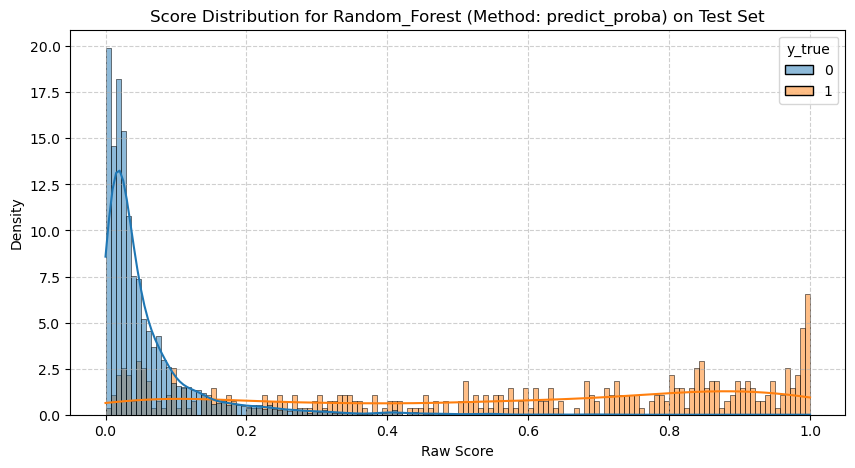


--- Analyzing scores for: SVM ---


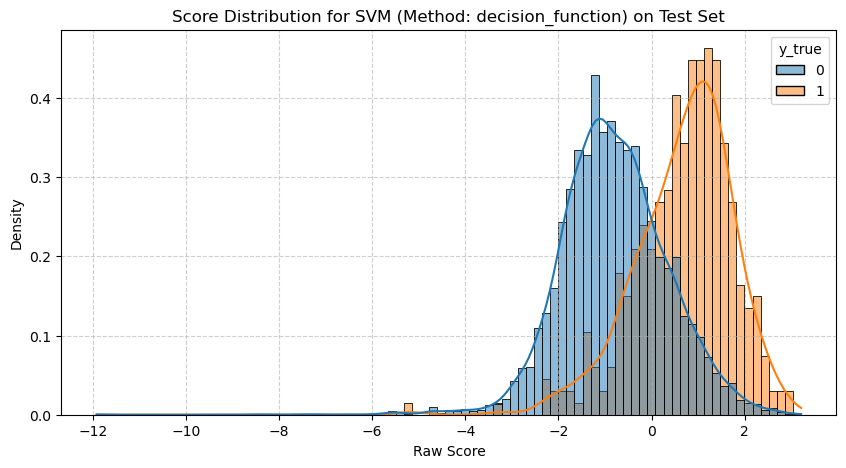


--- Analyzing scores for: XGBoost ---


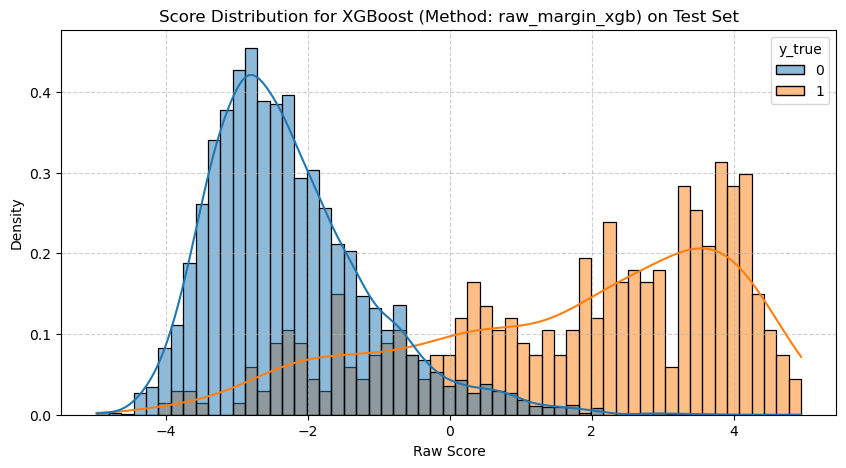

In [ ]:
# ==============================================================================
#           VISUALIZE SCORE DISTRIBUTIONS
# ==============================================================================
models_to_inspect = {
    "Random_Forest": 'predict_proba',
    "SVM": 'decision_function',
    "XGBoost": 'raw_margin_xgb'
}

for model_name, score_method in models_to_inspect.items():
    print(f"\n--- Analyzing scores for: {model_name} ---")

    # Load the pre-trained CVAP predictor
    cvap_predictor = load_predictor(MODEL_DIR, model_name, GROUP_NAME_TO_TEST, 'cvap')
    
    if cvap_predictor is None:
        print(f"Could not load CVAP predictor for {model_name}. Skipping.")
        continue

    # Get the final fitted base estimator
    estimator = cvap_predictor.final_estimator_
        
    # Use appropriate data (scaled for SVM)
    X_test_current = X_test_scaled if model_name == 'SVM' else X_test

    # Get raw scores for the test set
    try:
        raw_scores = cvap_predictor._get_raw_scores(X_test_current)
    except Exception as e:
        print(f"Error getting scores for {model_name}: {e}")
        continue

    # Create a plot
    plt.figure(figsize=(10, 5))
    plot_df = pd.DataFrame({'score': raw_scores, 'y_true': y_test})
    
    sns.histplot(data=plot_df, x='score', hue='y_true', kde=True, stat='density', common_norm=False)
    plt.title(f'Score Distribution for {model_name} (Method: {score_method}) on Test Set')
    plt.xlabel('Raw Score')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Of course! This is an excellent question, as understanding the difference is key to correctly interpreting your model's behavior.

The two methods you used—**Mean Decrease in Impurity (MDI)** for Random Forest and **Gain** for XGBoost—are both "in-built" importance types that are calculated during the model training process. Let's break them down.

---

### 1. Mean Decrease in Impurity (MDI) / Gini Importance

This is the method used by scikit-learn's `RandomForestClassifier`.

#### How It Works:
Imagine a single decision tree. At each node, the tree has to decide which feature to split on to best separate the data. The "best" split is the one that makes the resulting groups (child nodes) as "pure" as possible.

*   **Impurity:** A measure of how mixed the classes are in a node. The most common measure is the **Gini Impurity**.
    *   A perfectly pure node (all samples are class 0 or all are class 1) has a Gini impurity of 0.
    *   A node with a 50/50 split of classes has the maximum impurity.
*   **The Calculation:**
    1.  Whenever the tree splits on a feature, it calculates how much that split *reduced* the impurity. This reduction is the "impurity decrease."
    2.  For a single tree, the importance of a feature is the total impurity decrease it's responsible for, summed up over all the splits where it was used.
    3.  For a Random Forest, the final importance is the **average** of that feature's importance across all trees in the forest.

#### What It Represents:
**MDI tells you how effective a feature is at separating the data into purer groups *during the training process*.** A feature with a high MDI is one that the model frequently found useful for creating clean, decisive splits between stars and galaxies.

**Analogy:** Think of it as a "data sorter." A more important feature is a better sorter, consistently able to put stars in one bin and galaxies in another.

---

### 2. Gain (or "Split Importance")

This is the default importance type for XGBoost (`importance_type='gain'`).

#### How It Works:
XGBoost is a more advanced algorithm than a standard Random Forest. Instead of just minimizing impurity, it tries to minimize a more complex **objective function**. This function includes both a **loss component** (how wrong the model's predictions are) and a **regularization component** (which penalizes model complexity to prevent overfitting).

*   **Gain:** When XGBoost considers a split on a feature, "Gain" is the improvement (the reduction) in this overall objective function. It's not just about making the nodes purer; it's about making a split that contributes the most to the model's overall performance and generalization ability.

*   **The Calculation:**
    1.  For each split on a feature in a tree, the model calculates the "Gain."
    2.  The final importance of a feature is the **average Gain** of all splits that use that feature across all trees.

#### What It Represents:
**Gain tells you the relative contribution of a feature to the model's performance.** A feature with high Gain is one that, when used for a split, leads to the largest improvement in the model's objective function (i.e., it makes the model significantly better at its task).

**Analogy:** Think of it as a "performance booster." A feature with high gain gives the model the biggest "bang for its buck" in terms of improving its predictions.

---

### Comparison and Key Takeaways

| Feature                      | Mean Decrease in Impurity (Random Forest)                                | Gain (XGBoost)                                                              |
| ---------------------------- | ------------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| **Underlying Metric**        | Reduction in node impurity (e.g., Gini).                                 | Reduction in the model's loss/objective function.                           |
| **What It Tells You**        | How well a feature **separates the data** into homogeneous groups.       | How much a feature **contributes to the model's predictive performance**.     |
| **Primary Strength**         | Very fast to compute as it's a byproduct of training. Intuitive concept. | More robust than MDI as it's tied directly to the model's performance goals. |
| **Primary Weakness (Shared)** | **Bias towards high-cardinality features**. Both methods can inflate the importance of continuous features or categorical features with many levels, as they offer more potential split points. |
| **Context**                  | Measures importance on the **training data** only.                       | Measures importance on the **training data** only.                          |

### A Crucial Caveat: Permutation Importance

Both MDI and Gain are calculated on the **training set**. This can sometimes be misleading. A feature might be great at sorting the training data but not generalize well to new, unseen data.

A more robust, but computationally expensive, method is **Permutation Importance**.

*   **How it Works:**
    1.  Train a model and evaluate its performance (e.g., F1-score) on a held-out **test or validation set**.
    2.  Take one feature column in the test set and randomly **shuffle** it, breaking its relationship with the target.
    3.  Evaluate the model's performance again on this shuffled data.
    4.  The drop in performance is the "importance" of that feature. A big drop means the model relied heavily on it.

*   **What it Represents:**
    **Permutation importance directly measures how much the model's predictive accuracy on unseen data depends on a feature.**

**In summary:**

*   Use **MDI (Random Forest)** and **Gain (XGBoost)** for a **quick and insightful first look** at what the model learned from the training data. They are excellent for debugging and initial exploration.
*   If you need a more reliable and robust measure of how important features are for **real-world predictions**, use **Permutation Importance**.

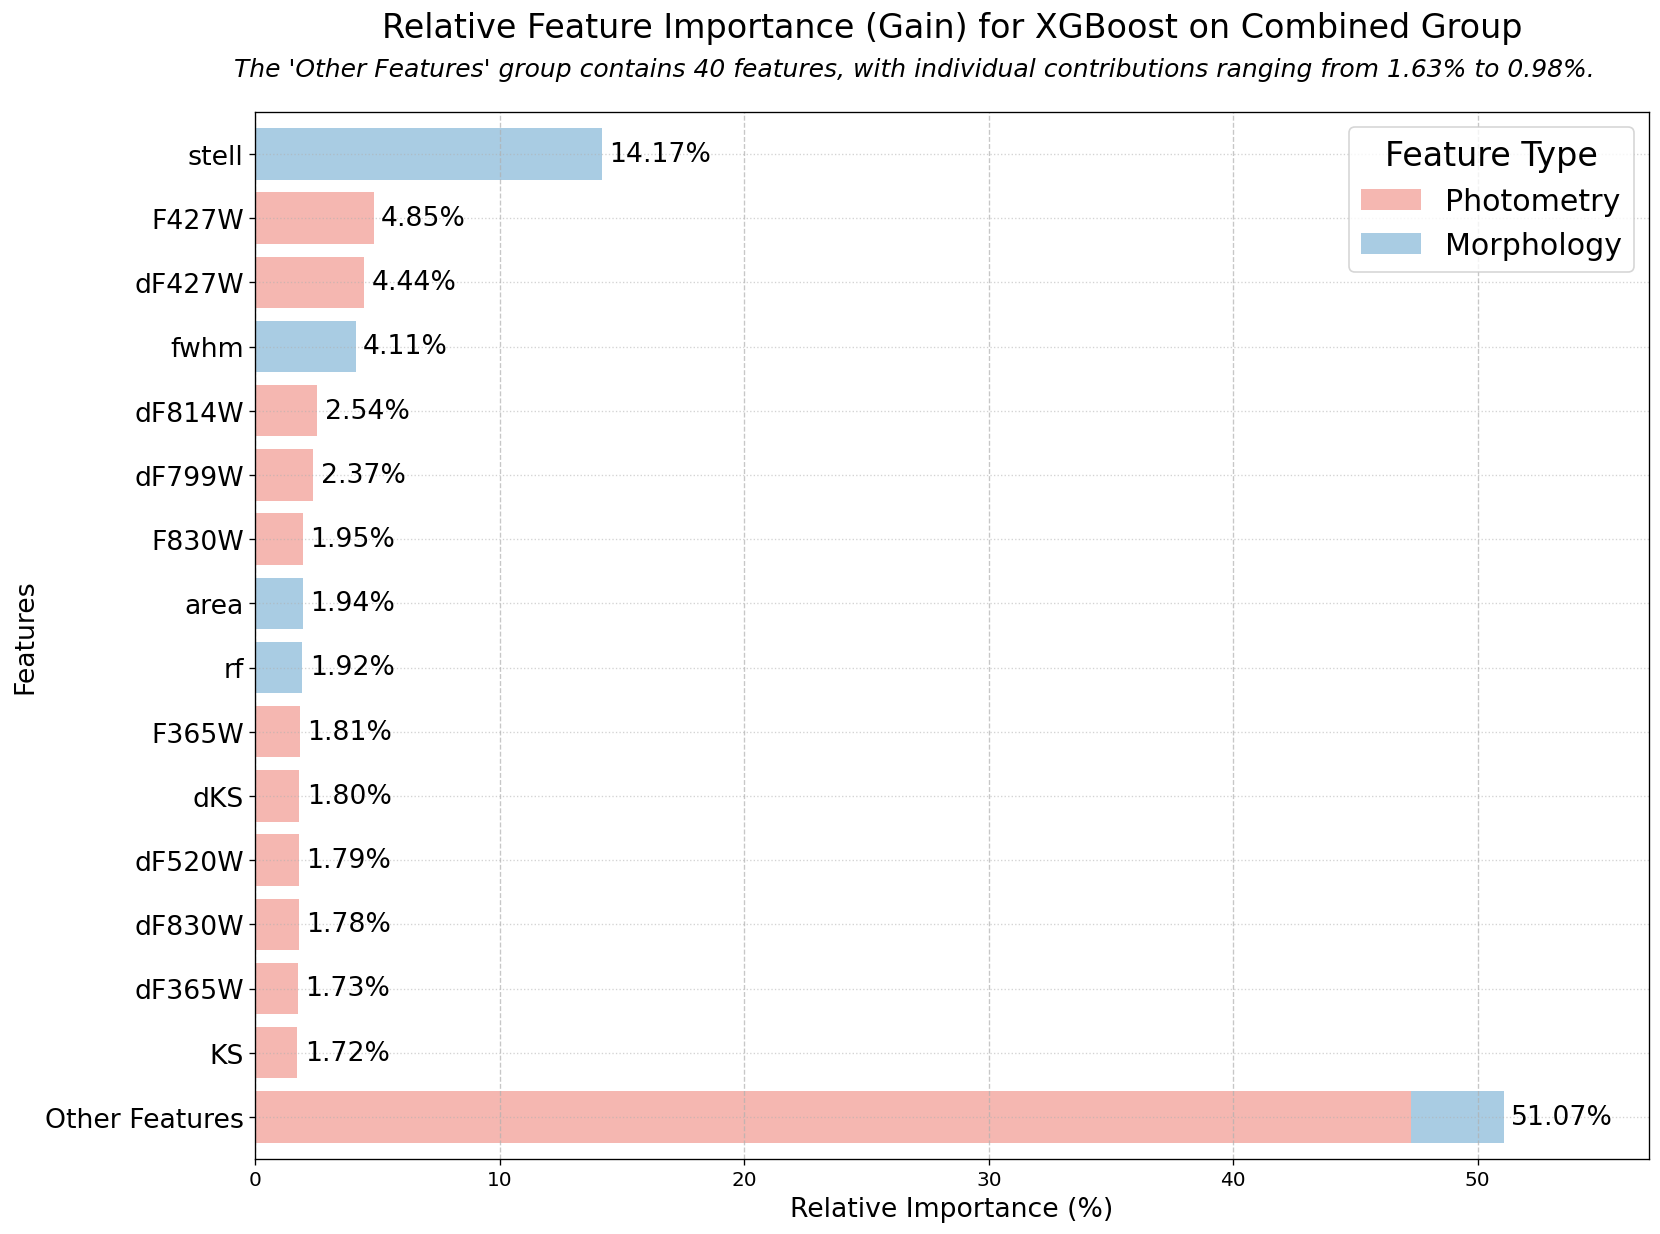

In [55]:
# ==============================================================================
#      FINAL, CORRECTED PUBLICATION-QUALITY FEATURE IMPORTANCE VISUALIZATION
# ------------------------------------------------------------------------------
# This definitive version creates a clear, aesthetically pleasing visualization.
# It correctly positions the 'Other Features' bar at the bottom, uses a stacked
# bar to show the composition of minor features, applies a pastel color palette,
# and adds a descriptive subtitle with corrected positioning.
# ==============================================================================

# --- 1. Imports and Setup ---
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', 'XGBoost models are not saved correctly')

# Define dummy classes to allow joblib to load custom objects
try:
    from raw_cvap import CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. Defining a dummy class to proceed.")
    class CVAPPredictorRaw: pass

# --- 2. Configuration ---
MODEL_DIR = "trained_models"
GROUP_NAME_TO_ANALYZE = 'group_3'
MODEL_NAME = 'XGBoost'
CALIBRATION_METHOD_TO_LOAD = 'cvap'
TOP_N_FEATURES = 15

# --- 3. Feature Definitions and Color Palette ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W'
] + [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH',
    'dKS', 'dF814W'
]
color_palette = {'Morphology': '#a9cce3', 'Photometry': '#f5b7b1'}

# --- 4. Load Model and Get Feature Names ---
try:
    full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    X_clean, _ = clean_data(full_df, GROUP_NAME_TO_ANALYZE, 'acs_mu_class')
    actual_feature_names = X_clean.columns.tolist()
except Exception as e:
    print(f"Could not load data to get feature names. Error: {e}")
    actual_feature_names = []

# --- 5. Load Model and Process Feature Importance ---
predictor_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_ANALYZE, f"{MODEL_NAME}_{GROUP_NAME_TO_ANALYZE}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
raw_xgb_model = None
if os.path.exists(predictor_path):
    try:
        calibrated_predictor = joblib.load(predictor_path)
        raw_xgb_model = calibrated_predictor.final_estimator_
    except Exception as e:
        print(f"ERROR: Failed to load model: {e}")

importance_range_str = ""
if raw_xgb_model and actual_feature_names:
    importance_dict = raw_xgb_model.get_booster().get_score(importance_type='gain')
    mapped_importance = {actual_feature_names[int(f.lstrip('f'))]: s for f, s in importance_dict.items()}

    importance_df = pd.DataFrame(list(mapped_importance.items()), columns=['Feature', 'Gain'])
    importance_df['Relative Importance (%)'] = (importance_df['Gain'] / importance_df['Gain'].sum()) * 100
    
    def get_feature_type(feature):
        if feature in morphology_features: return 'Morphology'
        if feature in photometry_mags_errors: return 'Photometry'
        return 'Other'
    importance_df['Type'] = importance_df['Feature'].apply(get_feature_type)
    importance_df = importance_df.sort_values(by='Relative Importance (%)', ascending=False)

    # --- 6. Prepare DataFrame for Plotting ---
    top_df = importance_df.head(TOP_N_FEATURES)
    others_df = importance_df.tail(-TOP_N_FEATURES)

    if not others_df.empty:
        min_imp = others_df['Relative Importance (%)'].min()
        max_imp = others_df['Relative Importance (%)'].max()
        importance_range_str = f"The 'Other Features' group contains {len(others_df)} features, with individual contributions ranging from {max_imp:.2f}% to {min_imp:.2f}%."

    plot_df_top = top_df.pivot_table(index='Feature', columns='Type', values='Relative Importance (%)', aggfunc='sum')
    others_summary = others_df.groupby('Type')['Relative Importance (%)'].sum()
    others_summary.name = 'Other Features'
    plot_df_final = pd.concat([plot_df_top, pd.DataFrame(others_summary).T]).fillna(0)

    for col in ['Morphology', 'Photometry']:
        if col not in plot_df_final.columns:
            plot_df_final[col] = 0.0

    plot_df_final['Total'] = plot_df_final[['Morphology', 'Photometry']].sum(axis=1)
    
    other_row = plot_df_final.loc[['Other Features']]
    top_features = plot_df_final.drop('Other Features')
    top_features_sorted = top_features.sort_values(by='Total', ascending=True)
    final_ordered_df = pd.concat([other_row, top_features_sorted])

    plot_df_for_plotting = final_ordered_df[['Photometry', 'Morphology']]

    # --- 7. Generate the Plot ---
    fig, ax = plt.subplots(figsize=(14, 11))
    
    plot_df_for_plotting.plot(
        kind='barh', stacked=True, color=color_palette, ax=ax, width=0.8
    )

    for i, total in enumerate(final_ordered_df['Total']):
        ax.text(total + 0.3, i, f'{total:.2f}%', va='center', fontsize=16)

    ax.set_title('Relative Feature Importance (Gain) for XGBoost on Combined Group', fontsize=20, pad=45)
    
    if importance_range_str:
        # *** CHANGE: Lowered the 'y' coordinate from 0.93 to 0.91 to increase space below the main title. ***
        fig.text(0.55, 0.89, importance_range_str, ha='center', va='center', fontsize=15, style='italic', color='black')
    
    ax.set_xlabel('Relative Importance (%)', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Feature Type', fontsize=18, title_fontsize=20, loc='upper right')
    
    ax.tick_params(axis='y', labelsize=16)
    ax.set_xlim(0, 57)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nCould not generate plot. Raw XGBoost model or feature names were not loaded correctly.")

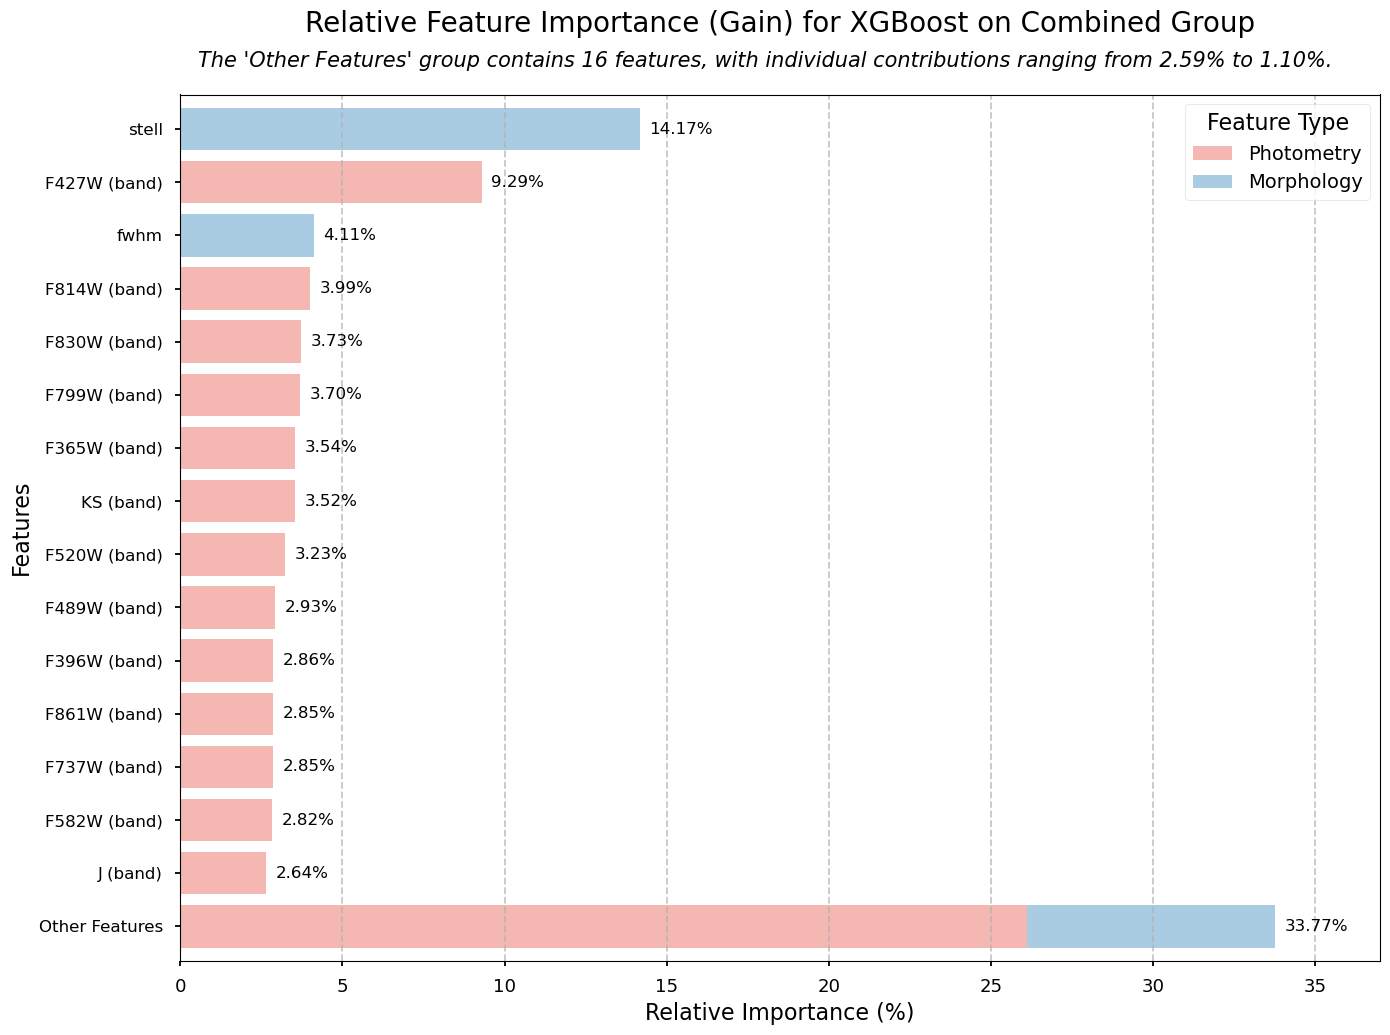

In [61]:
# ==============================================================================
#      FINAL, CORRECTED PUBLICATION-QUALITY FEATURE IMPORTANCE VISUALIZATION
# ------------------------------------------------------------------------------
# This definitive version creates a clear, aesthetically pleasing visualization.
# It correctly positions the 'Other Features' bar at the bottom, uses a stacked
# bar to show the composition of minor features, applies a pastel color palette,
# and adds a descriptive subtitle with corrected positioning.
#
# MODIFIED: It combines photometry magnitudes and their corresponding errors
# into single 'band' features by summing their importance values.
# ==============================================================================

# --- 1. Imports and Setup ---
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', 'XGBoost models are not saved correctly')

# Define dummy classes to allow joblib to load custom objects
try:
    from raw_cvap import CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. Defining a dummy class to proceed.")
    class CVAPPredictorRaw: pass

# --- 2. Configuration ---
MODEL_DIR = "trained_models"
GROUP_NAME_TO_ANALYZE = 'group_3'
MODEL_NAME = 'XGBoost'
CALIBRATION_METHOD_TO_LOAD = 'cvap'
TOP_N_FEATURES = 15

# --- 3. Feature Definitions and Color Palette ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
# The full list of photometric features, including magnitudes and errors
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W'
] + [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH',
    'dKS', 'dF814W'
]
color_palette = {'Morphology': '#a9cce3', 'Photometry': '#f5b7b1'}

# Helper lists for easy pairing of photometric features
photometry_magnitudes = [f for f in photometry_mags_errors if not f.startswith('d')]
photometry_uncertainties = [f for f in photometry_mags_errors if f.startswith('d')]


# --- 4. Load Model and Get Feature Names ---
try:
    full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    X_clean, _ = clean_data(full_df, GROUP_NAME_TO_ANALYZE, 'acs_mu_class')
    actual_feature_names = X_clean.columns.tolist()
except Exception as e:
    print(f"Could not load data to get feature names. Error: {e}")
    actual_feature_names = []

# --- 5. Load Model and Process Feature Importance ---
predictor_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_ANALYZE, f"{MODEL_NAME}_{GROUP_NAME_TO_ANALYZE}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
raw_xgb_model = None
if os.path.exists(predictor_path):
    try:
        calibrated_predictor = joblib.load(predictor_path)
        raw_xgb_model = calibrated_predictor.final_estimator_
    except Exception as e:
        print(f"ERROR: Failed to load model: {e}")

importance_range_str = ""
if raw_xgb_model and actual_feature_names:
    importance_dict = raw_xgb_model.get_booster().get_score(importance_type='gain')
    mapped_importance = {actual_feature_names[int(f.lstrip('f'))]: s for f, s in importance_dict.items()}

    importance_df = pd.DataFrame(list(mapped_importance.items()), columns=['Feature', 'Gain'])
    importance_df['Relative Importance (%)'] = (importance_df['Gain'] / importance_df['Gain'].sum()) * 100

    # *** START OF MODIFICATION ***
    # This section groups photometry magnitudes and their errors together.
    feature_map = {}
    photometry_magnitudes_set = set(photometry_magnitudes)

    # Create a mapping from individual feature names (e.g., 'F365W', 'dF365W')
    # to a grouped name (e.g., 'F365W (band)').
    for feature in importance_df['Feature']:
        if feature.startswith('d') and feature[1:] in photometry_magnitudes_set:
            base_name = feature[1:]
            feature_map[feature] = f"{base_name} (band)"
        elif feature in photometry_magnitudes_set and f"d{feature}" in photometry_uncertainties:
            feature_map[feature] = f"{feature} (band)"
        else:
            # Keep morphology and other non-paired features as they are.
            feature_map[feature] = feature

    importance_df['Grouped_Feature'] = importance_df['Feature'].map(feature_map)

    # Define feature types based on the original, ungrouped feature names.
    def get_feature_type(feature):
        if feature in morphology_features: return 'Morphology'
        if feature in photometry_mags_errors: return 'Photometry'
        return 'Other'
    importance_df['Type'] = importance_df['Feature'].apply(get_feature_type)

    # Aggregate the importances by summing the values for each group.
    aggregated_df = importance_df.groupby('Grouped_Feature').agg({
        'Gain': 'sum',
        'Relative Importance (%)': 'sum',
        'Type': 'first'  # The type will be the same for all parts of a group.
    }).reset_index()

    # Overwrite the original dataframe with the new, aggregated one.
    importance_df = aggregated_df.rename(columns={'Grouped_Feature': 'Feature'})
    # *** END OF MODIFICATION ***

    importance_df = importance_df.sort_values(by='Relative Importance (%)', ascending=False)

    # --- 6. Prepare DataFrame for Plotting ---
    top_df = importance_df.head(TOP_N_FEATURES)
    others_df = importance_df.tail(-TOP_N_FEATURES)

    if not others_df.empty:
        min_imp = others_df['Relative Importance (%)'].min()
        max_imp = others_df['Relative Importance (%)'].max()
        importance_range_str = f"The 'Other Features' group contains {len(others_df)} features, with individual contributions ranging from {max_imp:.2f}% to {min_imp:.2f}%."

    plot_df_top = top_df.pivot_table(index='Feature', columns='Type', values='Relative Importance (%)', aggfunc='sum')
    others_summary = others_df.groupby('Type')['Relative Importance (%)'].sum()
    others_summary.name = 'Other Features'
    plot_df_final = pd.concat([plot_df_top, pd.DataFrame(others_summary).T]).fillna(0)

    for col in ['Morphology', 'Photometry']:
        if col not in plot_df_final.columns:
            plot_df_final[col] = 0.0

    plot_df_final['Total'] = plot_df_final[['Morphology', 'Photometry']].sum(axis=1)

    other_row = plot_df_final.loc[['Other Features']]
    top_features = plot_df_final.drop('Other Features')
    top_features_sorted = top_features.sort_values(by='Total', ascending=True)
    final_ordered_df = pd.concat([other_row, top_features_sorted])

    plot_df_for_plotting = final_ordered_df[['Photometry', 'Morphology']]

    # --- 7. Generate the Plot ---
    fig, ax = plt.subplots(figsize=(14, 11))

    plot_df_for_plotting.plot(
        kind='barh', stacked=True, color=color_palette, ax=ax, width=0.8
    )

    for i, total in enumerate(final_ordered_df['Total']):
        ax.text(total + 0.3, i, f'{total:.2f}%', va='center', fontsize=12)

    ax.set_title('Relative Feature Importance (Gain) for XGBoost on Combined Group', fontsize=20, pad=45)

    if importance_range_str:
        # Corrected positioning for the subtitle.
        fig.text(0.55, 0.89, importance_range_str, ha='center', va='center', fontsize=15, style='italic', color='black')

    ax.set_xlabel('Relative Importance (%)', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Feature Type', fontsize=14, title_fontsize=16, loc='upper right')

    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim(0,37)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nCould not generate plot. Raw XGBoost model or feature names were not loaded correctly.")


Total Importance by Feature Type
- Morphology: 25.95%
- Photometry: 74.05%
--------------------------------------------------
Grand Total (check): 100.00%



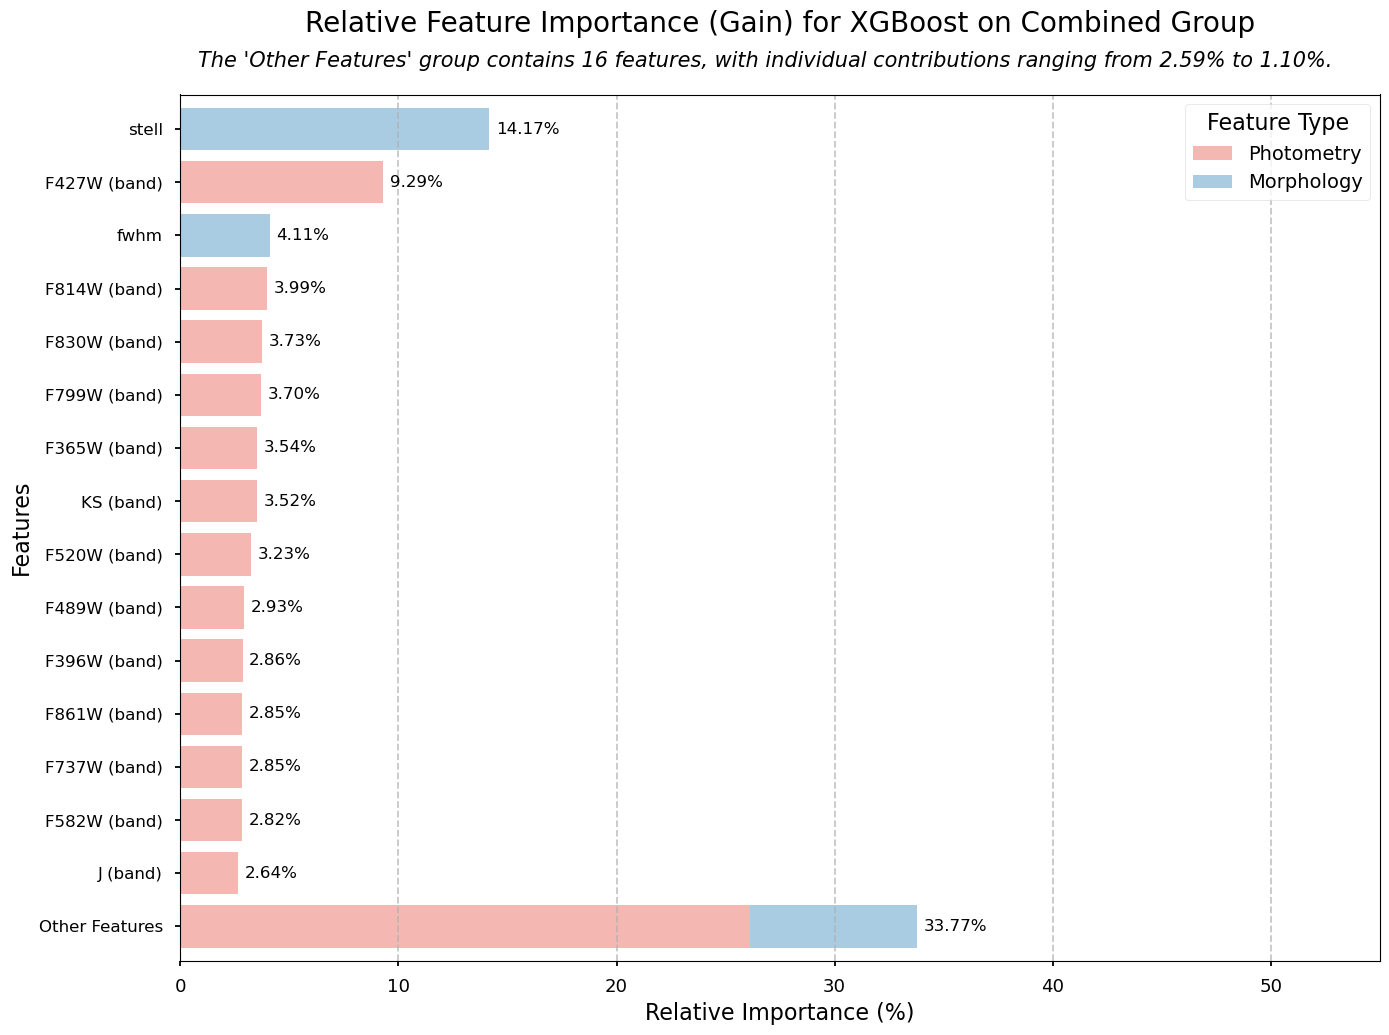

In [62]:
# ==============================================================================
#      FINAL, CORRECTED PUBLICATION-QUALITY FEATURE IMPORTANCE VISUALIZATION
# ------------------------------------------------------------------------------
# This definitive version creates a clear, aesthetically pleasing visualization.
# It correctly positions the 'Other Features' bar at the bottom, uses a stacked
# bar to show the composition of minor features, applies a pastel color palette,
# and adds a descriptive subtitle with corrected positioning.
#
# MODIFIED: It combines photometry magnitudes and their corresponding errors
# into single 'band' features by summing their importance values. It also now
# prints the total importance for each feature type.
# ==============================================================================

# --- 1. Imports and Setup ---
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', 'XGBoost models are not saved correctly')

# Define dummy classes to allow joblib to load custom objects
try:
    from raw_cvap import CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. Defining a dummy class to proceed.")
    class CVAPPredictorRaw: pass

# --- 2. Configuration ---
MODEL_DIR = "trained_models"
GROUP_NAME_TO_ANALYZE = 'group_3'
MODEL_NAME = 'XGBoost'
CALIBRATION_METHOD_TO_LOAD = 'cvap'
TOP_N_FEATURES = 15

# --- 3. Feature Definitions and Color Palette ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
# The full list of photometric features, including magnitudes and errors
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W'
] + [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH',
    'dKS', 'dF814W'
]
color_palette = {'Morphology': '#a9cce3', 'Photometry': '#f5b7b1'}

# Helper lists for easy pairing of photometric features
photometry_magnitudes = [f for f in photometry_mags_errors if not f.startswith('d')]
photometry_uncertainties = [f for f in photometry_mags_errors if f.startswith('d')]


# --- 4. Load Model and Get Feature Names ---
try:
    full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    X_clean, _ = clean_data(full_df, GROUP_NAME_TO_ANALYZE, 'acs_mu_class')
    actual_feature_names = X_clean.columns.tolist()
except Exception as e:
    print(f"Could not load data to get feature names. Error: {e}")
    actual_feature_names = []

# --- 5. Load Model and Process Feature Importance ---
predictor_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_ANALYZE, f"{MODEL_NAME}_{GROUP_NAME_TO_ANALYZE}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
raw_xgb_model = None
if os.path.exists(predictor_path):
    try:
        calibrated_predictor = joblib.load(predictor_path)
        raw_xgb_model = calibrated_predictor.final_estimator_
    except Exception as e:
        print(f"ERROR: Failed to load model: {e}")

importance_range_str = ""
if raw_xgb_model and actual_feature_names:
    importance_dict = raw_xgb_model.get_booster().get_score(importance_type='gain')
    mapped_importance = {actual_feature_names[int(f.lstrip('f'))]: s for f, s in importance_dict.items()}

    importance_df = pd.DataFrame(list(mapped_importance.items()), columns=['Feature', 'Gain'])
    importance_df['Relative Importance (%)'] = (importance_df['Gain'] / importance_df['Gain'].sum()) * 100

    # Group photometry magnitudes and their errors together.
    feature_map = {}
    photometry_magnitudes_set = set(photometry_magnitudes)
    for feature in importance_df['Feature']:
        if feature.startswith('d') and feature[1:] in photometry_magnitudes_set:
            base_name = feature[1:]
            feature_map[feature] = f"{base_name} (band)"
        elif feature in photometry_magnitudes_set and f"d{feature}" in photometry_uncertainties:
            feature_map[feature] = f"{feature} (band)"
        else:
            feature_map[feature] = feature

    importance_df['Grouped_Feature'] = importance_df['Feature'].map(feature_map)

    def get_feature_type(feature):
        if feature in morphology_features: return 'Morphology'
        if feature in photometry_mags_errors: return 'Photometry'
        return 'Other'
    importance_df['Type'] = importance_df['Feature'].apply(get_feature_type)

    aggregated_df = importance_df.groupby('Grouped_Feature').agg({
        'Gain': 'sum',
        'Relative Importance (%)': 'sum',
        'Type': 'first'
    }).reset_index()

    importance_df = aggregated_df.rename(columns={'Grouped_Feature': 'Feature'})
    importance_df = importance_df.sort_values(by='Relative Importance (%)', ascending=False)
    
    # *** NEWLY ADDED CODE BLOCK ***
    # Calculate and print the total importance contribution of each feature type.
    total_importance_by_type = importance_df.groupby('Type')['Relative Importance (%)'].sum()
    print("\n" + "="*50)
    print("Total Importance by Feature Type")
    print("="*50)
    if not total_importance_by_type.empty:
        for feature_type, total_importance in total_importance_by_type.items():
            print(f"- {feature_type}: {total_importance:.2f}%")
        print("-" * 50)
        print(f"Grand Total (check): {total_importance_by_type.sum():.2f}%")
    else:
        print("Could not calculate total importance.")
    print("="*50 + "\n")
    # *** END OF NEWLY ADDED CODE BLOCK ***


    # --- 6. Prepare DataFrame for Plotting ---
    top_df = importance_df.head(TOP_N_FEATURES)
    others_df = importance_df.tail(-TOP_N_FEATURES)

    if not others_df.empty:
        min_imp = others_df['Relative Importance (%)'].min()
        max_imp = others_df['Relative Importance (%)'].max()
        importance_range_str = f"The 'Other Features' group contains {len(others_df)} features, with individual contributions ranging from {max_imp:.2f}% to {min_imp:.2f}%."

    plot_df_top = top_df.pivot_table(index='Feature', columns='Type', values='Relative Importance (%)', aggfunc='sum')
    others_summary = others_df.groupby('Type')['Relative Importance (%)'].sum()
    others_summary.name = 'Other Features'
    plot_df_final = pd.concat([plot_df_top, pd.DataFrame(others_summary).T]).fillna(0)

    for col in ['Morphology', 'Photometry']:
        if col not in plot_df_final.columns:
            plot_df_final[col] = 0.0

    plot_df_final['Total'] = plot_df_final[['Morphology', 'Photometry']].sum(axis=1)

    other_row = plot_df_final.loc[['Other Features']]
    top_features = plot_df_final.drop('Other Features')
    top_features_sorted = top_features.sort_values(by='Total', ascending=True)
    final_ordered_df = pd.concat([other_row, top_features_sorted])

    plot_df_for_plotting = final_ordered_df[['Photometry', 'Morphology']]

    # --- 7. Generate the Plot ---
    fig, ax = plt.subplots(figsize=(14, 11))

    plot_df_for_plotting.plot(
        kind='barh', stacked=True, color=color_palette, ax=ax, width=0.8
    )

    for i, total in enumerate(final_ordered_df['Total']):
        ax.text(total + 0.3, i, f'{total:.2f}%', va='center', fontsize=12)

    ax.set_title('Relative Feature Importance (Gain) for XGBoost on Combined Group', fontsize=20, pad=45)

    if importance_range_str:
        # Corrected positioning for the subtitle.
        fig.text(0.55, 0.89, importance_range_str, ha='center', va='center', fontsize=15, style='italic', color='black')

    ax.set_xlabel('Relative Importance (%)', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Feature Type', fontsize=14, title_fontsize=16, loc='upper right')

    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim(0, 55)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nCould not generate plot. Raw XGBoost model or feature names were not loaded correctly.")

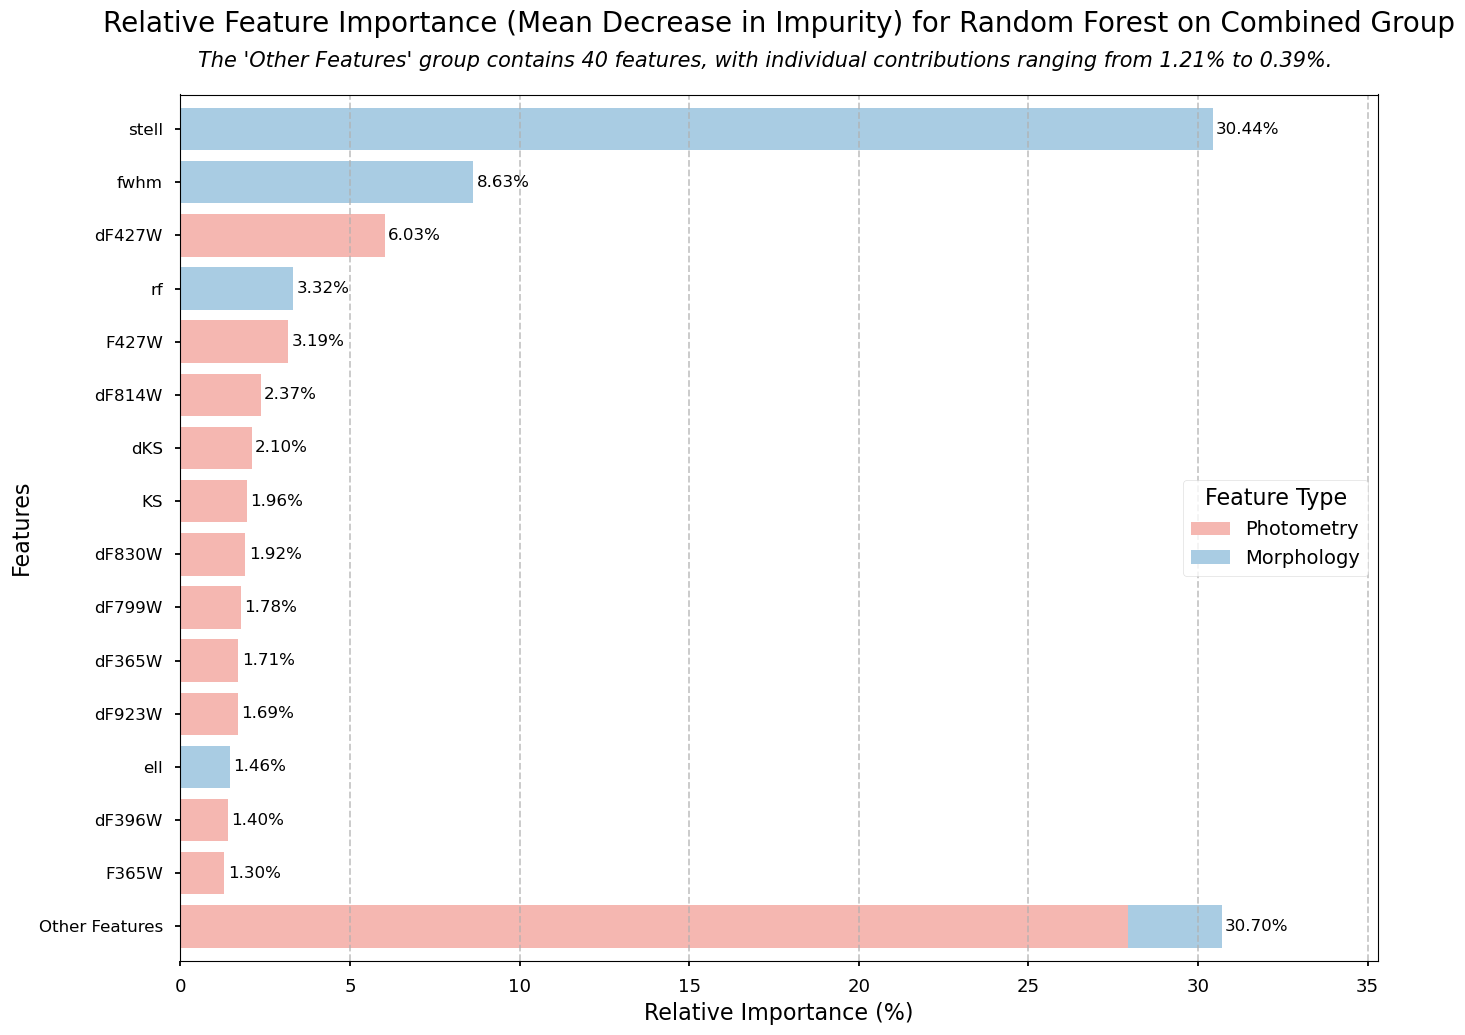

In [37]:
# ==============================================================================
#      PUBLICATION-QUALITY FEATURE IMPORTANCE VISUALIZATION FOR RANDOM FOREST
# ------------------------------------------------------------------------------
# This cell creates a visualization for Random Forest feature importance,
# mirroring the style of the XGBoost plot. It uses Mean Decrease in Impurity
# as the importance metric and correctly positions the 'Other Features' bar
# at the bottom for a clear and professional presentation.
# ==============================================================================

# --- 1. Imports and Setup ---
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# Define dummy classes to allow joblib to load custom objects from your workflow
try:
    from raw_cvap import CVAPPredictorRaw
except ImportError:
    print("Warning: 'raw_cvap.py' not found. Defining a dummy class to proceed.")
    class CVAPPredictorRaw: pass

# --- 2. Configuration ---
MODEL_DIR = "trained_models"
GROUP_NAME_TO_ANALYZE = 'group_3'
MODEL_NAME = 'Random_Forest' # <-- Changed to Random Forest
CALIBRATION_METHOD_TO_LOAD = 'cvap'
TOP_N_FEATURES = 15

# --- 3. Feature Definitions and Color Palette ---
morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
photometry_mags_errors = [
    'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
    'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
    'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W'
] + [
    'dF365W', 'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W',
    'dF582W', 'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W',
    'dF799W', 'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH',
    'dKS', 'dF814W'
]
color_palette = {'Morphology': '#a9cce3', 'Photometry': '#f5b7b1'}

# --- 4. Load Data and Get Feature Names ---
# Self-contained helper function to get data
def clean_data(df, feature_group, target_column):
    groups = {
        'group_3': morphology_features + photometry_mags_errors + [target_column]
    }
    available_cols = [col for col in groups[feature_group] if col in df.columns]
    df_clean = df[available_cols].dropna().copy()
    X = df_clean.drop(columns=[target_column])
    return X, df_clean[target_column]

try:
    full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    X_clean, _ = clean_data(full_df, GROUP_NAME_TO_ANALYZE, 'acs_mu_class')
    actual_feature_names = X_clean.columns.tolist()
except Exception as e:
    print(f"Could not load data to get feature names. Error: {e}")
    actual_feature_names = []

# --- 5. Load Model and Process Feature Importance ---
predictor_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_ANALYZE, f"{MODEL_NAME}_{GROUP_NAME_TO_ANALYZE}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
raw_rf_model = None
if os.path.exists(predictor_path):
    try:
        calibrated_predictor = joblib.load(predictor_path)
        raw_rf_model = calibrated_predictor.final_estimator_
    except Exception as e:
        print(f"ERROR: Failed to load model: {e}")

importance_range_str = ""
if raw_rf_model and actual_feature_names:
    # --- GET FEATURE IMPORTANCE FOR RANDOM FOREST ---
    importances = raw_rf_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': actual_feature_names,
        'Importance': importances
    })
    importance_df['Relative Importance (%)'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
    
    def get_feature_type(feature):
        if feature in morphology_features: return 'Morphology'
        if feature in photometry_mags_errors: return 'Photometry'
        return 'Other'
    importance_df['Type'] = importance_df['Feature'].apply(get_feature_type)
    importance_df = importance_df.sort_values(by='Relative Importance (%)', ascending=False)

    # --- 6. Prepare DataFrame for Plotting (identical logic to XGBoost) ---
    top_df = importance_df.head(TOP_N_FEATURES)
    others_df = importance_df.tail(-TOP_N_FEATURES)

    if not others_df.empty:
        min_imp = others_df['Relative Importance (%)'].min()
        max_imp = others_df['Relative Importance (%)'].max()
        importance_range_str = f"The 'Other Features' group contains {len(others_df)} features, with individual contributions ranging from {max_imp:.2f}% to {min_imp:.2f}%."

    plot_df_top = top_df.pivot_table(index='Feature', columns='Type', values='Relative Importance (%)', aggfunc='sum')
    others_summary = others_df.groupby('Type')['Relative Importance (%)'].sum()
    others_summary.name = 'Other Features'
    plot_df_final = pd.concat([plot_df_top, pd.DataFrame(others_summary).T]).fillna(0)

    for col in ['Morphology', 'Photometry']:
        if col not in plot_df_final.columns:
            plot_df_final[col] = 0.0

    plot_df_final['Total'] = plot_df_final[['Morphology', 'Photometry']].sum(axis=1)
    
    other_row = plot_df_final.loc[['Other Features']]
    top_features = plot_df_final.drop('Other Features')
    top_features_sorted = top_features.sort_values(by='Total', ascending=True)
    final_ordered_df = pd.concat([other_row, top_features_sorted])

    plot_df_for_plotting = final_ordered_df[['Photometry', 'Morphology']]

    # --- 7. Generate the Plot ---
    fig, ax = plt.subplots(figsize=(14, 11))
    
    plot_df_for_plotting.plot(
        kind='barh', stacked=True, color=color_palette, ax=ax, width=0.8
    )

    for i, total in enumerate(final_ordered_df['Total']):
        ax.text(total + 0.1, i, f'{total:.2f}%', va='center', fontsize=12)

    ax.set_title('Relative Feature Importance (Mean Decrease in Impurity) for Random Forest on Combined Group', fontsize=20, pad=45)
    
    if importance_range_str:
        fig.text(0.55, 0.89, importance_range_str, ha='center', va='center', fontsize=15, style='italic', color='black')
    
    ax.set_xlabel('Relative Importance (%)', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    # Adjust legend location if necessary; 'lower right' often works well for this plot type
    ax.legend(handles, labels, title='Feature Type', fontsize=14, title_fontsize=16, loc='right')
    
    ax.tick_params(axis='y', labelsize=12)
    # Dynamically set the x-axis limit to fit the data
    ax.set_xlim(0, final_ordered_df['Total'].max() * 1.15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("\nCould not generate plot. Raw Random Forest model or feature names were not loaded correctly.")

--- Configuration ---
Group: group_3
Model: XGBoost
Calibrator: cvapplatt
-------------------------
Loading and preparing data...
Test set created with shape: (5478, 55)

Loading model and making predictions...
Successfully loaded model from: trained_models\group_3\XGBoost_group_3_cvapplatt.joblib
Using optimal threshold: 0.4700

Binning data by F814W magnitude and calculating performance...
Performance calculation complete.


C:\Users\javym\AppData\Local\Temp\ipykernel_8128\2882953195.py:166: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_by_mag = results_df.groupby('mag_bin').apply(calculate_tpr_tnr).reset_index()


,mag_bin,tpr,tnr,count,mag_center
0,0,0.9832,0.9911,457.0000,20.3148
1,1,0.9697,0.9929,456.0000,22.0025
2,2,0.8286,0.9976,457.0000,22.6633
3,3,0.7576,0.9929,458.0000,23.1337
4,4,0.7727,0.9954,457.0000,23.4717
5,5,0.6500,0.9977,455.0000,23.7548
6,6,0.3043,0.9954,456.0000,24.0191
7,7,0.3684,0.9977,456.0000,24.2497
8,8,0.0952,1.0000,459.0000,24.4885
9,9,0.2941,0.9908,454.0000,24.7455



Generating plot...


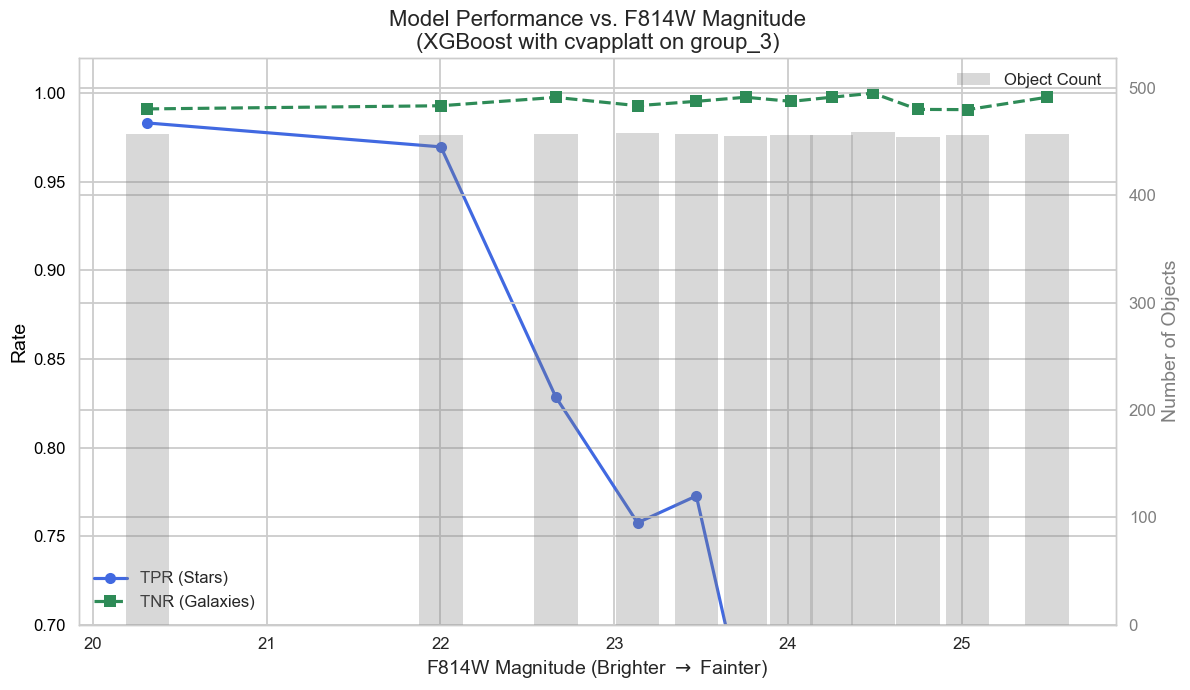

In [64]:
# ==============================================================================
#           PERFORMANCE VS. MAGNITUDE (TPR/TNR vs. F814W)
# ------------------------------------------------------------------------------
# This cell generates a plot to visualize model performance as a function of
# the F814W magnitude. It calculates the True Positive Rate (TPR) and True
# Negative Rate (TNR) in different magnitude bins for a specified model.
#
# - X-axis: F814W Magnitude
# - Y-axis (left): TPR and TNR
# - Y-axis (right): Number of objects per bin
#
# This analysis helps to understand if the model's ability to correctly
# classify stars (TPR) and galaxies (TNR) changes for brighter or fainter objects.
# ==============================================================================

# --- 1. Imports and Configuration ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from IPython.display import display

# Import necessary classes and functions from the notebook environment
# (These would typically be defined in previous cells)
try:
    from cvap_platt import fit_cvap_platt
    from raw_cvap import RawVennAbers, CVAPPredictorRaw
except ImportError:
    print("Warning: 'cvap_platt.py' or 'raw_cvap.py' not found. This cell might fail to load models.")
    # Define dummy classes to avoid immediate NameError
    class CVAPPredictorRaw: pass
    class RawVennAbers: pass
    def fit_cvap_platt(*args, **kwargs): return None

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- Configuration for the plot ---
GROUP_NAME_TO_PLOT = 'group_3'
MODEL_NAME_TO_PLOT = 'XGBoost'
CALIBRATION_METHOD_TO_LOAD = 'cvapplatt' # We want to evaluate the CVAP-Platt model

MODEL_DIR = "trained_models"
TARGET_COLUMN = 'acs_mu_class'
RANDOM_SEED = 33

print(f"--- Configuration ---")
print(f"Group: {GROUP_NAME_TO_PLOT}")
print(f"Model: {MODEL_NAME_TO_PLOT}")
print(f"Calibrator: {CALIBRATION_METHOD_TO_LOAD}")
print("-" * 25)


# --- 2. Data Preparation ---
# This section re-creates the necessary data splits to ensure we use the correct test set.
# It should be consistent with the main notebook's data preparation.
print("Loading and preparing data...")
try:
    # Feature set definitions
    morphology_features = ['area', 'fwhm', 'stell', 'ell', 'rk', 'rf', 's2n']
    photometry_mags_errors = [
        'F365W', 'F396W', 'F427W', 'F458W', 'F489W', 'F520W', 'F551W', 'F582W',
        'F613W', 'F644W', 'F675W', 'F706W', 'F737W', 'F768W', 'F799W', 'F830W',
        'F861W', 'F892W', 'F923W', 'F954W', 'J', 'H', 'KS', 'F814W', 'dF365W',
        'dF396W', 'dF427W', 'dF458W', 'dF489W', 'dF520W', 'dF551W', 'dF582W',
        'dF613W', 'dF644W', 'dF675W', 'dF706W', 'dF737W', 'dF768W', 'dF799W',
        'dF830W', 'dF861W', 'dF892W', 'dF923W', 'dF954W', 'dJ', 'dH', 'dKS', 'dF814W'
    ]
    groups = {
        'group_1': morphology_features + [TARGET_COLUMN],
        'group_2': photometry_mags_errors + [TARGET_COLUMN],
        'group_3': morphology_features + photometry_mags_errors + [TARGET_COLUMN]
    }
    
    # Load and clean the full dataset
    full_df = pd.read_csv('data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv')
    full_df = full_df[full_df['acs_mu_class'] != 3]
    full_df['acs_mu_class'] = full_df['acs_mu_class'].map({1: 0, 2: 1})

    # Get features and target for the specified group
    df_clean = full_df[groups[GROUP_NAME_TO_PLOT]].dropna().copy()
    X = df_clean.drop(columns=[TARGET_COLUMN])
    y = df_clean[TARGET_COLUMN]

    # Re-create the exact train/validation/test split
    TEST_SIZE, VAL_SIZE = 0.20, 0.20
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )
    print(f"Test set created with shape: {X_test.shape}")

except FileNotFoundError:
    print("ERROR: Data file not found. Please ensure 'data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv' exists.")
    # Create dummy data to prevent the rest of the cell from crashing
    X_test, y_test = pd.DataFrame(), pd.Series()
except Exception as e:
    print(f"An error occurred during data preparation: {e}")
    X_test, y_test = pd.DataFrame(), pd.Series()


# --- 3. Load Model and Make Predictions ---
print("\nLoading model and making predictions...")
model_loaded = False
if not X_test.empty:
    try:
        # Construct the path to the cached CVAP-Platt model
        model_path = os.path.join(MODEL_DIR, GROUP_NAME_TO_PLOT, f"{MODEL_NAME_TO_PLOT}_{GROUP_NAME_TO_PLOT}_{CALIBRATION_METHOD_TO_LOAD}.joblib")
        
        # Load the dictionary containing the model and the optimal threshold
        cached_data = joblib.load(model_path)
        calibrated_model = cached_data['model']
        optimal_threshold = cached_data['optimal_threshold']
        
        print(f"Successfully loaded model from: {model_path}")
        print(f"Using optimal threshold: {optimal_threshold:.4f}")

        # Make predictions on the test set
        y_proba_test = calibrated_model.predict_proba(X_test)[:, 1]
        y_pred_test = (y_proba_test >= optimal_threshold).astype(int)
        model_loaded = True

    except FileNotFoundError:
        print(f"ERROR: Model file not found at '{model_path}'. Cannot proceed.")
    except Exception as e:
        print(f"An error occurred while loading the model or making predictions: {e}")
else:
    print("Skipping model loading due to data preparation error.")


# --- 4. Bin Data and Calculate Metrics ---
if model_loaded:
    print("\nBinning data by F814W magnitude and calculating performance...")
    
    # Create a results DataFrame
    results_df = pd.DataFrame({
        'F814W': X_test['F814W'],
        'y_true': y_test,
        'y_pred': y_pred_test
    })

    # Define bins using quantiles to ensure a similar number of objects per bin
    try:
        results_df['mag_bin'] = pd.qcut(results_df['F814W'], q=12, labels=False, duplicates='drop')
    except ValueError as e:
        print(f"Warning: Could not create 12 quantile bins, likely due to data distribution. Using 5 bins. Error: {e}")
        results_df['mag_bin'] = pd.qcut(results_df['F814W'], q=5, labels=False, duplicates='drop')


    # Function to calculate TPR and TNR for each group
    def calculate_tpr_tnr(group):
        cm = confusion_matrix(group['y_true'], group['y_pred'], labels=[0, 1]).ravel()
        tn, fp, fn, tp = cm
        
        # TPR (Recall or Sensitivity) for the positive class (Stars, label 1)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        # TNR (Specificity) for the negative class (Galaxies, label 0)
        tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        
        return pd.Series({'tpr': tpr, 'tnr': tnr, 'count': len(group)})

    # Group by magnitude bin and calculate metrics
    perf_by_mag = results_df.groupby('mag_bin').apply(calculate_tpr_tnr).reset_index()
    
    # Get the center of each magnitude bin for plotting
    bin_centers = results_df.groupby('mag_bin')['F814W'].mean()
    perf_by_mag = perf_by_mag.join(bin_centers.rename('mag_center'), on='mag_bin')

    print("Performance calculation complete.")
    display(perf_by_mag)


    # --- 5. Plotting ---
    print("\nGenerating plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot TPR and TNR on the primary y-axis
    ax1.plot(perf_by_mag['mag_center'], perf_by_mag['tpr'], 'o-', color='royalblue', label='TPR (Stars)', markersize=8)
    ax1.plot(perf_by_mag['mag_center'], perf_by_mag['tnr'], 's--', color='seagreen', label='TNR (Galaxies)', markersize=8)
    
    ax1.set_xlabel('F814W Magnitude (Brighter $\\rightarrow$ Fainter)', fontsize=14)
    ax1.set_ylabel('Rate', fontsize=14, color='black')
    ax1.tick_params(axis='y', labelcolor='black', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylim(0.7, 1.02)
    ax1.legend(loc='lower left', fontsize=12)

    # Create a secondary y-axis for the object counts
    ax2 = ax1.twinx()
    ax2.bar(perf_by_mag['mag_center'], perf_by_mag['count'], width=0.25, color='gray', alpha=0.3, label='Object Count')
    ax2.set_ylabel('Number of Objects', fontsize=14, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray', labelsize=12)
    ax2.set_ylim(0, perf_by_mag['count'].max() * 1.15)
    ax2.legend(loc='upper right', fontsize=12)

    # Final plot adjustments
    plt.title(f'Model Performance vs. F814W Magnitude\n({MODEL_NAME_TO_PLOT} with {CALIBRATION_METHOD_TO_LOAD} on {GROUP_NAME_TO_PLOT})', fontsize=16)
    fig.tight_layout()
    plt.show()

Filtered test sample: 956 objects


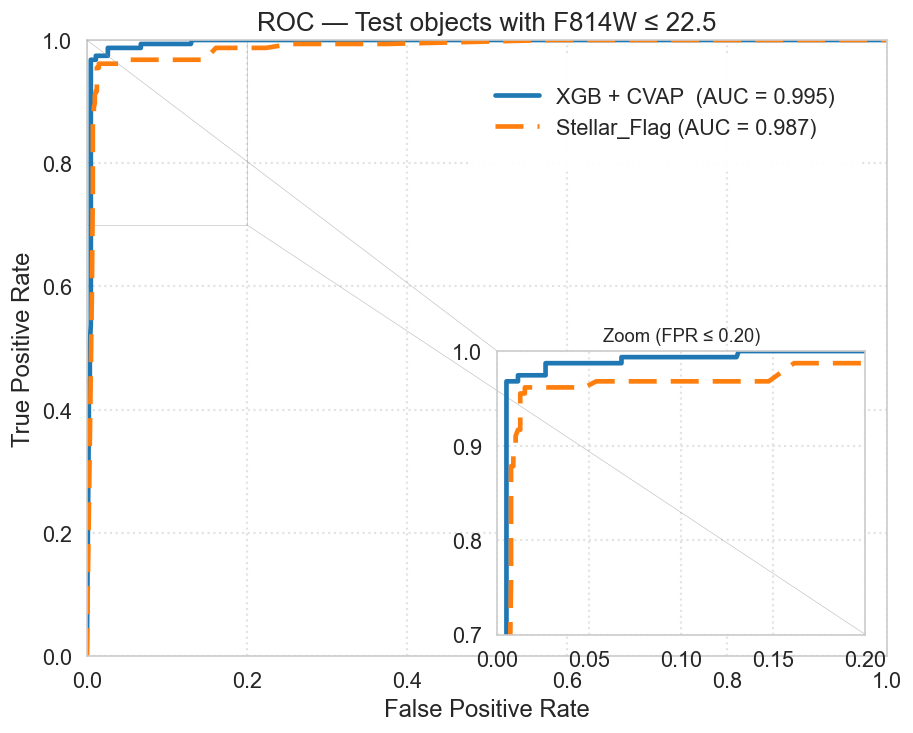

In [68]:
# ==============================================================
#  Pretty ROC – legend inside, cleaner styling
# ==============================================================

import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# --------------------------------------------------
# 1) Reload catalogue & recreate the split
# --------------------------------------------------
CSV_PATH = 'data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv'
df = pd.read_csv(CSV_PATH)

df = df[df['acs_mu_class'] != 3]
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

morphology_features   = ['area','fwhm','stell','ell','rk','rf']
morphology_err        = ['s2n']
OPTICAL_MAG_COLS      = [f'F{w}W' for w in
                         ['365','396','427','458','489','520','551','582','613',
                          '644','675','706','737','768','799','830','861','892',
                          '923','954']]
phot_mag  = OPTICAL_MAG_COLS + ['J','H','KS','F814W']
phot_err  = [f'd{x}' for x in OPTICAL_MAG_COLS] + ['dJ','dH','dKS','dF814W']
GROUP3    = morphology_features + morphology_err + phot_mag + phot_err

TARGET_COL = 'acs_mu_class'

df_clean = df[GROUP3 + [TARGET_COL, 'Stellar_Flag']].dropna().copy()
X_full   = df_clean[GROUP3]
y_full   = df_clean[TARGET_COL]

TEST_SIZE, VAL_SIZE, SEED = 0.20, 0.20, 33
X_train, X_tmp, y_train, y_tmp, df_train, df_tmp = train_test_split(
    X_full, y_full, df_clean, test_size=TEST_SIZE+VAL_SIZE,
    stratify=y_full, random_state=SEED
)
X_val, X_test, y_val, y_test, df_val, df_test = train_test_split(
    X_tmp, y_tmp, df_tmp,
    test_size=TEST_SIZE/(TEST_SIZE+VAL_SIZE), stratify=y_tmp, random_state=SEED
)

# --------------------------------------------------
# 2) Filter on F814W ≤ 22.5
# --------------------------------------------------
mask          = df_test['F814W'] <= 22.5
X_test_filt   = X_test.loc[mask]
y_test_filt   = y_test.loc[mask]
df_test_filt  = df_test.loc[mask]

print(f"Filtered test sample: {len(y_test_filt)} objects")

# --------------------------------------------------
# 3) Load calibrated XGB model & baseline
# --------------------------------------------------
MODEL_PATH = os.path.join('trained_models','group_3','XGBoost_group_3_cvap.joblib')
xgb_cvap    = joblib.load(MODEL_PATH)

proba_xgb   = xgb_cvap.predict_proba(X_test_filt)[:,1]
proba_flag  = df_test_filt['Stellar_Flag'].astype(float)

# --------------------------------------------------
# 4) Metrics
# --------------------------------------------------
fpr_xgb,  tpr_xgb,  _ = roc_curve(y_test_filt, proba_xgb)
fpr_flag, tpr_flag, _ = roc_curve(y_test_filt, proba_flag)

auc_xgb  = auc(fpr_xgb,  tpr_xgb)
auc_flag = auc(fpr_flag, tpr_flag)

# --------------------------------------------------
# 5) Plot with cleaner aesthetics
# --------------------------------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size" : 13,
    "axes.grid" : True,
    "grid.linestyle" : ":",
    "grid.alpha" : 0.55,
})

fig, ax = plt.subplots(figsize=(7.5, 6), constrained_layout=True)

# main ROC curves
ax.plot(fpr_xgb,  tpr_xgb,  lw=2.8, label=f'XGB + CVAP  (AUC = {auc_xgb:.3f})')
ax.plot(fpr_flag, tpr_flag, lw=2.8, label=f'Stellar_Flag (AUC = {auc_flag:.3f})',
        linestyle='--', dashes=(6,3))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC — Test objects with F814W ≤ 22.5')
ax.set_xlim(0, 1.0); ax.set_ylim(0, 1.0)

# inset zoom
ax_ins = inset_axes(ax, width="46%", height="46%", loc='lower right',
                    bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes,
                    borderpad=1)
ax_ins.plot(fpr_xgb,  tpr_xgb,  lw=2.8)
ax_ins.plot(fpr_flag, tpr_flag, lw=2.8, linestyle='--', dashes=(6,3))
ax_ins.set_xlim(0, 0.20);  ax_ins.set_ylim(0.70, 1.0)
ax_ins.set_xticks(np.linspace(0,0.20,5));  ax_ins.set_yticks(np.linspace(0.70,1.0,4))
ax_ins.set_title('Zoom (FPR ≤ 0.20)', fontsize=11)
mark_inset(ax, ax_ins, loc1=2, loc2=4, fc="none", ec="0.6", alpha=0.6)

# elegant in-plot legend, just above the inset
legend = ax.legend(frameon=True, fancybox=True, framealpha=0.95,
                   loc='upper right', bbox_to_anchor=(0.97,0.97),
                   borderpad=0.8)
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_boxstyle('round,pad=0.6,rounding_size=0.8')

plt.show()


Test sample size: 5478


c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\javym\miniconda3\envs\phys-tfg\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\javym\minicond

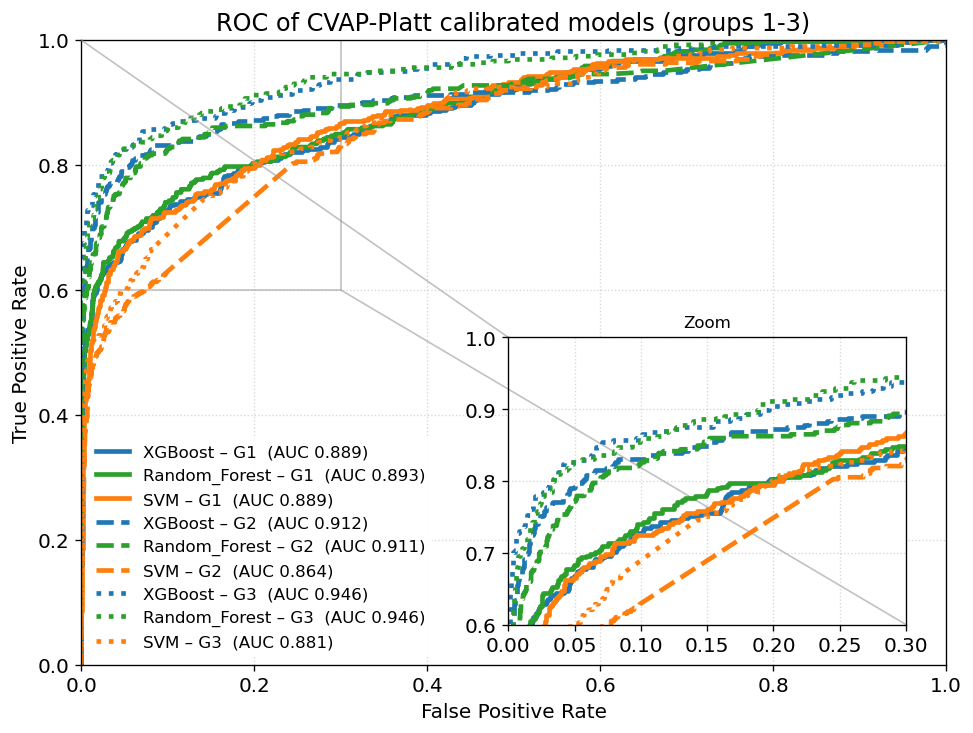

In [15]:
# ==============================================================
#  ROC — CVAP-Platt models, 3 algs × 3 groups  (full test set)
# ==============================================================

import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# --------------------------------------------------
# 1) Dataset & split
# --------------------------------------------------
CSV_PATH = 'data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv'
df = pd.read_csv(CSV_PATH)
df = df[df['acs_mu_class'] != 3]                # drop fakes
df['acs_mu_class'] = df['acs_mu_class'].map({1: 0, 2: 1})

# feature lists (exactly as in your training notebook)
morphology_features = ['area','fwhm','stell','ell','rk','rf']
morphology_err      = ['s2n']
morphology_mags_errors = morphology_features + morphology_err

OPTICAL_MAG_COLS = [f'F{w}W' for w in
                    ['365','396','427','458','489','520','551','582','613',
                     '644','675','706','737','768','799','830','861','892',
                     '923','954']]
photometry_magnitudes    = OPTICAL_MAG_COLS + ['J','H','KS','F814W']
photometry_uncertainties = [f'd{x}' for x in OPTICAL_MAG_COLS] + ['dJ','dH','dKS','dF814W']
photometry_mags_errors   = photometry_magnitudes + photometry_uncertainties

GROUP_FEATURES = {
    1: morphology_mags_errors,
    2: photometry_mags_errors,
    3: morphology_mags_errors + photometry_mags_errors
}

TARGET_COL, TEST_SIZE, VAL_SIZE, SEED = 'acs_mu_class', 0.20, 0.20, 33

# Superset dataframe (group-3 features) for splitting
df_superset = df[GROUP_FEATURES[3] + [TARGET_COL]].dropna().copy()
X_full, y_full = df_superset[GROUP_FEATURES[3]], df_superset[TARGET_COL]

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_full, y_full, test_size=TEST_SIZE + VAL_SIZE,
    stratify=y_full, random_state=SEED)
X_val, X_test, y_val, y_test  = train_test_split(
    X_tmp, y_tmp, test_size=TEST_SIZE / (TEST_SIZE + VAL_SIZE),
    stratify=y_tmp, random_state=SEED)

print(f"Test sample size: {len(y_test)}")

# --------------------------------------------------
# 2) Load scalers for SVMs
# --------------------------------------------------
SCALERS = {}
for gid in (1, 2, 3):
    spath = os.path.join('trained_models', f'group_{gid}', f'scaler_group_{gid}.joblib')
    SCALERS[gid] = joblib.load(spath) if os.path.exists(spath) else None

# --------------------------------------------------
# 3) Load calibrated models
# --------------------------------------------------
ALGORITHMS = ['XGBoost', 'Random_Forest', 'SVM']
MODEL_ROOT = 'trained_models'
FILE_FMT   = '{alg}_group_{gid}_cvapplatt.joblib'

models = {}                                   # (alg, gid) ➜ estimator
for gid in (1, 2, 3):
    for alg in ALGORITHMS:
        fpath = os.path.join(MODEL_ROOT, f'group_{gid}', FILE_FMT.format(alg=alg, gid=gid))
        if not os.path.exists(fpath):
            print(f'⚠️  Missing: {fpath}')
            continue
        obj = joblib.load(fpath)
        models[(alg, gid)] = obj['model'] if isinstance(obj, dict) else obj

# --------------------------------------------------
# 4) Helper to get the exact feature list the model expects
# --------------------------------------------------
def feature_list(est, gid):
    if hasattr(est, 'feature_names_in_'):
        return list(est.feature_names_in_)
    if hasattr(est, 'final_estimator_') and hasattr(est.final_estimator_, 'feature_names_in_'):
        return list(est.final_estimator_.feature_names_in_)
    return GROUP_FEATURES[gid]

# --------------------------------------------------
# 5) Compute ROC curves
# --------------------------------------------------
roc_curves = {}   # (alg, gid) ➜ (fpr, tpr, auc)

for (alg, gid), est in models.items():
    cols = feature_list(est, gid)
    X_sub = X_test[cols]
    if alg == 'SVM' and SCALERS[gid] is not None:
        X_sub = pd.DataFrame(SCALERS[gid].transform(X_sub),
                             index=X_sub.index, columns=X_sub.columns)
    proba = est.predict_proba(X_sub)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_curves[(alg, gid)] = (fpr, tpr, auc(fpr, tpr))

# --------------------------------------------------
# 6) Plot (colour ↔ algorithm, line-style ↔ group)
# --------------------------------------------------
ALG_COLOUR = {'XGBoost':'#1f77b4', 'Random_Forest':'#2ca02c', 'SVM':'#ff7f0e'}
GRP_STYLE  = {1:'-', 2:'--', 3:':'}

plt.rcParams.update({'figure.dpi':120, 'font.size':12,
                     'axes.grid':True, 'grid.linestyle':':', 'grid.alpha':0.5})

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)

for (alg, gid), (fpr, tpr, auc_val) in roc_curves.items():
    ax.plot(fpr, tpr,
            color=ALG_COLOUR[alg],
            linestyle=GRP_STYLE[gid],
            lw=2.8,
            label=f'{alg} – G{gid}  (AUC {auc_val:.3f})')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC of CVAP-Platt calibrated models (groups 1-3)')
ax.set_xlim(0, 1); ax.set_ylim(0, 1)

# inset zoom: x 0–0.20, y 0.60–1.00
ax_ins = inset_axes(ax, width='46%', height='46%', loc='lower right',
                    bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes,
                    borderpad=2)
for (alg, gid), (fpr, tpr, _) in roc_curves.items():
    ax_ins.plot(fpr, tpr,
                color=ALG_COLOUR[alg],
                linestyle=GRP_STYLE[gid],
                lw=2.8)
ax_ins.set_xlim(0, 0.3); ax_ins.set_ylim(0.60, 1.00)
ax_ins.set_xticks(np.linspace(0,0.3,7)); ax_ins.set_yticks(np.linspace(0.60,1.00,5))
ax_ins.set_title('Zoom', fontsize=10)
mark_inset(ax, ax_ins, loc1=2, loc2=4, fc='none', ec='0.6', alpha=0.6)

# legend: lower-left, smaller font
leg = ax.legend(loc='lower left', prop={'size':10},
                frameon=True, fancybox=True, framealpha=0.95)
leg.get_frame().set_linewidth(0)

plt.show()


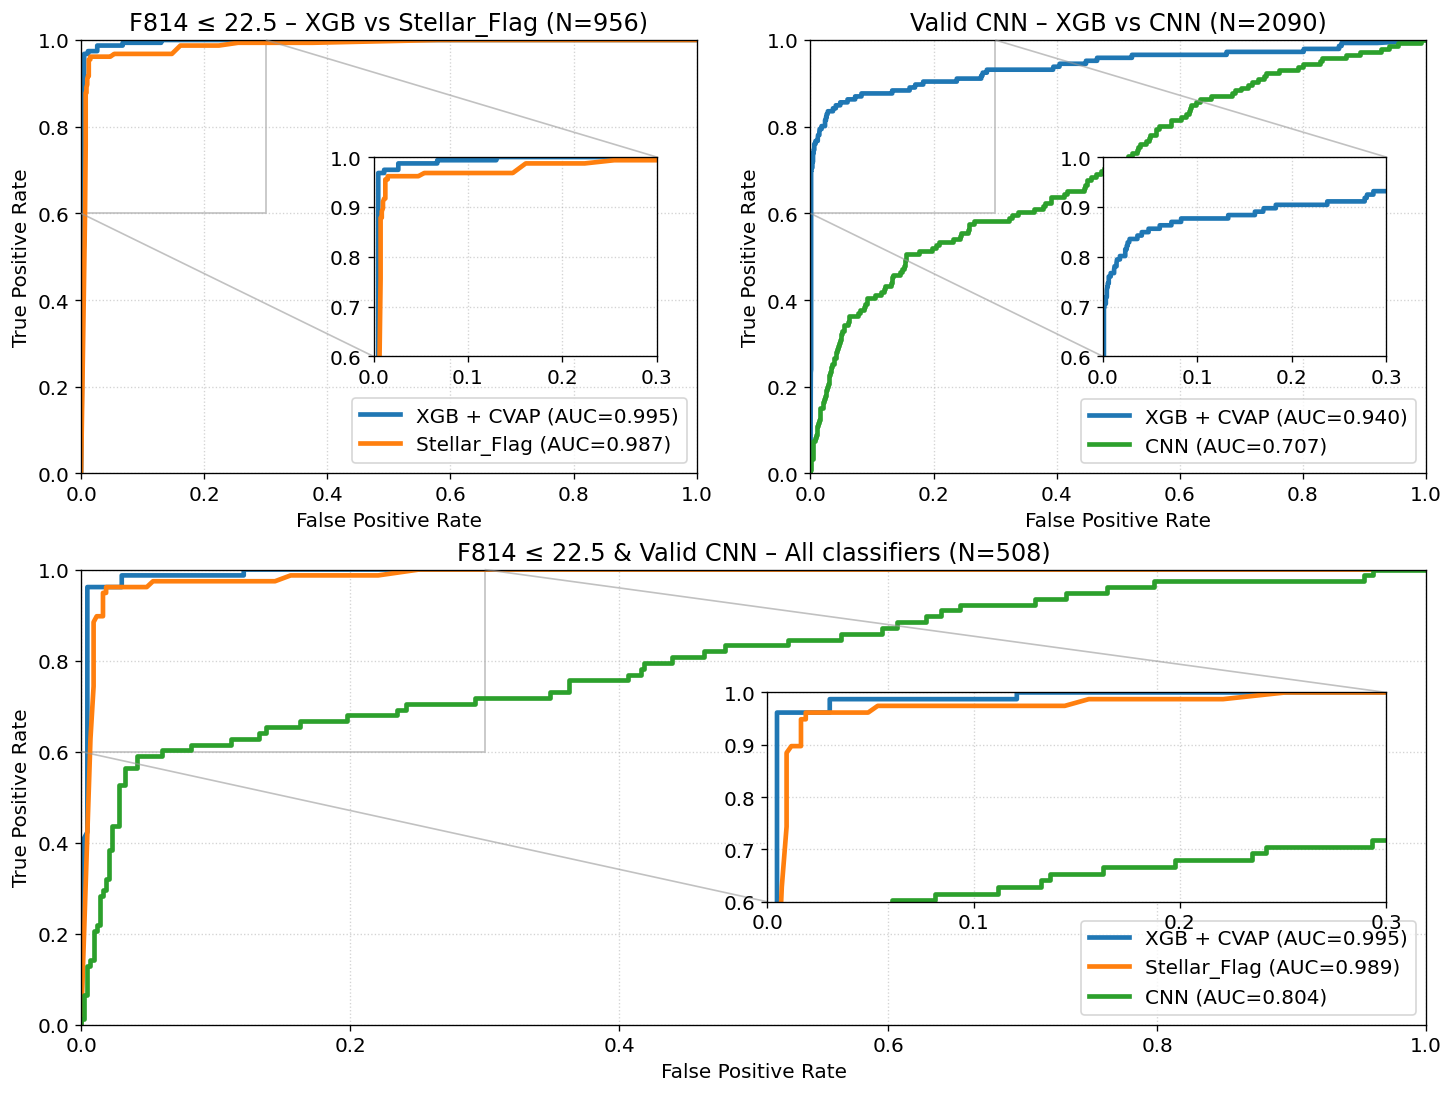

In [49]:
# ==============================================================
#  Three-panel ROC figure – inset moved to centre-right (loc=6)
# ==============================================================

import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# ------------------------------------------------------------------
# 0) Paths
# ------------------------------------------------------------------
CATALOGUE = "data/match_alhambra_cosmos2020_ACS_class_0.8arcsec.csv"
CNN_FILE  = "data/cnn.tsv"
MODEL     = os.path.join("trained_models", "group_3", "XGBoost_group_3_cvap.joblib")

# ------------------------------------------------------------------
# 1) Load catalogue & merge CNN
# ------------------------------------------------------------------
df = pd.read_csv(CATALOGUE)
cnn = (pd.read_csv(CNN_FILE, sep=";", comment="#", header=0, engine="python")
         .iloc[2:][["ID", "cnn"]])
cnn["ID"]  = pd.to_numeric(cnn["ID"],  errors="coerce").astype("Int64")
df["ID_1"] = pd.to_numeric(df["ID_1"], errors="coerce").astype("Int64")
df = df.merge(cnn, left_on="ID_1", right_on="ID", how="left").drop(columns="ID")

# ------------------------------------------------------------------
# 2) Clean target
# ------------------------------------------------------------------
df = df[df["acs_mu_class"] != 3]
df["acs_mu_class"] = df["acs_mu_class"].map({1: 0, 2: 1}).astype(int)

# ------------------------------------------------------------------
# 3) Re-create train/val/test split
# ------------------------------------------------------------------
TEST_SIZE, VAL_SIZE, SEED = 0.20, 0.20, 33
y_full = df["acs_mu_class"]

df_train, df_tmp, y_train, y_tmp = train_test_split(
    df, y_full, test_size=TEST_SIZE + VAL_SIZE,
    stratify=y_full, random_state=SEED
)
rel_val = VAL_SIZE / (TEST_SIZE + VAL_SIZE)
df_val, df_test = train_test_split(
    df_tmp, test_size=1 - rel_val,
    stratify=y_tmp, random_state=SEED
)

# ------------------------------------------------------------------
# 4) Masks
# ------------------------------------------------------------------
f814_mask      = df_test["F814W"] <= 22.5
cnn_num        = pd.to_numeric(df_test["cnn"], errors="coerce")
valid_cnn_mask = (~cnn_num.isna()) & (cnn_num != -1)
stellar_mask   = ~df_test["Stellar_Flag"].isna()

mask_tl     = f814_mask & stellar_mask
mask_tr     = valid_cnn_mask
mask_bottom = f814_mask & valid_cnn_mask & stellar_mask

n_tl, n_tr, n_bt = mask_tl.sum(), mask_tr.sum(), mask_bottom.sum()

# ------------------------------------------------------------------
# 5) Probabilities
# ------------------------------------------------------------------
morph_feat = ['area','fwhm','stell','ell','rk','rf']
morph_err  = ['s2n']
opt_mag = [f'F{w}W' for w in
           ['365','396','427','458','489','520','551','582','613','644',
            '675','706','737','768','799','830','861','892','923','954']]
phot_mag  = opt_mag + ['J','H','KS','F814W']
phot_err  = [f'd{x}' for x in opt_mag] + ['dJ','dH','dKS','dF814W']
GROUP3    = morph_feat + morph_err + phot_mag + phot_err

xgb = joblib.load(MODEL)
proba_xgb_all  = xgb.predict_proba(df_test[GROUP3])[:, 1]
proba_flag_all = df_test["Stellar_Flag"].astype(float)
proba_cnn_all  = cnn_num.astype(float)

# ------------------------------------------------------------------
# 6) ROC helper
# ------------------------------------------------------------------
def roc_for(mask, y_true, proba):
    fpr, tpr, _ = roc_curve(y_true[mask], proba[mask])
    return {"fpr": fpr, "tpr": tpr, "auc": auc(fpr, tpr)}

roc_tl_xgb = roc_for(mask_tl, df_test["acs_mu_class"], proba_xgb_all)
roc_tl_st  = roc_for(mask_tl, df_test["acs_mu_class"], proba_flag_all)

roc_tr_xgb = roc_for(mask_tr, df_test["acs_mu_class"], proba_xgb_all)
roc_tr_cnn = roc_for(mask_tr, df_test["acs_mu_class"], proba_cnn_all)

roc_bt_xgb = roc_for(mask_bottom, df_test["acs_mu_class"], proba_xgb_all)
roc_bt_st  = roc_for(mask_bottom, df_test["acs_mu_class"], proba_flag_all)
roc_bt_cnn = roc_for(mask_bottom, df_test["acs_mu_class"], proba_cnn_all)

# ------------------------------------------------------------------
# 7) Plotting
# ------------------------------------------------------------------
plt.rcParams.update({"font.size": 12, "figure.dpi": 120,
                     "axes.grid": True, "grid.linestyle": ":", "grid.alpha": 0.55})

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1.05])

ax_tl = fig.add_subplot(gs[0, 0])
ax_tr = fig.add_subplot(gs[0, 1])
ax_bt = fig.add_subplot(gs[1, :])

colors = {"XGB": "tab:blue", "Stellar": "tab:orange", "CNN": "tab:green"}

# -------- helper to add panel + inset (centre-right) --------
def add_panel(ax, curves, title, N):
    """curves = list of (curve_dict, label, color) tuples"""
    for curve, lab, col in curves:
        ax.plot(curve["fpr"], curve["tpr"], lw=2.8, color=col,
                label=f"{lab} (AUC={curve['auc']:.3f})")
    ax.set_title(f"{title} (N={N})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.legend(loc="lower right")

    # Zoom inset – loc=6 ("center right")
    ax_ins = inset_axes(ax, width="46%", height="46%", loc=7,
                        bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes,
                        borderpad=2)
    for curve, _, col in curves:
        ax_ins.plot(curve["fpr"], curve["tpr"], lw=2.8, color=col)
    ax_ins.set_xlim(0, 0.30); ax_ins.set_ylim(0.60, 1.00)
    ax_ins.set_xticks(np.linspace(0, 0.30, 4))
    ax_ins.set_yticks(np.linspace(0.60, 1.00, 5))
    ax_ins.grid(ls=":", alpha=0.55)
    mark_inset(ax, ax_ins, loc1=1, loc2=3, fc="none", ec="0.6", alpha=0.6)
# -------------------------------------------------------------

# --- top-left ---
add_panel(ax_tl,
          [(roc_tl_xgb, "XGB + CVAP", colors["XGB"]),
           (roc_tl_st,  "Stellar_Flag", colors["Stellar"])],
          "F814 ≤ 22.5 – XGB vs Stellar_Flag", n_tl)

# --- top-right ---
add_panel(ax_tr,
          [(roc_tr_xgb, "XGB + CVAP", colors["XGB"]),
           (roc_tr_cnn, "CNN",         colors["CNN"])],
          "Valid CNN – XGB vs CNN", n_tr)

# --- bottom ---
add_panel(ax_bt,
          [(roc_bt_xgb, "XGB + CVAP", colors["XGB"]),
           (roc_bt_st,  "Stellar_Flag", colors["Stellar"]),
           (roc_bt_cnn, "CNN",         colors["CNN"])],
          "F814 ≤ 22.5 & Valid CNN – All classifiers", n_bt)

plt.show()
